In [1]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import time
import datetime
from datetime import datetime, date
from datetime import timedelta
import talib
import pickle
from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
#from xgboost import XGB
from xgboost import XGBClassifier
from xgboost import DMatrix
import lightgbm as lgb
from scipy.signal import argrelextrema

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
from_date = date(2013,1,1)
to_date=datetime.now()

start= time.mktime(from_date.timetuple())
end = time.mktime(to_date.timetuple())

tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT',
 'USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG',
           'USDT_XTZ','USDT_BSV','USDT_MKR','USDT_ZRX','USDT_VET','USDT_BTG','USDT_ZIL']#bitfinex

def get_data(date,coin):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histohour?fsym="+coin+"&tsym=USD&limit=1000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_hourly(date,coin, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=USD&limit=999&toTs={}'\
            .format(date)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()#['Data']
    #df = pd.DataFrame(data)
    #df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return data


def get_df(from_date, to_date,coin):
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=True, inplace=True)
    df.to_csv("1h_"+coin + '.csv')
    print('Processed: ' + coin)
    return df

def coin_metrics(cap,coin,start,end):#used to get market cap and total volume
    if cap=='cap':
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/marketcap(usd)/'+str(start)+'/'+str(end)
    else:
        url='https://coinmetrics.io/api/v1/get_asset_data_for_time_range/'+coin+'/exchangevolume(usd)/'+str(start)+'/'+str(end)

    r=requests.get(url)
    ipdata = r.json()
    ipdata['result']
    cap=pd.DataFrame(ipdata['result'],columns=['date','cap'])
    date=[]
    for i in cap.date:
        date.append(pd.to_datetime(datetime.fromtimestamp(i)))
    cap.index=date
    cap=cap.resample('1H').ffill()
    return cap['cap']

#for x in tickers:
 #   get_df(start,end,x[5:])
    

In [2]:
def divergence(close,RSI,lookback,window,maxx,low):
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z])  
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    return bull_div,bear_div

def bbp(price):
    up, mid, low = talib.BBANDS(price, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price - low) / (up - low)
    return bbp

In [3]:
def retrieve_symbol_name(coin,window):
    col=['date','close']
    ndf=pd.read_csv("1h_"+coin+'.csv',index_col='time')
    ndf.index=pd.to_datetime(ndf.index)
    ndf=ndf.loc[(ndf!=0).any(axis=1)]
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf=ndf.drop_duplicates()
    ndf=ndf.resample('1H').ffill()
    pdf=pd.DataFrame(ndf).copy()
    pdf['1_day_high']=ndf['high'].rolling(24).max()
    pdf['1_day_low']=ndf['low'].rolling(24).min()
    new_index=pdf.index-timedelta(hours=24)
    pdf.index=new_index
    ndf['1day_high']=pdf['1_day_high']
    ndf['1day_low']=pdf['1_day_low']
    ndf['exit']=pdf['close']
    df=pd.DataFrame(ndf).copy()
    df['returns']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    div=divergence(df['close'],df['RSI'],24*4,window,70,40)
    df['bull_div']=0
    df['bull_div'].iloc[div[0]]=1
    df['bear_div']=0
    df['bear_div'].iloc[div[1]]=1
    #df['hid_bull_div']=0
    #df['hid_bull_div'].iloc[div[2]]=1
    #df['hid_bear_div']=0
    #df['hid_bear_div'].iloc[div[3]]=1
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['var']=df['returns'].rolling(50).var()
    df['50_var']=df['var'].rolling(50).mean()
    df['200_var']=df['var'].rolling(200).mean()
    df['600_var']=df['var'].rolling(600).mean()
    df['var_up_short']= (df['50_var']> df['200_var']).astype(float)
    df['var_up_long']= (df['200_var']> df['600_var']).astype(float)
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['returns'].rolling(50).std()
    df['rise']=(df['returns']>2*df['50_Std']).astype(float)
    df['fall']=(df['returns']<-2*df['50_Std']).astype(float)
    df['rise2']=(df['returns']>3.5*df['50_Std']).astype(float)
    df['fall2']=(df['returns']<-3.5*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df['Mom'] = talib.MOM(close, timeperiod=window)
    slowk, slowd = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['Stoch_k']=slowk
    df['Stoch_d']=slowd
    df['BB']=bbp(close)

    from_date = (df.index[0]-timedelta(hours=24))
    to_date=df.index[-1]
    start= int(time.mktime(from_date.timetuple()))
    end = int(time.mktime(to_date.timetuple()))
    try:
        cap=coin_metrics('cap',coin.lower(),start,end)
        cap=cap[cap.index>=df.index[0]]
        vol=coin_metrics('vol',coin.lower(),start,end)
        vol=vol[vol.index>=df.index[0]]
    except:
        cap=0
        vol=0
    df['Market_Cap']=cap
    df['Total_vol']=vol
    df['vol/cap']=df['volumeto']/df['Market_Cap']
    df['Total_vol/cap']=df['Total_vol']/df['Market_Cap']
    df['Pnl_Long']=((df['exit']-df['close'])/df['close'])*100
    df['Pnl_Short']=df['Pnl_Long']*-1
    df=df.dropna()
    df=df.resample('1H').ffill()
    return df

def all_coins():
    start=time.time()
    df=retrieve_symbol_name('BTC',14)
    for x in tickers[1:]:
        print(x)
        df=df.append(retrieve_symbol_name(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

df=all_coins()

#pickle the dataframe
filename = '1hr_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()



/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:74: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

NameError: name 'tickers' is not defined

In [5]:
#load dataframe
filename = '1hr_df'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()
#df=df.drop_duplicates()

In [171]:
def week_start(df):#filter index for sundays at 00am
    dayofweek = df.index.dayofweek
    hour = df.index.hour
    x=df.iloc[((dayofweek == 6) & (hour == 0))]
    return x.index


def weekly_momentum(df):#calculate weekly price and volume momentum
    n=(week_start(df)[-1]-week_start(df)[0])/7#number of weeks in dataframe
    n=n.days
    pmom = pd.DataFrame(0, index=np.arange(n), columns=df['coin'].unique())
    vmom= pd.DataFrame(0, index=np.arange(n), columns=df['coin'].unique())    
    date=week_start(df)[0]
    
    dates=[]
    for i in range(0,n,1):
        cur=df.loc[date+timedelta(hours=i*24*7)]#fut is prices one week after to cur
        fut=df.loc[date+timedelta(hours=i*24*7+7*24)]
        dates.append(date+timedelta(hours=i*24*7+7*24))
        for coin in cur['coin']:
            if len(fut[fut['coin']==coin]['close'])>0:
                pmom[coin].iloc[i]=(fut[fut['coin']==coin]['close'][0]-cur[cur['coin']==coin]['close'][0])/cur[cur['coin']==coin]['close'][0]
                vmom[coin].iloc[i]=(fut[fut['coin']==coin]['volumeto'][0]-cur[cur['coin']==coin]['volumeto'][0])/cur[cur['coin']==coin]['volumeto'][0]

    pmom.index=dates
    vmom.index=dates
    return pmom,vmom


def rank(mom,df):#rank each coin and assign 1,-1 to top and bottom performers
    n=(week_start(df)[-1]-week_start(df)[0])/7
    n=n.days
    pmom = pd.DataFrame(0, index=np.arange(n), columns=mom.columns)
    for i in range(n):
        row=mom.iloc[i,:].copy()
        row=row[abs(row)>0].sort_values(ascending=False)
        if len(row)<7:
            pmom.loc[i,row.index[0]]=1
            pmom.loc[i,row.index[-1]]=-1
        if len(row)>=7 and len(row)<15:
            pmom.loc[i,list(row.index[0:2])]=1
            pmom.loc[i,list(row.index[-2:])]=-1
        if len(row)>=15:
            pmom.loc[i,list(row.index[0:3])]=1
            pmom.loc[i,list(row.index[-3:])]=-1
    pmom.index=mom.index
    return pmom   

def assign_mom(df,p_rnk,v_rnk):#create two new columns in our existing df where each coin is assigned 1,0,-1 depending on their momentum. 
    df1=df.copy()
    df1['pmom']=0
    df1['vmom']=0
    for coin in df1.coin.unique():
        df1.loc[df1['coin']==coin,'pmom']=p_rnk[coin]
        df1.loc[df1['coin']==coin,'vmom']=v_rnk[coin]
    df1.fillna(0,inplace=True)
    return df1


mom=weekly_momentum(df)
df=assign_mom(df,rank(mom[0],df),rank(mom[1],df))


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
def entry_filter_long(df):
    df3=df.loc[(df['RSI_up']<1)].copy()# basic entry signal
    df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    df3['label']=(df3['max_return']>0.05).astype(int)#trying to identify trades who have bigger potential
    return df3

def entry_filter_short(df):
    df3=df.loc[(df['BB']>.7)].copy()
    df3['max_return']=(df3['close']-df3['1day_low'])/df3['close']
    df3['label']=(df3['max_return']>0.05).astype(int)
    return df3

entry=entry_filter_short(df)
entry=entry_filter_long(df)


features=df.columns[3:]
features=list(features)
x=['coin','Pnl_Long','Pnl_Short']
features=[e for e in features if e not in x]


print('Percent of Target Trades:', 100*(entry.label.sum()) / float(len(entry)))
len(entry)

Percent of Target Trades: 32.963816105192436


166704

In [1]:
def trade_evol(date,coin,df):#
    dates=[]
    perf=[]
    price=[]
    drawdowns=[perf]
    df=df[df['coin']==coin]
    for h in range(1,25):
        if date+timedelta(hours=24) < df.index[-1]:
            perf.append((df.close.loc[date+timedelta(hours=h)]-df.close.loc[date])/df.close.loc[date])
            dates.append(h)
            
    return perf


In [185]:
perf=[]#get the trade evolution for each trade
start=time.time()
for i in range(len(entry)):
    print(entry['coin'][i])
    perf.append(trade_evol(entry.index[i],entry['coin'][i],df))
print ("Runtime is " +str(time.time()-start)+" seconds")

LTC
LTC
LTC
LTC
BTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
BTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC


BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC


BTC
LTC
BTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
LTC
LTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC


LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
BTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC


LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC


LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
BTC
ETH
ETH
BTC
BTC
ETH
BTC
ETH
BTC
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
LTC
ETH
BTC
LTC
ETH
BTC
LTC
ETH
BTC
ETH
BTC
LTC
ETH
BTC
LTC
LTC
ETH
BTC
LTC
BTC
ETH
ETH
BTC
BTC
ETH
ETH
BTC
ETH
BTC
BTC
ETH
BTC
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
LTC
LTC
BTC
ETH
ETH
LTC
BTC
LTC
BTC
ETH
BTC
ETH
LTC
BTC
ETH
LTC
BTC
LTC
ETH
LTC
ETH
BTC
BTC
LTC
ETH
LTC
ETH
BTC
BTC
ETH
LTC
LTC
ETH
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
ETH
LTC
BTC
BTC
ETH
LTC
ETH
LTC
BTC
BTC
ETH
LTC
LTC
BTC
ETH
LTC
ETH
BTC
BTC
ETH
LTC
LTC
BTC
ETH
ETH
LTC
BTC
LTC
BTC
ETH
ETH
LTC
ETH
LTC
ETH
LTC
LTC
ETH
LTC
ETH
ETH
LTC
ETH
LTC
ETH
LTC
LTC
ETH
ETH
LTC
ETH
LTC
LTC
ETH
LTC
ETH
LTC
ETH
LTC
ETH
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
LTC
BTC
BTC


ETH
BTC
LTC
BTC
LTC
ETH
LTC
BTC
ETH
LTC
BTC
ETH
BTC
ETH
LTC
BTC
ETH
LTC
BTC
ETH
LTC
BTC
LTC
ETH
ETH
BTC
LTC
BTC
ETH
LTC
ETH
LTC
BTC
BTC
ETH
LTC
BTC
LTC
BTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
ETH
BTC
LTC
LTC
BTC
ETH
ETH
BTC
LTC
ETH
BTC
LTC
ETH
LTC
BTC
BTC
LTC
ETH
BTC
LTC
ETH
BTC
LTC
ETH
BTC
ETH
LTC
LTC
BTC
ETH
ETH
LTC
BTC
LTC
BTC
ETH
ETH
BTC
LTC
ETH
BTC
LTC
ETH
LTC
LTC
ETH
ETH
ETH
ETH
ETH
ETH
LTC
ETH
LTC
ETH
ETH
LTC
ETH
LTC
ETH
LTC
ETH
LTC
ETH
LTC
LTC
ETH
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
ETH
ETH
ETH
BTC
ETH
ETH
BTC
ETH
BTC
ETH
BTC
BTC
ETH
ETH
LTC
BTC
LTC
BTC
ETH
BTC
ETH
LTC
LTC
ETH
BTC
BTC
LTC
ETH
BTC
ETH
LTC
BTC
ETH
LTC
ETH
LTC
BTC
ETH
BTC
ETH
BTC
BTC
ETH
LTC
BTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
BTC
ETH
ETH
ETH
ETH
LTC
LTC
BTC
ETH
LTC
ETH
BTC
LTC
ETH
BTC
BTC
LTC
ETH
ETH
LTC
BTC
BTC
ETH
LTC
BTC
LTC
ETH
ETH
BTC
LTC
BTC
LTC
ETH
LTC
ETH
LTC
ETH
LTC
ETH
LTC
ETH
LTC
LTC
LTC
LTC
ETH
ETH
ETH
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC


LTC
LTC
ETH
BTC
BTC
LTC
ETH
ETH
LTC
BTC
BTC
LTC
ETH
BTC
ETH
BTC
ETH
BTC
ETH
ETH
BTC
ETH
ETH
ETC
ETC
ETH
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETC
ETH
ETH
ETC
ETH
ETC
ETH
ETC
LTC
ETC
ETH
ETC
ETH
LTC
ETC
LTC
ETH
LTC
ETC
ETH
ETH
ETC
LTC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETH
ETH
ETC
ETC
BTC
ETH
ETH
BTC
LTC
BTC
ETH
BTC
ETH
LTC
ETH
BTC
LTC
ETC
ETH
BTC
LTC
ETC
BTC
ETC
ETH
LTC
BTC
ETC
ETH
LTC
ETC
LTC
LTC
ETC
LTC
ETC
ETC
LTC
LTC
ETC
ETC
LTC
ETC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETH
ETC
ETC
ETC
ETH
ETC
ETC
ETC
ETC
ETC
ETC
BTC
ETH
ETH
BTC
ETC
ETC
ETH
BTC
ETH
ETC
BTC
BTC
LTC
ETH
ETC
LTC
ETH
BTC
ETC
ETC
LTC
ETH
BTC
BTC
LTC
ETH
ETC
ETC
BTC
LTC
ETH
ETC
ETH
LTC
BTC
ETC
BTC
ETH
LTC
ETC
BTC
ETH
LTC
ETC
ETH
BTC
LTC
BTC
LTC
ETC
ETH
BTC
LTC
ETC
ETH
BTC
ETH
LTC
ETC
ETC
ETH
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
ETC
ETC
LTC
ETC
LTC
ETC
ETC


LTC
BTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
LTC
ETH
BTC
BTC
ETH
LTC
BTC
ETH
LTC
ETH
LTC
BTC
LTC
BTC
ETH
LTC
BTC
ETH
BTC
ETH
ETH
ETH
ETH
ETC
ETH
ETH
ETC
ETC
ETH
ETH
ETC
ETH
ETC
ETC
ETH
ETH
ETC
ETC
ETH
ETC
ETC
ETC
ETC
ETC
LTC
ETH
ETH
ETC
LTC
ETH
LTC
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
BTC
BTC
LTC
ETH
ETH
BTC
LTC
BTC
LTC
ETH
LTC
BTC
ETH
LTC
BTC
ETH
LTC
BTC
ETH
BTC
LTC
ETH
ETH
LTC
BTC
LTC
ETH
BTC
ETH
BTC
LTC
BTC
ETH
ETC
LTC
BTC
ETC
LTC
ETH
BTC
ETC
ETH
LTC
BTC
LTC
ETC
ETH
LTC
ETC
BTC
ETH
ETH
BTC
LTC
ETC
ETH
LTC
ETC
BTC
LTC
ETC
BTC
ETC
LTC
BTC
LTC
BTC
ETC
ETC
BTC
LTC
BTC
ETC
LTC
LTC
ETC
BTC
LTC
ETC
BTC
BTC
LTC
ETC
ETC
BTC
LTC
ETC
BTC
LTC
ETC
BTC
LTC
BTC
ETC
LTC
BTC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETH
ETH
ETC
ETC
ETH
ETH
ETC
ETC
ETH
ETC
ETH
ETH
ETC
ETH
ETC
ETH
ETC
ETH
ETC
ETC
ETH
ETH
ETC
ETH
ETH
ETH
ETH
ETH
LTC
ETH
ETH
LTC
LTC
ETH
LTC
ETH
ETH
LTC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC


ETC
ZEC
ETH
ETH
ETC
ZEC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
ETC
LTC
LTC
ETC
LTC
ETC
ETC
LTC
ETC
LTC
ETC
LTC
LTC
ETC
LTC
ETC
ETC
LTC
LTC
ETC
ETC
LTC
ETC
LTC
ETC
LTC
LTC
ETC
LTC
ETC
LTC
ETC
ETC
LTC
LTC
ZEC
ETC
ZEC
LTC
ETC
ZEC
ETH
ETC
LTC
ETH
ZEC
ETC
ZEC
ETH
ETC
ZEC
ETC
ETH
ETH
ETC
LTC
ZEC
ZEC
ETH
LTC
ETC
ETC
ETH
LTC
ZEC
ZEC
ETC
ETH
LTC
ZEC
ETH
LTC
ETC
ZEC
ETC
ETH
ETC
ZEC
ETH
ETC
ZEC
ETH
ETH
ZEC
ETC
ETH
ZEC
ETC
ETC
ZEC
ZEC
ETC
ZEC
ETC
ETC
ZEC
ZEC
ETC
BTC
ZEC
ETC
ZEC
BTC
ETC
BTC
ETC
ZEC
ETC
ZEC
BTC
ZEC
BTC
ZEC
BTC
ZEC
BTC
BTC
ZEC
BTC
ZEC
BTC
ZEC
BTC
BTC
BTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
LTC
LTC
ETH
ETH
BTC
LTC
BTC
LTC
ETH
LTC
BTC
ETH
BTC
LTC
ETH
BTC
ZEC
LTC
ETH
ZEC
LTC
BTC
ETH
LTC
ETH
ZEC
BTC
BTC
LTC
ZEC
ETH
BTC
LTC
ETH
ZEC
LTC
ZEC
ETH
BTC
BTC
ETH
ZEC
LTC
ZEC
LTC
ETH
BTC
ZEC
ETH
BTC
LTC
BTC
ZEC
LTC
ETH
ZEC
ETH
LTC
BTC
ETH
LTC
BTC
ZEC
ETH
LTC
BTC
ZEC
BTC
LTC
ETH
ETH
LTC
BTC
BTC
LTC
ETH
BTC
LTC
ETH
BTC
LTC
ETH
ETH
LTC
BTC


ZEC
BTC
ETH
ZEC
BTC
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
ETH
LTC
LTC
ETH
LTC
ETH
LTC
ZEC
ETH
ZEC
LTC
ETH
LTC
ETH
ZEC
LTC
ETH
ZEC
ETH
LTC
ZEC
ZEC
ETH
LTC
ETH
LTC
ZEC
ETH
ZEC
LTC
ETH
ZEC
LTC
ZEC
ETH
LTC
ZEC
LTC
ETH
ZEC
LTC
ETH
ETH
LTC
ZEC
ZEC
ETH
ETH
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ETC
ZEC
ETC
LTC
ETC
ZEC
ETH
BTC
ETC
ZEC
LTC
ETC
ETH
ZEC
LTC
BTC
ZEC
LTC
ETC
BTC
ETH
ETC
ZEC
LTC
BTC
XMR
ETH
BTC
ZEC
LTC
ETH
ETC
XMR
LTC
BTC
ZEC
ETC
ETH
XMR
BTC
ETC
ETH
XMR
LTC
ZEC
BTC
LTC
ZEC
ETC
XMR
ETH
ETC
BTC
ZEC
XMR
ETH
LTC
XMR
ETC
BTC
ETH
ZEC
LTC
LTC
XMR
BTC
ETH
ETC
ZEC
BTC
XMR
ETH
ETC
LTC
ZEC
ZEC
ETH
BTC
XMR
LTC
ETC
ZEC
LTC
XMR
ETC
BTC
ETH
ETH
ZEC
LTC
XMR
ETC
BTC
XMR
ZEC
LTC
BTC
ETH
ETC
ETC
XMR
ZEC
LTC
ETH
BTC
LTC
ZEC
BTC
ETH
XMR
ETC
ETC
ETH
XMR
BTC
LTC
BTC
XMR
ETC
ETH
LTC
ETC
ETH
BTC
XMR
LTC
LTC
ETH
BTC
ETC
XMR
ETC
BTC
ETH
XMR
LTC
LTC
ETC
BTC
ETH
XMR
ETH
BTC
XMR
LTC
ETC
XMR
ETH
LTC
ETC
BTC
XMR
ETH
LTC
ETC
BTC
ETH
XMR
LTC
ETC
BTC
BTC
XMR
ETH
ETC
LTC
XMR
ETH
ETC
LTC
BTC
ETH
XMR
BTC
LTC
ETC
ETH
XMR


XMR
LTC
ETH
LTC
BTC
XMR
ETH
ZEC
ETC
ETC
BTC
ETH
ZEC
LTC
BTC
ETH
ETC
LTC
ZEC
ETC
LTC
ZEC
ETH
BTC
ETH
ZEC
LTC
BTC
ETC
ETC
LTC
BTC
ZEC
ETH
LTC
ZEC
ETC
ETH
BTC
BTC
LTC
ETH
ETC
ZEC
ETC
LTC
ZEC
BTC
ETH
ZEC
ETC
ETH
LTC
BTC
ZEC
BTC
LTC
ETH
LTC
ETH
XMR
ZEC
BTC
LTC
XMR
ZEC
BTC
ETH
BTC
LTC
ETH
ZEC
XMR
ZEC
BTC
ETH
LTC
XMR
ZEC
XMR
LTC
ETH
BTC
BTC
LTC
ETH
XMR
ZEC
ETH
BTC
ZEC
XMR
LTC
BTC
XMR
ETH
ZEC
LTC
XMR
LTC
BTC
ETH
ZEC
ZEC
XMR
LTC
BTC
ETH
ETH
ZEC
BTC
LTC
XMR
BTC
ZEC
XMR
ETH
LTC
LTC
BTC
XMR
ETH
ZEC
ETH
LTC
ZEC
XMR
BTC
ETH
LTC
BTC
ZEC
XMR
BTC
ETH
XMR
LTC
ZEC
LTC
ZEC
XMR
BTC
ETH
ZEC
BTC
LTC
XMR
ETH
BTC
LTC
ETC
XMR
ETH
ZEC
BTC
XMR
ZEC
ETC
ETH
LTC
ETH
XMR
BTC
LTC
ZEC
ETC
ZEC
ETC
BTC
XMR
ETH
XMR
BTC
ETC
ETH
ZEC
ETH
XMR
ETC
BTC
ZEC
ETH
XMR
BTC
ZEC
ETC
ZEC
ETH
ETC
XMR
ETC
ETH
ZEC
XMR
XMR
ETH
ZEC
ZEC
ZEC
BTC
ETH
BTC
BTC
ETH
ETH
BTC
ETH
BTC
BTC
ETH
ZEC
ETH
ZEC
BTC
ETH
ZEC
BTC
ETH
BTC
ZEC
BTC
ETH
ETC
BTC
ETH
ETC
BTC
ETH
ETH
ETC
BTC
ETC
ETH
ETC
ETH
ETC
ETH
ETH
ETC
ETC
ETH
XMR
ETC
ETH
XMR
ETH
ETC
ETC
XMR
ETH


LTC
ETC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
ETH
ETH
XMR
XMR
ETH
XMR
ETH
ETH
XMR
XMR
ETH
XMR
ETH
XMR
ETH
ETH
XMR
XMR
ETH
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
XMR
ETH
XMR
ETH
XMR
ETH
XMR
ETH
XMR
ETH
XMR
ETH
XMR
ETH
XMR
XMR
ETH
XMR
ETH
BTC
XMR
ETH
BTC
ZEC
ZEC
XMR
ETH
BTC
LTC
ETH
BTC
XMR
LTC
ZEC
LTC
ETH
XMR
ZEC
BTC
XMR
LTC
ETH
ZEC
BTC
XMR
LTC
ZEC
ETH
BTC
BTC
LTC
ETH
XMR
ZEC
XMR
ETH
BTC
LTC
ZEC
XMR
LTC
ZEC
ETH
BTC
ZEC
BTC
XMR
LTC
ETH
ETC
ZEC
LTC
ETH
BTC
XMR
ETH
ETC
LTC
XMR
ZEC
BTC
ETC
XMR
BTC
LTC
ZEC
ETH
ETC
ETH
BTC
ZEC
LTC
XMR
ZEC
ETC
XMR
LTC
ETH
ETC
XMR
LTC
ZEC
ETH
XMR
ETC
LTC
ZEC
ETH
ZEC
ETH
ETC
LTC
XMR
ETH
ETC
ZEC
LTC
XMR
LTC
BTC
ETC
ZEC
XMR
ETH
ETC
BTC
ETH
LTC
XMR
ZEC
ETH
BTC
LTC
ETC
ZEC
XMR
ETH
LTC
BTC
ZEC
XMR
ETC
BTC
ZEC
ETC
LTC
ETH
XMR
BTC
LTC
ETC
ETH
XMR
ZEC
BTC
XMR
ZEC
LTC
ETC
ETH
ETH
ZEC
BTC
XMR
LTC
ETC
BTC
XMR
LTC
ETC
ZEC
ETH
LTC
ETC
ZEC
BTC
ETH
XMR
XMR
LTC


DASH
LTC
BTC
ETH
DASH
LTC
BTC
ETC
DASH
ETC
LTC
BTC
LTC
BTC
ETC
DASH
DASH
LTC
BTC
ETC
ETH
ETH
LTC
ETC
BTC
DASH
BTC
ETC
ETH
LTC
DASH
ETC
DASH
ETH
BTC
LTC
DASH
BTC
ETC
ETH
LTC
BTC
ETH
ETC
LTC
DASH
ETC
DASH
ETH
BTC
LTC
BTC
LTC
ETH
DASH
ETC
DASH
ETH
ETC
BTC
LTC
LTC
ETH
ETC
BTC
DASH
ETC
BTC
ETH
DASH
LTC
BTC
LTC
ETC
ETH
BTC
LTC
BTC
LTC
LTC
BTC
BTC
LTC
LTC
BTC
BTC
LTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
ETH
ETH
BTC
BTC
ETH
ETC
ETC
BTC
ETH
LTC
ETH
BTC
ETC
BTC
LTC
ETH
ETC
BTC
ETC
LTC
ETH
LTC
DASH
BTC
ETC
ETH
LTC
BTC
ETC
ETH
XMR
DASH
ETC
LTC
XMR
DASH
ETH
BTC
DASH
XMR
LTC
BTC
ETC
ETH
ETC
XMR
ETH
DASH
LTC
LTC
DASH
ETC
ETH
XMR
LTC
XMR
DASH
ETH
ETC
ZEC
XMR
LTC
ETC
DASH
ETH
XMR
LTC
ZEC
ETC
ETH
DASH
ETH
ETC
XMR
DASH
LTC
ZEC
DASH
ETC
ZEC
ETH
LTC
XMR
ZEC
LTC
DASH
ETC
XMR
ETH
XMR
ETH
LTC
ZEC
ETC
DASH
DASH
LTC
ETH
ZEC
XMR
ETC
ETH
ZEC
LTC
XMR
ETC
DASH
ZEC
ETC
ETH
LTC
XMR
DASH
DASH
XMR
ZEC
ETH
ETC
LTC
ETC
XMR
LTC
ZEC
DASH
ETH
ZEC
XMR
LTC
ETH
ETC
DASH
ETH
LTC
ET

DASH
XMR
DASH
ETC
XMR
DASH
ZEC
DASH
LTC
XMR
ZEC
ETH
ETC
ZEC
ETH
DASH
LTC
XMR
ETC
DASH
LTC
ZEC
ETC
ETH
XMR
XMR
ETC
LTC
ETH
DASH
ZEC
DASH
ETH
LTC
XMR
ETC
ZEC
DASH
XMR
ETC
LTC
ETH
ZEC
XMR
ETH
DASH
ZEC
ETC
LTC
LTC
ZEC
XMR
ETC
DASH
ETH
DASH
XMR
ZEC
ETC
ETH
LTC
ZEC
ETH
XMR
DASH
ETC
LTC
LTC
ZEC
XMR
ETH
ETC
DASH
ZEC
DASH
ETC
XMR
LTC
ETH
ETC
ZEC
DASH
XMR
LTC
ETH
ETH
DASH
XMR
LTC
ZEC
ETC
DASH
XMR
LTC
ETC
ETH
ZEC
ETH
DASH
XMR
LTC
ZEC
ETC
ETC
ETH
DASH
XMR
ZEC
LTC
LTC
ZEC
ETC
ETH
XMR
DASH
ETH
ETC
LTC
XMR
ZEC
DASH
ETH
ETC
XMR
ZEC
DASH
LTC
ZEC
ETC
ETH
LTC
XMR
DASH
ETH
DASH
ZEC
LTC
ETC
XMR
ZEC
LTC
XMR
DASH
ETH
ETC
XMR
ETC
DASH
LTC
ZEC
ETH
ETH
XMR
ETC
LTC
BTC
DASH
ZEC
BTC
LTC
XMR
ZEC
ETH
ETC
DASH
DASH
BTC
XMR
ETC
ETH
ZEC
LTC
ETC
XMR
DASH
LTC
ZEC
BTC
ETH
ETC
ETH
LTC
BTC
ZEC
DASH
ETH
DASH
ETC
BTC
BTC
ETC
DASH
ETH
ETH
ETC
BTC
ETC
ETH
BTC
DASH
ZEC
BTC
ETH
ETC
ZEC
BTC
ETC
ZEC
ETH
ETH
ZEC
BTC
ETC
ZEC
DASH
ETH
ETC
BTC
ZEC
ETH
DASH
BTC
ETC
ETH
ETC
BTC
ZEC
ZEC
ETH
BTC
ETC
ZEC
ETH
ETC
BTC
ZEC
ETH
BTC
ETC
ZEC
BTC

ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
DASH
XMR
ZEC
DASH
XMR
ZEC
DASH
ZEC
XMR
XMR
DASH
ZEC
XMR
DASH
ZEC
DASH
LTC
ZEC
XMR
LTC
ZEC
DASH
XMR
LTC
ZEC
XMR
DASH
ZEC
LTC
DASH
XMR
DASH
ZEC
XMR
LTC
LTC
XMR
DASH
ZEC
ZEC
XMR
LTC
DASH
LTC
ZEC
DASH
XMR
ETH
XMR
DASH
LTC
ZEC
ETH
DASH
LTC
ETH
XMR
ZEC
ETH
XMR
ZEC
DASH
LTC
LTC
ETH
ZEC
XMR
DASH
ZEC
ETC
DASH
XMR
LTC
ETH
XMR
LTC
ETH
ZEC
ETC
DASH
DASH
ETH
ZEC
ETC
XMR
LTC
DASH
ETC
LTC
ZEC
ETH
XMR
DASH
ETH
ZEC
LTC
ETC
XMR
XMR
LTC
ZEC
ETH
ETC
DASH
XMR
ZEC
ETC
DASH
ETH
LTC
ETC
XMR
LTC
ZEC
ETH
DASH
DASH
ZEC
XMR
LTC
ETH
ETC
ZEC
ETC
ETH
LTC
XMR
DASH
DASH
ETH
ZEC
LTC
XMR
ETC
LTC
XMR
ETC
DASH
ZEC
ETH
ETH
BTC
ETC
ZEC
DASH
LTC
XMR
BTC
DASH
ETH
LTC
ZEC
ETC
XMR
ZEC
XMR
DASH
ETH
ETC
BTC
LTC
ZEC
BTC
ETC
LTC
ETH
DASH
XMR
LTC
ETH
DASH
ZEC
XMR
BTC
ETC
BTC
LTC
ETH
XMR
ETC
DASH
ZEC
ETH
ZEC
BTC
XMR
ETC
DASH
LTC
BTC
DASH
ETH
XMR
ZEC
ETC
LTC
LTC
ETH
BTC
XMR
ZEC
ETC
DASH
BTC
ETC
LTC
DASH
ETH
XMR
ZEC
ZEC
ETC
ETH
BTC
DASH
LTC
XMR
LTC
ETC
DASH
ZEC
XMR
BTC
ETH
BTC
XMR
ZEC
ETC
LTC
DASH
ETH
ZE

ZEC
BTC
DASH
LTC
ETC
ZEC
BTC
LTC
DASH
ETH
XMR
ZEC
ETH
ETC
XMR
DASH
LTC
BTC
ETH
LTC
DASH
BTC
ETC
XMR
ZEC
ZEC
ETH
ETC
XMR
DASH
LTC
BTC
XMR
DASH
ZEC
LTC
ETH
BTC
ETC
ETH
LTC
ZEC
DASH
BTC
ETC
XMR
ZEC
BTC
XMR
ETC
DASH
LTC
ETH
XMR
LTC
ETC
ZEC
ETH
BTC
DASH
XMR
ZEC
ETC
DASH
LTC
ETH
BTC
BTC
ZEC
XMR
LTC
ETC
DASH
ETH
XMR
LTC
ETH
ZEC
DASH
ETC
BTC
XMR
LTC
ETC
DASH
ZEC
ETH
BTC
BTC
ETH
XMR
LTC
ETC
DASH
ZEC
XRP
DASH
ZEC
LTC
ETH
XMR
BTC
ETC
XRP
DASH
ZEC
ETH
ZEC
XRP
ZEC
XRP
XRP
ZEC
ZEC
XRP
ZEC
XRP
XRP
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
ZEC
LTC
LTC
LTC
BTC
XRP
LTC
DASH
XRP
BTC
LTC
XMR
DASH
DASH
LTC
BTC
XRP
XMR
XRP
XMR
BTC
ZEC
LTC
DASH
ZEC
XRP
LTC
XMR
BTC
DASH
XRP
ZEC
ETC
DASH
ETH
LTC
BTC
XMR
LTC
ZEC
XMR
ETH
DASH
BTC
ETC
XRP
XRP
ZEC
ETH
DASH
BTC
XMR
LTC
ETC
BTC
ETC
XMR
ZEC
LTC
ETH
DASH
ZEC
DASH
ETC
BTC
ETH
XMR
LTC
ETH
ETC
LTC
XMR
BTC
ZEC
DASH
ETH
ETC
LTC
ZEC
XMR
BTC
DASH
ETC
BTC
ZEC
DASH
XMR
LTC
ETH
XMR
ETC
LTC
ZEC
DASH
ETH
BTC
BTC
XMR
LTC
ETH
ETC
ZEC
DASH
DASH
ZEC
BTC
ETH
LTC
XMR


XMR
LTC
XMR
LTC
LTC
XMR
LTC
XMR
LTC
LTC
ETC
LTC
LTC
LTC
LTC
LTC
LTC
LTC
DASH
LTC
LTC
DASH
BTC
LTC
DASH
BTC
DASH
LTC
DASH
LTC
DASH
LTC
DASH
LTC
BTC
BTC
DASH
LTC
LTC
DASH
DASH
LTC
LTC
DASH
LTC
DASH
DASH
LTC
DASH
LTC
DASH
LTC
LTC
DASH
LTC
BTC
XRP
DASH
XRP
DASH
BTC
LTC
DASH
BTC
LTC
XRP
DASH
LTC
BTC
XMR
ZEC
XRP
BTC
LTC
XMR
DASH
XRP
ZEC
ETH
DASH
XMR
LTC
ETC
ETH
XRP
BTC
ZEC
LTC
BTC
ETH
ZEC
ETC
XRP
XMR
DASH
BTC
XMR
ETH
DASH
ETC
LTC
XRP
ZEC
DASH
LTC
ETH
BTC
XMR
ETC
XRP
ZEC
BTC
LTC
ETC
XMR
DASH
ZEC
XRP
ETH
XRP
DASH
XMR
LTC
ZEC
ETC
BTC
ETH
BTC
XMR
ETH
ETC
ZEC
DASH
LTC
XRP
ETH
XRP
DASH
LTC
ZEC
ETC
BTC
XMR
BTC
LTC
DASH
ETC
ETH
ZEC
XRP
XMR
BTC
XRP
ETH
ETC
DASH
XMR
ZEC
LTC
DASH
BTC
LTC
ETC
XMR
ETH
XRP
ZEC
DASH
BTC
LTC
XRP
XMR
ETC
ETH
ZEC
XMR
LTC
ETC
DASH
BTC
XRP
ZEC
ETH
ZEC
ETC
XMR
DASH
BTC
XRP
ETH
LTC
ETC
XMR
ETH
XRP
DASH
ZEC
LTC
BTC
ZEC
XMR
LTC
ETC
ETH
XRP
BTC
DASH
XMR
ETH
ETC
DASH
LTC
BTC
XRP
ZEC
DASH
XMR
LTC
ETC
ETH
BTC
ZEC
XRP
BTC
LTC
XRP
XMR
DASH
ETH
ZEC
ETC
ETC
ETH
ZEC
XMR
XRP
DASH
LTC
BTC
XMR

ETC
XRP
XMR
BTC
DASH
LTC
XRP
ETC
XMR
ETH
ZEC
BTC
LTC
DASH
XRP
ETH
ZEC
ETC
XMR
BTC
ZEC
XRP
ETH
XMR
DASH
LTC
ETC
ZEC
XMR
DASH
LTC
XRP
ETC
BTC
ETH
DASH
ZEC
BTC
XMR
ETH
XRP
LTC
ETC
XRP
BTC
XMR
ETH
DASH
ZEC
LTC
ETC
DASH
ZEC
XMR
XRP
ETH
LTC
BTC
ETC
ETH
ETC
ZEC
DASH
XMR
LTC
BTC
XRP
BTC
XRP
XMR
LTC
ZEC
ETH
ETC
DASH
ETC
XMR
BTC
XRP
ETH
ZEC
LTC
DASH
BTC
ETC
XRP
ZEC
ETH
DASH
LTC
XMR
XMR
DASH
ETC
ZEC
LTC
XRP
BTC
ETH
ETC
BTC
DASH
XMR
XRP
ETH
ZEC
LTC
DASH
BTC
XRP
ETC
LTC
ETH
XMR
ZEC
ETC
DASH
XMR
BTC
ETH
LTC
ZEC
XRP
XMR
ZEC
BTC
ETC
XRP
ETH
LTC
DASH
XMR
ZEC
XRP
LTC
ETH
BTC
DASH
ETC
XMR
LTC
ZEC
DASH
ETH
XRP
ETC
BTC
ETC
XMR
XRP
BTC
LTC
DASH
ZEC
XMR
DASH
BTC
XRP
XMR
BTC
DASH
BTC
DASH
XMR
BTC
XMR
DASH
BTC
DASH
XMR
BTC
DASH
XMR
XMR
DASH
DASH
XMR
XMR
DASH
XMR
DASH
ZEC
XMR
DASH
DASH
XMR
ZEC
DASH
XMR
XMR
DASH
XMR
XMR
ZEC
XMR
XMR
ZEC
ZEC
XMR
XMR
XRP
ZEC
XMR
XRP
ZEC
ETC
ETC
XMR
XRP
ZEC
ETH
XMR
XRP
ETC
DASH
ZEC
ETH
ETH
DASH
XRP
LTC
XMR
ZEC
ETC
DASH
XMR
LTC
ZEC
ETC
ETH
XRP
ETC
ZEC
DASH
XMR
XRP
ETH
LTC
LTC
ETC
XMR

EOS
EOS
DASH
XMR
ETC
OMG
XRP
EOS
XMR
XRP
DASH
ETC
OMG
LTC
XRP
DASH
ETC
EOS
ETH
OMG
DASH
EOS
XRP
ZEC
ETC
LTC
OMG
ETH
OMG
ETH
ZEC
EOS
LTC
XRP
ETC
DASH
OMG
EOS
ETC
ZEC
DASH
LTC
XRP
ETH
DASH
BTC
OMG
ETH
ETC
XRP
ZEC
LTC
EOS
EOS
DASH
BTC
ETH
LTC
ZEC
ETC
XRP
OMG
ZEC
LTC
OMG
EOS
XRP
ETC
ETH
DASH
LTC
XRP
ETC
ZEC
OMG
EOS
DASH
ETH
ETH
ETC
LTC
ZEC
OMG
EOS
XRP
DASH
LTC
ZEC
ETC
ETH
EOS
XRP
OMG
DASH
DASH
EOS
XMR
OMG
ETC
ETH
ZEC
XRP
ETH
XRP
OMG
ZEC
ETC
DASH
ETC
DASH
ETH
BTC
ZEC
OMG
ETC
OMG
DASH
ETH
ZEC
BTC
ETH
BTC
ETC
DASH
OMG
ZEC
ZEC
ETH
BTC
ETC
DASH
LTC
OMG
BTC
DASH
ZEC
ETH
ETC
OMG
LTC
BTC
ETC
ETH
DASH
LTC
ZEC
ETC
LTC
DASH
ETH
BTC
ETC
DASH
ETH
BTC
LTC
XMR
XMR
LTC
ETH
DASH
BTC
ETH
DASH
XMR
BTC
LTC
LTC
ETH
XMR
DASH
BTC
XMR
LTC
BTC
ETH
DASH
BTC
ETH
DASH
LTC
XMR
LTC
ETH
BTC
DASH
XMR
BTC
XMR
DASH
ETH
LTC
BTC
DASH
LTC
BTC
DASH
DASH
BTC
BTC
DASH
DASH
BTC
DASH
BTC
BTC
BTC
BTC
BTC
BTC
BTC
BTC
OMG
ZEC
BTC
OMG
ZEC
LTC
LTC
ZEC
OMG
XMR
XMR
DASH
ZEC
OMG
LTC
ETC
LTC
DASH
XMR
OMG
ZEC
OMG
DASH
ETC
LTC
XMR
ZEC
DASH
E

ETC
LTC
LTC
ETC
ETC
LTC
XMR
ETC
LTC
XMR
ETC
LTC
LTC
XMR
ETC
LTC
ETC
XMR
ETC
LTC
XMR
ETC
XMR
LTC
ZEC
LTC
XMR
ZEC
ETC
ZEC
LTC
ETC
XMR
XMR
ZEC
LTC
LTC
XMR
ZEC
ZEC
XMR
LTC
XMR
ZEC
LTC
ZEC
XMR
LTC
XMR
ZEC
LTC
LTC
ZEC
XMR
ZEC
XMR
EOS
LTC
BCH
XMR
ZEC
EOS
ZEC
XMR
EOS
BCH
BCH
EOS
XMR
ZEC
BCH
EOS
XMR
EOS
XRP
BCH
XMR
ZEC
ZEC
EOS
BCH
XRP
XMR
LTC
BCH
EOS
XMR
XRP
BCH
XRP
LTC
XMR
EOS
XRP
XMR
EOS
LTC
LTC
XRP
XMR
EOS
EOS
LTC
XRP
XMR
ETC
BTC
EOS
LTC
XMR
XRP
BTC
EOS
ETH
ETC
XRP
LTC
XMR
XRP
XMR
ETH
EOS
BTC
LTC
ETC
ETH
BTC
XMR
OMG
LTC
XRP
ETC
EOS
LTC
XRP
OMG
XMR
ETC
ETH
BTC
EOS
XMR
ETH
BTC
XRP
LTC
OMG
ETC
EOS
EOS
XRP
BTC
XMR
ETH
ETC
OMG
LTC
LTC
ETC
XMR
OMG
EOS
ETH
BTC
OMG
ETC
EOS
BTC
XMR
LTC
ETH
LTC
ETC
BTC
EOS
OMG
ETH
BTC
ETC
ETH
LTC
EOS
EOS
BTC
ETH
ETC
EOS
ETC
BTC
ETH
ETC
EOS
ETH
BTC
BTC
ETH
EOS
ETH
EOS
BTC
BTC
ETH
EOS
BTC
ETH
EOS
OMG
EOS
BTC
OMG
ETH
OMG
ETH
EOS
BTC
OMG
ZEC
ETH
BTC
ZEC
OMG
BTC
ETH
ETH
ZEC
OMG
BTC
BTC
ZEC
ETH
OMG
ETH
OMG
ZEC
BTC
ZEC
OMG
ETH
ZEC
OMG
ETH
ZEC
OMG
ETH
ETH
ZEC
OMG
ZEC
ETH
OMG


XMR
BCH
XMR
ZEC
BTC
BCH
OMG
ETH
LTC
EOS
XRP
ETC
DASH
DASH
EOS
BCH
BTC
ETC
OMG
XMR
XRP
ETH
ZEC
LTC
ETH
XMR
DASH
OMG
ZEC
LTC
ETC
BTC
EOS
XRP
BCH
XRP
LTC
DASH
ETH
BCH
ETC
BTC
EOS
OMG
ZEC
DASH
LTC
BTC
XRP
ZEC
OMG
ETC
ETH
BCH
EOS
EOS
ETC
BTC
ETH
LTC
XRP
DASH
OMG
LTC
XRP
BTC
DASH
EOS
ETC
OMG
ETH
DASH
EOS
ETC
XRP
ETH
LTC
OMG
BTC
BTC
DASH
OMG
ETH
EOS
DASH
EOS
EOS
EOS
BTC
BTC
EOS
EOS
EOS
EOS
EOS
EOS
DASH
EOS
BTC
ETH
DASH
ETC
EOS
LTC
LTC
ETC
ETH
BCH
DASH
EOS
BTC
OMG
XRP
BCH
LTC
EOS
ETC
XRP
BTC
DASH
OMG
ETH
BCH
EOS
OMG
LTC
XMR
ETC
XRP
BTC
DASH
ETH
ETH
EOS
ETC
XMR
BTC
LTC
DASH
BCH
XRP
OMG
BTC
EOS
XMR
OMG
ETC
BCH
LTC
XRP
DASH
ETH
ZEC
ZEC
XMR
ETH
OMG
LTC
EOS
ETC
XRP
DASH
BTC
BCH
EOS
ETC
DASH
OMG
XRP
ZEC
BTC
LTC
XMR
BCH
ETH
BCH
LTC
OMG
EOS
ETC
DASH
ZEC
XMR
BTC
ETH
XRP
BCH
LTC
OMG
BTC
EOS
XRP
ETH
XMR
ZEC
DASH
ETC
ETH
EOS
LTC
DASH
XRP
XMR
BTC
ETC
ZEC
BCH
OMG
DASH
XRP
ZEC
LTC
BCH
ETC
ETH
EOS
BTC
XMR
OMG
LTC
XRP
DASH
ZEC
OMG
BTC
XMR
EOS
ETH
ETC
BCH
ETC
LTC
EOS
XRP
BTC
DASH
ZEC
ETH
BCH
XMR
OMG
ETH
ZEC
XRP

XRP
BCH
EOS
ETC
DASH
BTC
ETH
EOS
BCH
ZEC
ETC
LTC
XRP
OMG
XMR
XRP
XMR
ZEC
ETC
ETH
LTC
BCH
EOS
DASH
OMG
BTC
OMG
ETH
DASH
XRP
BCH
BTC
ETC
EOS
XMR
LTC
ZEC
OMG
ZEC
BTC
ETC
ETH
EOS
XRP
LTC
XMR
BCH
DASH
LTC
ETC
XRP
BCH
OMG
BTC
ETH
EOS
ZEC
XMR
DASH
OMG
BTC
ZEC
ETH
DASH
XMR
LTC
ETC
BCH
EOS
XRP
ZEC
XMR
LTC
EOS
BTC
ETC
BCH
ETH
OMG
XRP
DASH
ZEC
BCH
ETH
ETC
EOS
DASH
XRP
OMG
LTC
BTC
XMR
ZEC
ETH
DASH
OMG
ETC
EOS
XMR
LTC
XRP
BTC
BCH
XMR
ZEC
DASH
BTC
XRP
ETC
EOS
BCH
LTC
ETH
OMG
XRP
BCH
ETC
BTC
DASH
XMR
EOS
ETH
ZEC
OMG
LTC
LTC
BTC
BCH
XRP
DASH
EOS
XMR
ZEC
ETC
OMG
ETH
EOS
LTC
ZEC
XMR
XRP
BCH
BTC
OMG
ETC
ETH
DASH
LTC
ETH
BTC
OMG
ZEC
BCH
XRP
EOS
DASH
ETC
XMR
DASH
ETC
BCH
ETH
BTC
XRP
OMG
XMR
EOS
LTC
ZEC
ZEC
XMR
ETC
BTC
ETH
BCH
OMG
XRP
LTC
EOS
DASH
BTC
LTC
ETC
BCH
XMR
DASH
ETH
OMG
EOS
XRP
ZEC
OMG
ZEC
BTC
DASH
LTC
EOS
BCH
ETC
XMR
XRP
ETH
ZEC
XMR
ETH
EOS
BTC
LTC
BCH
OMG
XRP
DASH
ETC
EOS
ZEC
OMG
ETC
XMR
LTC
ETH
XRP
BTC
BCH
DASH
OMG
ETC
XMR
XRP
ZEC
DASH
BCH
EOS
LTC
ETH
BTC
XMR
ETH
LTC
BCH
OMG
DASH
BTC
EOS
ZEC
ET

EOS
XRP
NEO
BCH
ETH
BCH
EOS
DASH
NEO
OMG
XMR
XRP
ZEC
DASH
BCH
OMG
XRP
EOS
ZEC
ETH
ETC
XMR
NEO
XMR
ETH
XRP
EOS
BCH
OMG
DASH
ETC
NEO
ZEC
BCH
DASH
EOS
XRP
XMR
ZEC
ETH
OMG
NEO
ETC
ZEC
NEO
XMR
BCH
XRP
ETC
OMG
ETH
EOS
DASH
OMG
NEO
XRP
ETC
ZEC
XMR
ETH
EOS
BCH
DASH
OMG
XMR
NEO
BCH
DASH
ETC
XRP
ETH
EOS
ZEC
OMG
XMR
ZEC
ETC
XRP
ETH
DASH
BCH
NEO
EOS
XMR
NEO
XRP
ZEC
OMG
ETC
DASH
EOS
BCH
LTC
XRP
EOS
BCH
XMR
OMG
ETC
LTC
NEO
OMG
ETC
LTC
XRP
BCH
EOS
NEO
OMG
BCH
LTC
ETC
XRP
EOS
BTC
OMG
EOS
LTC
XRP
LTC
BTC
EOS
OMG
OMG
BTC
LTC
EOS
LTC
OMG
BTC
EOS
EOS
LTC
BTC
OMG
BTC
LTC
EOS
OMG
EOS
OMG
LTC
BTC
OMG
EOS
LTC
BTC
LTC
OMG
EOS
BTC
OMG
LTC
BTC
EOS
EOS
LTC
BTC
OMG
BTC
EOS
OMG
LTC
EOS
BTC
LTC
LTC
BTC
EOS
LTC
EOS
BTC
ETC
LTC
BTC
EOS
EOS
LTC
ETC
BTC
BTC
EOS
ETC
LTC
LTC
EOS
BTC
ETC
EOS
ETC
LTC
BTC
EOS
ETC
LTC
BTC
ETC
BTC
LTC
LTC
BTC
ETC
BTC
ETC
LTC
LTC
ETC
BTC
BTC
LTC
ETC
BTC
ETC
BTC
ETH
BTC
BTC
OMG
ETH
OMG
BTC
ETH
ETH
NEO
BTC
OMG
BTC
ETH
NEO
EOS
OMG
XRP
EOS
OMG
NEO
ETH
BTC
NEO
BTC
EOS
XRP
OMG
ETH
OMG
NEO
ETH
EOS
BTC

EOS
XMR
XRP
ETH
ETC
ETH
OMG
EOS
XRP
XMR
LTC
NEO
DASH
ETH
XMR
XRP
NEO
DASH
OMG
EOS
XRP
XMR
DASH
OMG
ETH
NEO
EOS
OMG
ETH
DASH
XMR
XRP
NEO
OMG
XMR
XRP
ETH
ZEC
DASH
NEO
NEO
DASH
XMR
ZEC
OMG
ETH
OMG
ZEC
DASH
XMR
NEO
ETH
XMR
DASH
NEO
ETH
OMG
XMR
DASH
ETH
NEO
OMG
OMG
DASH
NEO
XMR
OMG
DASH
NEO
DASH
NEO
OMG
OMG
DASH
NEO
NEO
DASH
OMG
OMG
DASH
NEO
DASH
NEO
OMG
OMG
NEO
DASH
NEO
OMG
DASH
NEO
OMG
DASH
OMG
ETH
NEO
DASH
ETH
DASH
NEO
OMG
BCH
XRP
XRP
DASH
BCH
NEO
OMG
ETH
XRP
DASH
NEO
BCH
ETH
NEO
LTC
ETC
DASH
ETH
ETC
ETH
NEO
DASH
LTC
XMR
ETC
DASH
ETH
LTC
EOS
DASH
XMR
LTC
EOS
ETC
EOS
LTC
ETC
XRP
XMR
DASH
EOS
XMR
BTC
XRP
DASH
ETC
LTC
EOS
LTC
XMR
XRP
DASH
ETC
BTC
BTC
DASH
EOS
ETC
XMR
LTC
XRP
ETC
XMR
XRP
BTC
EOS
DASH
LTC
ETC
XMR
XRP
LTC
EOS
DASH
BTC
XRP
ETC
BTC
XMR
LTC
DASH
EOS
XRP
BTC
LTC
XMR
DASH
ETC
EOS
EOS
ETC
BTC
LTC
XMR
DASH
XRP
XRP
DASH
XMR
EOS
ETH
BTC
ETC
LTC
EOS
ETH
BTC
XMR
LTC
ETC
XRP
DASH
EOS
XMR
ETC
ETH
LTC
BTC
DASH
XRP
DASH
ETH
XRP
XMR
LTC
BTC
ETC
EOS
ETC
BTC
ETH
XMR
EOS
XRP
LTC
DASH
XRP
BTC
DAS

XMR
ETH
NEO
DASH
ETH
ETC
BCH
OMG
XMR
ETC
XMR
DASH
OMG
NEO
ETH
ETH
XMR
ETC
OMG
NEO
DASH
ETH
OMG
DASH
XMR
ETC
ETH
DASH
XMR
OMG
ETC
XMR
ETC
DASH
OMG
ETH
ETH
ETC
XMR
OMG
DASH
OMG
ETC
DASH
XMR
ETC
XMR
DASH
ETC
XMR
ETC
XMR
ETC
XMR
XMR
ETC
ETC
XMR
XMR
XMR
XMR
LTC
LTC
LTC
LTC
LTC
BCH
LTC
BCH
BCH
LTC
LTC
BCH
BCH
BTC
LTC
BCH
BTC
LTC
BTC
BCH
LTC
BTC
LTC
BTC
LTC
LTC
BTC
LTC
BTC
BTC
ZEC
LTC
BCH
LTC
ZEC
BTC
BTC
BCH
LTC
ZEC
LTC
ZEC
BCH
BTC
ZEC
BTC
XRP
LTC
BCH
ZEC
BTC
XRP
LTC
BCH
BTC
XRP
BCH
LTC
ZEC
LTC
BTC
XRP
ZEC
BCH
ZEC
EOS
DASH
LTC
XRP
BTC
BCH
LTC
DASH
XRP
BCH
EOS
ZEC
BTC
BTC
EOS
XRP
LTC
BCH
NEO
BCH
LTC
XRP
BTC
EOS
NEO
LTC
EOS
BCH
XRP
BTC
BTC
OMG
EOS
XRP
DASH
NEO
OMG
XRP
DASH
NEO
BTC
EOS
NEO
DASH
XRP
BTC
OMG
EOS
XRP
OMG
EOS
DASH
ETH
NEO
BTC
EOS
ETH
OMG
XMR
XRP
NEO
DASH
BTC
NEO
ETH
DASH
ZEC
XMR
XRP
OMG
BTC
EOS
XRP
NEO
EOS
OMG
XMR
ETH
BTC
DASH
ZEC
XRP
ETH
BTC
DASH
ZEC
NEO
OMG
LTC
EOS
XMR
LTC
DASH
EOS
BTC
XMR
ETH
OMG
XRP
ZEC
NEO
XRP
ETH
EOS
XMR
OMG
NEO
LTC
DASH
BTC
ZEC
ZEC
LTC
ETH
NEO
EOS
XMR
DASH
XR

ETC
BTC
DASH
BTG
OMG
BTC
LTC
ETC
ETH
XMR
EOS
ZEC
XRP
BCH
XRP
ETH
BTC
OMG
DASH
EOS
BCH
LTC
ETC
BTG
ZEC
XMR
OMG
BCH
ETC
ETH
BTC
XMR
EOS
LTC
ZEC
BTG
XRP
DASH
DASH
ETC
BTC
XMR
EOS
BTG
ZEC
XRP
BCH
LTC
OMG
ETH
XRP
ZEC
ETC
EOS
BTG
DASH
XMR
BCH
OMG
BTC
LTC
ETH
DASH
OMG
ETC
XRP
BTG
BTC
ZEC
LTC
ETH
EOS
BCH
XMR
BTC
XRP
BTG
LTC
DASH
ETH
EOS
ETC
ZEC
BCH
XMR
BTC
LTC
EOS
BTG
XRP
BCH
ETH
ZEC
ETC
DASH
BCH
ETH
DASH
EOS
BTC
ZEC
ETC
BTG
XRP
ETC
BCH
EOS
ZEC
XRP
BTG
BTC
ETH
DASH
NEO
DASH
NEO
BTC
ZEC
ETH
BCH
ETC
EOS
XRP
BTG
BCH
NEO
DASH
ETH
BTG
ETC
XRP
ZEC
BTC
ZEC
BTG
ETH
DASH
XRP
ETC
BCH
BTC
NEO
XRP
ZEC
ETC
DASH
BTC
ETH
BTG
BCH
NEO
BTG
ETH
BCH
XRP
ZEC
ETC
NEO
ETC
BTG
ETH
XRP
ZEC
NEO
BCH
ETC
EOS
BCH
NEO
XRP
ETH
ZEC
BTG
XRP
ETC
ETH
EOS
BTG
BCH
NEO
DASH
ZEC
ETH
DASH
BTG
ETC
NEO
XRP
EOS
ZEC
BCH
EOS
ETH
DASH
XRP
BTG
BCH
ETC
NEO
ZEC
ETC
EOS
XRP
NEO
BTG
ETH
ZEC
BCH
XRP
ETH
ZEC
BTG
BCH
ETC
EOS
NEO
BCH
NEO
XRP
ETH
EOS
BTG
ZEC
ETC
EOS
NEO
ETH
XRP
BTG
ETC
BCH
DASH
XRP
NEO
OMG
ETH
BCH
ETC
BTG
EOS
ETC
ZEC
XRP
OMG
NEO
BT

EOS
BCH
BTG
NEO
XRP
LTC
ZEC
BCH
LTC
BTG
ETH
ETC
EOS
NEO
XRP
EOS
NEO
BTG
LTC
ZEC
ETC
ETH
XRP
BCH
ETC
ZEC
EOS
BTG
BCH
NEO
XRP
LTC
ETH
ZEC
XRP
EOS
ETC
ETH
LTC
BTG
BTG
EOS
XRP
ETC
ZEC
BTG
ETC
EOS
XRP
OMG
XRP
BTG
ETC
EOS
OMG
ETC
EOS
BTG
XRP
OMG
XRP
BTG
EOS
ETC
ETC
OMG
XRP
EOS
BTG
OMG
XRP
EOS
ETC
EOS
ETC
OMG
XRP
EOS
XRP
ETC
OMG
OMG
EOS
XRP
ETC
ETC
BTG
EOS
XRP
OMG
EOS
OMG
XRP
ETC
BTG
BTG
XRP
ETC
EOS
OMG
ETC
XRP
OMG
EOS
ETC
XRP
EOS
BTC
EOS
ETC
BTC
XRP
XMR
ETC
BTG
EOS
XRP
BTC
XMR
EOS
BTG
BTC
ETC
XRP
BTG
EOS
ETC
BCH
BTC
XRP
XMR
BTC
XMR
ETC
EOS
LTC
BTG
XRP
BCH
XRP
XMR
ETC
BCH
BTG
EOS
BTC
LTC
XRP
XMR
ETC
EOS
BTC
BTG
BCH
LTC
BTC
BTG
XMR
XRP
EOS
DASH
LTC
ETC
ETH
BCH
OMG
DASH
BTG
LTC
EOS
BCH
ETH
ETC
BTC
XMR
XRP
BCH
BTG
DASH
BTC
EOS
LTC
ETH
ETC
XRP
XMR
OMG
OMG
DASH
BTC
EOS
LTC
XMR
ETH
BCH
XRP
BTG
ETC
XMR
XRP
DASH
ETC
EOS
BTC
LTC
ETH
BTG
OMG
BCH
ETH
ETC
OMG
BCH
XMR
LTC
EOS
XRP
BTG
DASH
BTC
BTC
ETC
BTG
BCH
ETH
XMR
DASH
EOS
XRP
OMG
LTC
ZEC
XRP
DASH
ETH
LTC
ETC
BTC
XMR
BCH
EOS
OMG
BTG
LTC
XRP
BTG
OMG
BCH


DASH
EOS
ETH
LTC
NEO
OMG
XMR
ZEC
BTG
BTC
NEO
ETC
BTG
EOS
XMR
LTC
DASH
ETH
OMG
BCH
ZEC
BTC
BTC
DASH
ETC
LTC
OMG
ZEC
BCH
NEO
ETH
XMR
EOS
BTG
NEO
XRP
EOS
OMG
ETC
ETH
BTG
DASH
LTC
BCH
ZEC
XMR
BTC
ETH
XRP
OMG
BCH
ETC
BTC
NEO
DASH
EOS
BTG
XMR
ZEC
LTC
LTC
BTC
ETH
EOS
XRP
BCH
NEO
ZEC
ETC
DASH
BTG
XMR
OMG
NEO
ZEC
LTC
OMG
BTG
BTC
BCH
EOS
XRP
ETH
DASH
ETC
XMR
NEO
BCH
BTG
ETH
ZEC
XRP
ETC
EOS
OMG
LTC
XMR
DASH
BTC
EOS
ETH
OMG
LTC
DASH
XRP
BCH
BTG
BTC
ZEC
ETC
XMR
NEO
NEO
XRP
ZEC
LTC
DASH
XMR
BCH
ETC
ETH
BTC
EOS
OMG
BTG
BTG
DASH
XRP
ETC
BTC
ZEC
EOS
LTC
XMR
NEO
ETH
OMG
BCH
BCH
XMR
DASH
NEO
ETH
EOS
BTG
LTC
BTC
ZEC
ETC
XRP
OMG
XMR
ETH
BCH
ETC
OMG
NEO
LTC
DASH
XRP
BTC
BTG
ZEC
EOS
BTG
OMG
ETH
LTC
NEO
EOS
DASH
XRP
XMR
BTC
ETC
BCH
ZEC
ETH
EOS
XRP
BTG
DASH
BCH
NEO
XMR
BTC
ZEC
OMG
LTC
ETC
XRP
BTG
LTC
OMG
XMR
ZEC
BCH
ETC
NEO
EOS
BTC
DASH
ETH
ETC
DASH
BTC
LTC
ETH
EOS
XMR
BCH
ZEC
NEO
BTG
XRP
ETC
BTG
BCH
XRP
ETC
XRP
BTG
BCH
XRP
ETC
BTG
ETC
BTG
XRP
BTG
XRP
XRP
XRP
XRP
XRP
XRP
ZEC
XRP
NEO
ZEC
NEO
XRP
XRP
NEO
XRP
NEO

BCH
XMR
ETH
OMG
ETC
ZEC
BCH
ETH
ETC
BCH
ETC
BCH
BCH
BCH
BCH
BCH
BCH
BCH
BCH
EOS
EOS
XRP
EOS
XRP
EOS
XRP
EOS
EOS
XRP
XRP
EOS
EOS
XRP
EOS
XRP
ZEC
EOS
ZEC
XRP
EOS
XRP
ZEC
EOS
DASH
ZEC
XRP
XRP
BTC
ZEC
EOS
DASH
XRP
BTC
BCH
EOS
ZEC
DASH
ZEC
BTC
XRP
BCH
DASH
EOS
EOS
ETH
DASH
BCH
XRP
ZEC
BTC
NEO
XRP
ZEC
EOS
ETH
DASH
OMG
BCH
BTC
DASH
EOS
XRP
BCH
ETH
NEO
XMR
ZEC
BTC
OMG
NEO
XRP
XMR
BCH
BTC
DASH
EOS
ETH
OMG
ZEC
BTC
NEO
ETH
ZEC
BCH
OMG
LTC
XRP
XMR
EOS
DASH
XRP
ETH
OMG
XMR
DASH
LTC
EOS
NEO
BTC
ZEC
BCH
DASH
EOS
ZEC
BCH
BTC
NEO
LTC
XMR
OMG
XRP
ETH
ZEC
NEO
XMR
ETH
BCH
BTC
BTG
DASH
OMG
XRP
EOS
LTC
BCH
ETH
DASH
BTC
NEO
ZEC
EOS
XRP
ETC
BTG
LTC
XMR
OMG
XMR
NEO
ETH
BTC
ZEC
BCH
ETC
DASH
LTC
EOS
OMG
BTG
XRP
EOS
NEO
BTG
ETH
XRP
LTC
DASH
XMR
BCH
OMG
ZEC
ETC
BTC
ZEC
OMG
LTC
BTG
ETC
XMR
BTC
XRP
NEO
DASH
ETH
BCH
EOS
NEO
ETH
BTG
BTC
LTC
XRP
BCH
ZEC
XMR
DASH
ETC
OMG
EOS
EOS
ETC
BCH
OMG
BTC
XRP
NEO
LTC
XMR
ETH
DASH
ZEC
BTG
BTG
ETC
XRP
BTC
BCH
XMR
LTC
ZEC
NEO
DASH
OMG
ETH
EOS
BTG
EOS
LTC
ETC
OMG
XRP
BCH
ETH
BTC
DASH


OMG
ETC
OMG
NEO
ETH
XRP
LTC
ETC
ETH
XRP
OMG
NEO
LTC
DASH
OMG
ETC
XRP
LTC
ETH
NEO
DASH
ETH
LTC
BCH
ETC
XRP
BTC
EOS
NEO
OMG
NEO
EOS
BCH
LTC
XRP
ETC
ETH
DASH
BTC
OMG
ETC
LTC
BTG
ETH
BCH
OMG
BTC
XRP
EOS
ZEC
DASH
NEO
ETC
EOS
LTC
BTG
ZEC
BCH
OMG
XMR
NEO
BTC
ETH
XRP
DASH
EOS
ETH
ETC
DASH
BTG
NEO
XMR
BCH
LTC
XRP
OMG
ZEC
BTC
EOS
ETH
ZEC
OMG
XMR
LTC
BTG
BTC
NEO
DASH
XRP
BCH
ETC
BTG
BTC
ZEC
EOS
DASH
ETC
XMR
XRP
NEO
ETH
LTC
BCH
OMG
ETC
BTC
XRP
BTG
NEO
BCH
LTC
DASH
OMG
ZEC
ETH
EOS
XMR
OMG
ZEC
BTG
EOS
NEO
XMR
BTC
ETH
BCH
LTC
DASH
XRP
ETC
OMG
BTC
ZEC
ETC
LTC
ETH
XMR
EOS
NEO
XRP
DASH
BCH
BTG
LTC
ETH
NEO
OMG
BTC
ETC
XMR
BCH
XRP
DASH
EOS
BTG
ZEC
XMR
ETC
OMG
LTC
ETH
NEO
EOS
ZEC
BTC
BTG
BCH
XRP
DASH
LTC
BTG
ETC
EOS
DASH
XMR
OMG
BCH
ZEC
ETH
BTC
NEO
XRP
XMR
BTG
ZEC
LTC
EOS
ETH
DASH
OMG
XRP
BCH
ETC
NEO
BTC
OMG
XMR
EOS
ETC
ETH
NEO
XRP
LTC
BTC
ZEC
BCH
BTG
DASH
BCH
NEO
XRP
ETH
EOS
LTC
BTG
ETC
XMR
ZEC
BTC
OMG
DASH
EOS
BCH
ETH
XRP
OMG
NEO
BTG
BTC
LTC
DASH
ZEC
DASH
BTC
ETH
BTG
ZEC
OMG
EOS
XRP
OMG
EOS
DASH
ETH
BTG


BTC
LTC
LTC
LTC
EOS
XRP
LTC
EOS
LTC
XRP
EOS
OMG
EOS
BTC
NEO
OMG
XRP
BTG
LTC
EOS
NEO
BTG
OMG
LTC
XRP
BTC
ETH
ETC
BTC
LTC
BTG
ETH
ZEC
EOS
NEO
OMG
ETC
XRP
DASH
XMR
NEO
XMR
OMG
XRP
DASH
ETC
LTC
ETH
EOS
BTC
ZEC
BTG
BTC
XRP
OMG
XMR
EOS
ETC
ETH
DASH
NEO
LTC
BTG
NEO
EOS
XRP
OMG
XMR
BTG
DASH
BTC
ETH
ETC
LTC
NEO
EOS
BTG
LTC
XRP
ETH
OMG
DASH
BTC
NEO
EOS
XRP
ETH
OMG
LTC
OMG
XRP
NEO
LTC
EOS
ETH
OMG
XRP
NEO
ETH
LTC
EOS
NEO
LTC
XRP
OMG
EOS
ETH
OMG
ETH
LTC
XRP
EOS
NEO
LTC
OMG
NEO
XRP
EOS
ETH
EOS
LTC
OMG
NEO
ETH
XRP
ETH
EOS
GNT
OMG
LTC
NEO
BTC
XRP
XRP
GNT
BTC
ETH
OMG
LTC
NEO
EOS
XRP
ETH
GNT
LTC
NEO
BTC
EOS
OMG
GNT
BTC
XRP
LTC
EOS
OMG
NEO
ETH
DASH
OMG
NEO
ETH
BTC
EOS
GNT
LTC
XRP
DASH
GNT
NEO
XRP
BTC
LTC
ETH
EOS
OMG
DASH
XRP
EOS
GNT
OMG
DASH
NEO
LTC
ETH
BTC
BTC
NEO
GNT
DASH
ETH
OMG
EOS
XRP
LTC
XRP
LTC
DASH
EOS
ETH
OMG
GNT
BTC
NEO
BTC
GNT
LTC
OMG
NEO
ETH
EOS
XRP
LTC
ETH
EOS
BTC
GNT
XMR
DASH
XRP
NEO
OMG
GNT
XMR
LTC
OMG
NEO
EOS
ETH
ZEC
BTC
DASH
XRP
OMG
NEO
ETH
GNT
BTC
XRP
LTC
DASH
BCH
XMR
ZEC
EOS
BCH
BTC
XR

XMR
NEO
ETH
DASH
BCH
EOS
OMG
XRP
BTC
XRP
DASH
GNT
EOS
BCH
BTG
XMR
ETH
BTC
NEO
LTC
OMG
LTC
BTC
BCH
ETH
XRP
DASH
GNT
BTG
XMR
ETH
XMR
BCH
BTC
GNT
XRP
DASH
GNT
DASH
BCH
BTC
BTC
GNT
GNT
BTC
GNT
GNT
ZEC
GNT
BCH
ZEC
NEO
XRP
XMR
XRP
NEO
ZEC
GNT
BCH
XRP
ZEC
NEO
BCH
GNT
BCH
XMR
GNT
ZEC
NEO
XRP
ETC
ETH
ETH
NEO
XRP
ZEC
BCH
XMR
ETC
GNT
XMR
NEO
ETC
BTG
ETH
EOS
BCH
ZEC
XRP
GNT
XMR
ZEC
ETH
BCH
ETC
BTG
XRP
GNT
NEO
EOS
ETC
BTG
DASH
EOS
GNT
XRP
NEO
XMR
ETH
ZEC
BCH
XMR
BCH
BTG
NEO
EOS
ETC
DASH
GNT
XRP
ETH
ZEC
EOS
DASH
XMR
ETH
ETC
NEO
ZEC
XRP
BCH
GNT
BTG
ETC
ZEC
BCH
DASH
GNT
NEO
BTG
XRP
XMR
ETH
EOS
XMR
ETH
GNT
EOS
ETC
BTG
NEO
DASH
BCH
XRP
ZEC
BCH
GNT
ZEC
EOS
ETH
BTG
NEO
XMR
DASH
XRP
ETC
XMR
DASH
LTC
XRP
GNT
BTG
BCH
ETC
ZEC
NEO
ETH
EOS
XRP
BCH
BTC
NEO
DASH
XMR
EOS
LTC
ETC
ZEC
ETH
GNT
BTG
DASH
XMR
ETC
LTC
ETH
EOS
NEO
XRP
ZEC
BTG
BCH
BTC
GNT
XRP
LTC
XMR
BCH
DASH
ETC
ETH
ZEC
BTC
OMG
NEO
BTG
EOS
GNT
EOS
ZEC
DASH
NEO
XRP
BCH
GNT
BTC
XMR
OMG
ETH
ETC
LTC
BTG
GNT
DASH
ETC
ETH
XRP
NEO
OMG
EOS
BTG
BTC
LTC
ZEC
XMR
BCH

GNT
BCH
BTG
DASH
XMR
BCH
DASH
GNT
BTG
ETC
XRP
GNT
XMR
BCH
ETC
DASH
EOS
ETC
XRP
XMR
GNT
OMG
BCH
DASH
BCH
ETC
DASH
GNT
XMR
BCH
XMR
GNT
ETC
DASH
EOS
GNT
DASH
XMR
BCH
ETC
BCH
GNT
XMR
BCH
OMG
GNT
XMR
OMG
XMR
LTC
BCH
GNT
GNT
BCH
LTC
EOS
ETH
XMR
OMG
XRP
BCH
XMR
ETH
XRP
NEO
EOS
OMG
LTC
GNT
OMG
XRP
BCH
GNT
XMR
EOS
NEO
ETH
LTC
BCH
GNT
XMR
ETH
LTC
BTG
OMG
EOS
NEO
XRP
OMG
BTC
NEO
GNT
LTC
XMR
XRP
ETH
BTG
BCH
EOS
ZEC
BTC
ZEC
GNT
LTC
ETH
XRP
EOS
OMG
BTG
NEO
BCH
XMR
LTC
BTG
XMR
EOS
GNT
OMG
ZEC
NEO
BCH
XRP
ETH
BTC
DASH
LTC
DASH
BTC
BTG
NEO
XRP
EOS
GNT
XMR
OMG
ZEC
ETH
BCH
ETH
ZEC
LTC
NEO
BTG
OMG
BTC
XRP
DASH
EOS
XMR
GNT
BCH
XRP
ETH
GNT
XMR
NEO
OMG
BTG
DASH
EOS
BTC
LTC
BCH
OMG
LTC
BTC
NEO
BCH
BTG
GNT
XRP
EOS
XMR
ETH
DASH
BTG
OMG
EOS
GNT
BCH
DASH
XMR
BTC
LTC
NEO
ETH
XRP
XMR
BCH
BTC
DASH
BTG
OMG
LTC
ETH
EOS
NEO
XRP
GNT
XRP
XMR
DASH
BCH
BTC
GNT
BTG
OMG
NEO
EOS
ETH
LTC
OMG
BCH
DASH
XRP
XMR
EOS
NEO
ETH
BTC
LTC
BTG
GNT
BCH
REP
XRP
BTG
BTC
XMR
NEO
LTC
ETH
OMG
BAT
DASH
EOS
GNT
GNT
LTC
BCH
BTG
EOS
BTC
BAT
ZRX
DAS

GNT
NEO
BTG
BCH
DASH
BAT
BTC
EOS
ZRX
XMR
ETH
XRP
REP
TRX
BAT
BCH
BTC
NEO
DASH
ZEC
ZRX
REP
XRP
EOS
LTC
XMR
GNT
ETH
BTG
TRX
ETC
OMG
REP
GNT
ZEC
DASH
ZRX
TRX
BTC
EOS
ETC
LTC
BAT
ETH
XMR
NEO
BCH
OMG
XRP
BTG
TRX
OMG
XRP
DASH
ETH
XMR
GNT
REP
LTC
ZEC
BTG
BAT
ZRX
BCH
BTC
NEO
ETC
EOS
BAT
NEO
ETH
EOS
GNT
XMR
ETC
ZRX
BTG
REP
TRX
BTC
XRP
BCH
DASH
ZEC
LTC
OMG
BCH
XMR
LTC
ZRX
REP
BTC
TRX
XRP
BAT
EOS
ZEC
ETH
NEO
ETC
BTG
GNT
OMG
DASH
NEO
BTG
XRP
BCH
DASH
BAT
BTC
XMR
EOS
ETC
ZRX
TRX
OMG
GNT
ZEC
LTC
ETH
ETH
BTC
BCH
XMR
OMG
NEO
BTG
ETC
ZRX
GNT
XRP
TRX
ZEC
BAT
LTC
DASH
EOS
GNT
ETC
OMG
EOS
BCH
DASH
BAT
XRP
BTC
ETH
LTC
ZEC
TRX
ZRX
NEO
BTG
XMR
XRP
TRX
LTC
ZRX
BTC
XMR
EOS
BTG
ETC
GNT
ZEC
ETH
OMG
BCH
NEO
BAT
DASH
OMG
XMR
XRP
TRX
ZEC
NEO
ZRX
BCH
LTC
ETH
BTG
DASH
ETC
BTC
GNT
BAT
EOS
OMG
LTC
TRX
BTC
ETH
ZEC
BAT
ZRX
BTG
XRP
NEO
DASH
ETC
XMR
GNT
EOS
BCH
ETC
BTC
BAT
EOS
GNT
DASH
ZEC
XRP
BTG
TRX
NEO
REP
XMR
ZRX
OMG
LTC
BCH
ETH
ETH
OMG
BCH
EOS
DASH
XRP
NEO
LTC
BAT
GNT
BTG
XMR
REP
ZRX
TRX
ETC
BTC
ZEC
BCH
XRP
DASH
BTG
G

BTG
ETC
ETH
LTC
BTC
XRP
ZEC
NEO
ETC
REP
XRP
BAT
XMR
BCH
TRX
ETH
BTC
LTC
BTG
OMG
DASH
GNT
BCH
NEO
OMG
BTG
XMR
BAT
REP
LTC
ETC
BTC
DASH
ETH
TRX
ZEC
XRP
GNT
NEO
DASH
REP
ETC
GNT
ZEC
BTC
LTC
BCH
XMR
ETH
OMG
BAT
TRX
XRP
BTG
BTG
ZRX
XMR
REP
EOS
OMG
DASH
BCH
LTC
BAT
ETC
ZEC
NEO
GNT
BTC
TRX
ETH
XRP
XRP
TRX
BCH
BTC
ETH
DASH
EOS
ETC
XMR
LTC
REP
ZRX
OMG
ZEC
BTG
BAT
GNT
NEO
DASH
XRP
OMG
BTC
ETC
LTC
EOS
REP
TRX
ZEC
BCH
ZRX
NEO
BTG
GNT
XMR
ETH
BAT
XRP
ETH
DASH
ETC
LTC
BAT
BCH
EOS
BTC
REP
NEO
BTG
XMR
ZRX
GNT
TRX
OMG
ZEC
BTC
DASH
TRX
ETH
BTG
ZRX
XMR
REP
ZEC
EOS
NEO
OMG
BAT
LTC
XRP
ETC
BCH
GNT
ETH
BAT
EOS
GNT
ZRX
BTC
ZEC
TRX
XRP
LTC
OMG
NEO
REP
XMR
BCH
BTG
DASH
ETC
GNT
XRP
BTG
EOS
XMR
REP
ZRX
NEO
ZEC
LTC
ETC
TRX
BCH
BTC
DASH
ETH
BAT
OMG
OMG
DASH
ETC
ETH
NEO
BAT
EOS
XMR
ZRX
XRP
LTC
GNT
BTC
TRX
ZEC
BCH
REP
BTG
DASH
ETC
ETH
ZEC
OMG
BCH
ZRX
BTG
LTC
EOS
REP
TRX
XRP
GNT
XMR
BTC
BAT
NEO
DASH
NEO
GNT
ETC
BTC
BCH
BTG
REP
XMR
LTC
ZRX
BAT
OMG
EOS
ZEC
ETH
XRP
TRX
OMG
DASH
BCH
ZRX
GNT
TRX
ETC
ETH
ZEC
LTC
REP
BTG
EO

ZRX
GNT
OMG
BTC
NEO
TRX
BTG
XRP
XMR
EOS
BAT
REP
ZRX
OMG
EOS
BAT
GNT
TRX
XMR
BTC
BTG
ETC
ZRX
GNT
BAT
BTC
TRX
XMR
GNT
XMR
ZRX
TRX
BAT
GNT
BAT
TRX
GNT
TRX
GNT
TRX
GNT
TRX
GNT
XMR
BAT
EOS
TRX
BAT
TRX
XMR
EOS
GNT
TRX
GNT
XMR
EOS
ZRX
XMR
GNT
ZRX
TRX
TRX
GNT
TRX
GNT
GNT
TRX
TRX
GNT
GNT
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
TRX
EOS
TRX
EOS
TRX
TRX
EOS
DASH
DASH
ZEC
TRX
EOS
LTC
ZEC
EOS
TRX
DASH
DASH
EOS
TRX
ZEC
LTC
NEO
DASH
TRX
NEO
EOS
ZEC
REP
LTC
OMG
LTC
DASH
REP
NEO
EOS
ZEC
TRX
ETH
ETC
EOS
DASH
LTC
OMG
NEO
REP
ETH
ZEC
TRX
BTG
LTC
NEO
XRP
EOS
TRX
ETC
DASH
ETH
OMG
BTG
ZEC
REP
EOS
ETH
ZEC
OMG
NEO
ETC
REP
BTC
TRX
DASH
BTG
XRP
LTC
BTG
EOS
ETH
ZEC
REP
ETC
DASH
BCH
BTC
OMG
XRP
TRX
LTC
NEO
ETC
BTG
REP
LTC
XRP
BTC
BCH
EOS
ETH
ZEC
OMG
TRX
DASH
NEO
REP
LTC
ETC
BTG
DASH
XMR
XRP
NEO
BTC
BCH
EOS
OMG
ETH
ZEC
TRX
XRP
BCH
DASH
ZEC
OMG
EOS
REP
XMR
LTC
ZRX
BAT
NEO
ETH
TRX
BTC
BTG
ETC
ETH
REP
OMG
LTC
TRX
GNT
BTG
XRP
NEO
BAT
XMR
ETC
BTC
DASH
EOS
ZRX
ZEC
BCH
EOS
XMR
NEO
ETH
TRX
LT

NEO
GNT
BTC
NEO
BAT
REP
TRX
ZRX
ETC
BTC
REP
EOS
NEO
BAT
TRX
GNT
ZRX
EOS
BAT
GNT
NEO
TRX
ZRX
REP
BTG
ETC
ZRX
BAT
NEO
ETC
BTG
REP
GNT
TRX
EOS
ETH
EOS
REP
NEO
GNT
ETC
ETH
ZRX
BAT
BTG
ZRX
XRP
REP
NEO
ETH
BTG
ETC
BAT
GNT
EOS
REP
ETH
XRP
ETC
GNT
EOS
BAT
ZRX
BTG
NEO
NEO
ZRX
EOS
BTG
GNT
BAT
ETC
REP
NEO
ZRX
EOS
GNT
GNT
EOS
ZRX
EOS
EOS
EOS
EOS
EOS
EOS
EOS
EOS
EOS
EOS
EOS
GNT
EOS
EOS
EOS
EOS
NEO
EOS
XRP
EOS
NEO
NEO
EOS
OMG
NEO
EOS
EOS
OMG
NEO
EOS
OMG
NEO
NEO
EOS
OMG
NEO
OMG
EOS
NEO
BCH
ETC
EOS
OMG
ETH
BCH
NEO
EOS
ETH
DASH
OMG
ETC
XMR
DASH
BCH
BTG
LTC
ETH
EOS
BTC
NEO
ETC
OMG
REP
DASH
BCH
OMG
LTC
NEO
BTC
XRP
ETC
ETH
TRX
BTG
EOS
XMR
ZRX
BCH
BTG
XRP
LTC
XMR
OMG
NEO
EOS
ZRX
REP
BTC
DASH
ZEC
TRX
ETH
ETC
LTC
TRX
ETC
XMR
BTC
XRP
BCH
BTG
EOS
DASH
REP
OMG
ZRX
BAT
ETH
NEO
ZEC
NEO
EOS
ETH
ETC
BAT
DASH
ZRX
ZEC
XRP
BTG
REP
XMR
TRX
BCH
LTC
BTC
OMG
TRX
XMR
LTC
BAT
EOS
ZEC
DASH
OMG
ETH
ZRX
ETC
BTG
XRP
BCH
BTC
NEO
REP
ZEC
BCH
ETH
LTC
OMG
REP
TRX
EOS
BTC
XMR
DASH
NEO
XRP
BTG
ETC
ZRX
BAT
EOS
BAT
REP
XRP
ZRX
XMR
BTC


BCH
DASH
TRX
BTC
XMR
ETH
BTG
XRP
BCH
LTC
EOS
XRP
BTG
ZEC
OMG
REP
ETC
DASH
ZRX
XMR
TRX
ETH
NEO
BTC
BTC
BTG
NEO
TRX
EOS
ZEC
XRP
OMG
ETH
ETC
XMR
LTC
REP
ZRX
DASH
BCH
BTG
ETH
ETC
OMG
REP
BCH
ZEC
DASH
NEO
TRX
EOS
ZRX
LTC
XMR
XRP
BTC
DASH
NEO
REP
BCH
ETH
XMR
BTG
ETC
BTC
OMG
TRX
ZEC
EOS
XRP
LTC
ZRX
OMG
LTC
BCH
ETC
XMR
XRP
DASH
EOS
BTG
REP
BTC
ZEC
TRX
NEO
ZRX
ETH
REP
LTC
NEO
ZRX
EOS
XMR
BCH
XRP
BTC
BTG
ETC
ETH
TRX
ZEC
OMG
DASH
BTG
TRX
ETH
OMG
XMR
ETC
NEO
ZEC
BCH
XRP
EOS
LTC
BTC
DASH
REP
XRP
XMR
BTG
TRX
ETC
BCH
BTC
REP
ZEC
ETH
DASH
EOS
LTC
BAT
GNT
NEO
LTC
BCH
BTG
BAT
EOS
BTC
ETC
REP
NEO
XMR
ETH
ZEC
XRP
TRX
ETC
BCH
XMR
BAT
BTC
XRP
REP
TRX
ETH
NEO
LTC
BTG
BTC
REP
BCH
TRX
NEO
ETH
LTC
BTG
XRP
BAT
BAT
BTG
TRX
NEO
BCH
XRP
REP
BTC
LTC
BAT
BTG
BTC
BCH
TRX
TRX
BTG
BTC
BTC
BTG
BTC
BTC
EOS
TRX
EOS
BTC
TRX
BTC
EOS
EOS
TRX
BTC
BTG
EOS
BTC
TRX
BTG
XRP
EOS
BTG
TRX
BTC
NEO
BTG
LTC
NEO
TRX
XRP
BTC
EOS
TRX
XRP
BTC
NEO
LTC
EOS
BTG
LTC
BTC
EOS
NEO
TRX
XRP
BTG
EOS
BTG
LTC
NEO
TRX
BTC
XRP
TRX
OMG
EOS
XRP
BTG
BTC
LTC

LTC
OMG
BCH
REP
ZRX
XMR
OMG
NEO
ETH
EOS
GNT
DASH
XRP
BTC
ZEC
LTC
ETC
BTG
TRX
ETH
XMR
BTG
BAT
LTC
BCH
ZEC
XRP
ETC
GNT
NEO
EOS
OMG
REP
DASH
BTC
TRX
ZRX
REP
BCH
NEO
OMG
ZEC
DASH
BTC
BTG
ZRX
ETC
TRX
XMR
ETH
LTC
XRP
EOS
BAT
BTG
ETH
LTC
DASH
BAT
EOS
OMG
REP
BCH
ZEC
NEO
XMR
TRX
ZRX
BTC
XRP
ETC
OMG
TRX
ZRX
DASH
REP
NEO
BCH
EOS
ETC
XRP
BTC
ZEC
XMR
ETH
LTC
BTG
BAT
OMG
ZRX
DASH
BTC
BAT
EOS
TRX
REP
LTC
ETC
ETH
XMR
ZEC
BTG
NEO
XRP
BCH
ZRX
BCH
BTG
EOS
BAT
ZEC
ETC
BTC
TRX
DASH
ETH
NEO
XRP
REP
LTC
XMR
OMG
XMR
ETC
TRX
REP
XRP
BCH
ZEC
BTG
ETH
NEO
ZRX
BTC
EOS
OMG
LTC
DASH
BAT
EOS
XMR
REP
BCH
ETC
ZRX
BAT
OMG
BTG
LTC
ETH
BTC
ZEC
XRP
DASH
NEO
TRX
BTG
OMG
DASH
ETH
XRP
XMR
ZRX
ETC
BCH
BTC
LTC
REP
TRX
EOS
NEO
BAT
LTC
NEO
ETH
BAT
TRX
ZRX
XMR
BTG
REP
OMG
BTC
EOS
BCH
ETC
OMG
XMR
NEO
ETH
BAT
BCH
TRX
ZRX
LTC
BTC
REP
BTG
ETC
BTC
GNT
REP
NEO
LTC
ETC
TRX
BTG
OMG
ZRX
ETH
BCH
ETC
GNT
NEO
ZRX
TRX
BCH
ETH
OMG
LTC
REP
BTC
BTG
LTC
ZRX
ETC
OMG
ETH
BCH
TRX
NEO
GNT
BTC
REP
BTG
ETC
BCH
ZRX
REP
TRX
OMG
LTC
BTC
NEO
ETH
BTG
LTC
ZR

NEO
BAT
TRX
LTC
OMG
EOS
NEO
TRX
BTG
EOS
ZEC
OMG
XRP
LTC
ZRX
ETC
GNT
BAT
TRX
EOS
ETC
BAT
BTG
GNT
ZRX
TRX
EOS
ZRX
BAT
EOS
EOS
EOS
EOS
EOS
EOS
REP
EOS
EOS
REP
TRX
EOS
REP
TRX
TRX
REP
EOS
REP
TRX
REP
TRX
TRX
REP
TRX
REP
REP
TRX
TRX
REP
REP
REP
REP
REP
REP
REP
REP
REP
NEO
LTC
TRX
REP
BTC
BCH
TRX
ETH
LTC
REP
NEO
REP
XMR
BCH
ETH
OMG
NEO
BTC
LTC
TRX
XRP
ZEC
OMG
BCH
XRP
REP
TRX
XMR
NEO
ETC
LTC
ETH
BTC
NEO
TRX
LTC
ZEC
XMR
BTG
ETH
OMG
DASH
XRP
REP
BTC
BCH
ETC
BTC
ETH
ZEC
OMG
XRP
BTG
EOS
GNT
DASH
LTC
ETC
REP
NEO
BCH
XMR
TRX
GNT
REP
BCH
TRX
ETH
BTG
BTC
ETC
EOS
OMG
DASH
XMR
LTC
NEO
ZEC
XRP
BTC
LTC
XRP
BTG
ETH
XMR
ETC
OMG
TRX
EOS
ZEC
NEO
REP
DASH
BCH
GNT
ETH
OMG
GNT
ZEC
BTC
ZRX
BCH
LTC
ETC
XMR
EOS
BTG
XRP
TRX
DASH
NEO
REP
DASH
TRX
ZEC
ETC
GNT
BCH
NEO
REP
BTC
XRP
ZRX
ETH
BTG
OMG
EOS
XMR
LTC
XRP
ZEC
GNT
REP
BCH
TRX
BTC
LTC
NEO
ETC
XMR
BTG
DASH
ZRX
OMG
EOS
ETH
LTC
GNT
BCH
NEO
EOS
XMR
XRP
ETC
TRX
OMG
ZRX
REP
ETH
ZEC
DASH
BTC
BTG
REP
XRP
LTC
BTG
XMR
BAT
BTC
NEO
GNT
BCH
ZRX
EOS
TRX
DASH
ZEC
ETH
ETC
OMG
REP

OMG
BTC
DASH
XMR
ETC
ZEC
LTC
ETC
BTC
ZEC
XMR
DASH
XMR
ETC
ZEC
DASH
XMR
ZEC
ETC
ZEC
ETC
XMR
ZEC
XMR
ETC
XMR
ZRX
ETC
ZEC
ZEC
ZRX
ZRX
ZEC
ZEC
ZRX
ZEC
ZRX
ZEC
ZRX
ZRX
ZEC
ZRX
ZEC
ZEC
ZRX
ZEC
ZRX
ZRX
ZRX
ZRX
REP
ETH
ETH
ZRX
REP
REP
ZRX
ETH
EOS
ZRX
ETH
REP
ZEC
ZEC
ZRX
ETH
REP
EOS
EOS
ZEC
ZRX
ETH
REP
XMR
REP
ETC
BCH
ZEC
XRP
ZRX
EOS
XMR
LTC
ETH
BTG
ETH
BCH
LTC
ETC
REP
ZRX
ZEC
XRP
EOS
XMR
BTG
BTG
LTC
ETH
ETC
XMR
EOS
ZRX
OMG
REP
ZEC
BCH
XRP
LTC
BTC
ETH
XRP
ZRX
ZEC
REP
OMG
ETC
EOS
BCH
XMR
BTG
ZEC
REP
OMG
ZRX
BCH
ETC
BTG
BTC
XMR
ETH
EOS
GNT
LTC
XRP
ETC
ZEC
BCH
XMR
EOS
NEO
OMG
LTC
XRP
REP
ZRX
BTC
BTG
GNT
DASH
ETH
TRX
GNT
DASH
BTC
XMR
ETH
ZEC
NEO
REP
XRP
OMG
BTG
EOS
BCH
ZRX
LTC
ETC
ETH
REP
GNT
DASH
XMR
NEO
BAT
TRX
BTC
ZEC
OMG
ETC
BTG
BCH
XRP
ZRX
LTC
EOS
NEO
ETH
GNT
LTC
EOS
ZRX
XMR
XRP
BCH
ETC
OMG
ZEC
BTC
BTG
DASH
REP
BAT
TRX
NEO
BCH
TRX
EOS
LTC
GNT
ZRX
XMR
ETH
REP
BTG
DASH
BTC
XRP
ZEC
BAT
OMG
ETC
XMR
OMG
DASH
TRX
EOS
GNT
XRP
REP
ETC
NEO
BAT
BTG
ETH
BTC
ZEC
LTC
BCH
ZRX
ETH
NEO
BAT
EOS
BTC
DASH
ETC
OM

LTC
TRX
BCH
NEO
ZRX
OMG
XRP
EOS
BAT
XMR
ZEC
BTG
DASH
BTC
REP
ETH
ETC
TRX
ETC
LTC
XMR
ETH
BTC
ZRX
NEO
XRP
OMG
EOS
BAT
ZEC
REP
DASH
BCH
BTG
BTC
ZRX
NEO
TRX
OMG
REP
ETH
XMR
LTC
XRP
ETC
ZEC
EOS
BAT
BTG
BCH
DASH
XMR
XRP
NEO
ETH
BCH
ETC
OMG
BTG
BAT
EOS
ZEC
LTC
REP
ZRX
TRX
BTC
DASH
ZEC
ZRX
XRP
REP
BCH
EOS
ETC
OMG
BAT
BTG
TRX
LTC
DASH
XMR
ETH
NEO
ZEC
ZRX
ETC
REP
DASH
EOS
NEO
XRP
XMR
BTG
ETH
BCH
TRX
ETC
TRX
ETH
REP
ZEC
BTG
XMR
XRP
NEO
EOS
BCH
ZRX
DASH
ETC
DASH
TRX
NEO
BCH
ETH
XMR
ZEC
ZRX
REP
BTG
XRP
LTC
EOS
EOS
NEO
DASH
BTG
ETC
LTC
ZRX
ETH
XRP
BTC
OMG
BCH
ZEC
XMR
TRX
REP
BTG
BCH
XRP
EOS
XMR
REP
ZEC
NEO
ETH
ETC
BTC
DASH
TRX
ZRX
LTC
OMG
BTC
ZEC
TRX
DASH
ETH
ZRX
NEO
XMR
REP
OMG
BCH
LTC
XRP
ETC
BTG
EOS
ZEC
NEO
REP
BCH
ETH
XMR
XRP
BTC
BTG
ZRX
BAT
ETC
EOS
OMG
LTC
DASH
TRX
LTC
NEO
EOS
BCH
DASH
BAT
XMR
ZEC
XRP
OMG
ZRX
BTG
ETC
REP
BTC
TRX
TRX
BCH
GNT
XRP
OMG
EOS
ETC
BTG
LTC
BTC
DASH
NEO
ZRX
ZEC
REP
XMR
BAT
BTC
ZRX
BTG
BCH
XRP
ETC
ZEC
EOS
TRX
DASH
NEO
BAT
LTC
OMG
REP
GNT
XMR
DASH
ETC
OMG
REP
XMR
NEO
LTC


ETH
XRP
TRX
BTC
XLM
ETC
ZEC
DASH
LTC
BCH
ZEC
BTG
GNT
BTC
XRP
TRX
XMR
XLM
ZRX
NEO
ETH
ETC
XLM
BTC
ETH
TRX
BTG
BCH
DASH
ZRX
ZEC
NEO
XMR
ETC
GNT
LTC
XRP
XMR
GNT
BTC
BCH
XRP
BTG
ZEC
NEO
XLM
ETH
LTC
ZRX
DASH
ETC
TRX
NEO
XRP
XMR
GNT
LTC
BTG
TRX
ETC
BTC
XLM
BCH
ETH
ZEC
ZRX
BTC
XRP
XMR
TRX
GNT
BTG
BCH
ETH
XLM
ZRX
ZEC
DASH
LTC
NEO
ETC
XLM
XRP
TRX
LTC
BTC
ETC
NEO
BCH
BTG
ZRX
GNT
XMR
ETH
BCH
ETC
BTG
ETH
GNT
TRX
NEO
ZRX
XMR
XRP
BTC
XLM
OMG
LTC
BTG
ZRX
BCH
GNT
NEO
XRP
BTC
XLM
LTC
TRX
XMR
OMG
ETC
ETH
OMG
BTG
ETC
BCH
NEO
XRP
GNT
ETH
XMR
XLM
BTC
ZRX
LTC
TRX
ETH
NEO
GNT
BTG
REP
OMG
BTC
TRX
DASH
XRP
XLM
BCH
XMR
ETC
LTC
ZRX
TRX
DASH
XRP
BCH
XLM
XMR
BTG
NEO
GNT
BTC
ETC
REP
ETH
OMG
ZRX
LTC
ETC
OMG
BTC
GNT
XLM
TRX
LTC
XMR
BCH
REP
NEO
XRP
BTG
ETH
ZRX
DASH
OMG
XLM
BTG
LTC
ZRX
XMR
GNT
DASH
TRX
BTC
ETH
REP
BCH
XRP
NEO
XMR
BTG
BCH
BTC
OMG
NEO
ZRX
TRX
REP
GNT
DASH
LTC
XLM
ETH
XRP
NEO
DASH
BTG
XLM
BCH
XMR
XRP
GNT
LTC
BTC
EOS
REP
ZRX
TRX
ETH
OMG
NEO
ZEC
DASH
ZRX
ETH
LTC
REP
EOS
XRP
TRX
BCH
XMR
XLM
BTG
GNT
BTC
OMG
E

LTC
NEO
OMG
BTC
BTG
XLM
XMR
EOS
ETH
TRX
REP
DASH
ZRX
BTG
XLM
ETH
ZRX
BTC
XRP
DASH
REP
XMR
BCH
OMG
GNT
TRX
EOS
NEO
LTC
ZEC
BCH
LTC
DASH
XLM
BAT
REP
XMR
BTG
GNT
TRX
NEO
BTC
ETH
XRP
EOS
ZEC
OMG
ZRX
XLM
BTG
DASH
OMG
BCH
NEO
XMR
ZEC
GNT
BTC
LTC
ZRX
REP
EOS
XRP
ETH
TRX
ZEC
XMR
BTG
DASH
REP
ETH
GNT
OMG
BCH
TRX
NEO
XRP
EOS
XLM
BTC
LTC
ZRX
REP
TRX
BTC
EOS
XMR
BTG
NEO
ZEC
GNT
XLM
BCH
LTC
DASH
ZRX
XRP
OMG
ETH
DASH
BTG
BTC
NEO
EOS
XLM
BCH
XMR
ETH
OMG
XRP
ZRX
TRX
LTC
ZEC
REP
GNT
NEO
TRX
GNT
BTC
LTC
EOS
XRP
ZRX
XLM
ZEC
REP
OMG
ETH
XMR
DASH
BTG
BCH
XMR
BTG
XLM
LTC
DASH
BTC
BCH
GNT
XRP
ZEC
REP
ETH
EOS
NEO
ZRX
TRX
TRX
DASH
ETH
XLM
GNT
LTC
ZRX
XRP
REP
XMR
ZEC
EOS
BTC
NEO
BCH
BTG
REP
BTG
LTC
ETH
XLM
ZRX
XRP
ZEC
EOS
BCH
DASH
GNT
BTC
NEO
TRX
ETH
TRX
BTC
EOS
ZEC
ZRX
LTC
XLM
NEO
DASH
REP
BCH
GNT
XRP
XLM
ZRX
REP
DASH
ZEC
XRP
BTC
BCH
LTC
EOS
ETH
TRX
NEO
GNT
NEO
DASH
ETH
ZRX
XRP
LTC
TRX
BCH
EOS
BTC
ZEC
REP
GNT
XLM
GNT
ETH
REP
XRP
TRX
BCH
LTC
NEO
ZRX
BTC
XLM
EOS
ZEC
BCH
EOS
ETH
BTC
ZRX
XRP
LTC
XLM
ZEC
BAT
GNT
NE

BAT
XRP
REP
OMG
BTC
ZRX
DASH
BAT
OMG
LTC
GNT
XRP
ZEC
REP
XLM
ETH
ETC
NEO
BCH
EOS
TRX
BTG
BTC
GNT
NEO
TRX
ZEC
DASH
XMR
REP
BTC
ETH
OMG
ZRX
BTG
ETC
XLM
LTC
EOS
BAT
BCH
XRP
XRP
EOS
TRX
BTG
BTC
NEO
ETH
ETC
DASH
LTC
BCH
GNT
BAT
ZRX
ZEC
XMR
OMG
XLM
REP
ETC
XMR
NEO
ZEC
EOS
XLM
XRP
REP
BTC
ETH
ZRX
GNT
LTC
BCH
DASH
OMG
BTG
TRX
BAT
BAT
ZRX
XRP
XLM
BCH
REP
BTC
XMR
OMG
ETC
GNT
LTC
NEO
ETH
DASH
EOS
TRX
BTG
ZEC
XMR
XRP
REP
BAT
TRX
OMG
EOS
BTG
ZRX
BTC
BCH
ETH
GNT
ETC
LTC
NEO
ZEC
DASH
XLM
REP
OMG
ETC
ETH
ZEC
XRP
BTG
EOS
BAT
ZRX
BTC
BCH
DASH
GNT
LTC
TRX
NEO
OMG
REP
NEO
DASH
BAT
ETH
XRP
ZRX
TRX
ZEC
EOS
TRX
NEO
ZRX
ETH
REP
BAT
NEO
BAT
REP
REP
NEO
REP
BAT
BAT
BAT
BAT
BAT
BAT
XMR
BAT
XMR
XMR
XMR
TRX
TRX
BAT
XMR
BAT
BCH
TRX
XMR
TRX
BCH
BAT
ETH
BTC
DASH
XMR
ETC
XMR
TRX
OMG
XLM
DASH
BCH
BAT
ETH
BTC
ETC
XMR
BAT
OMG
XLM
TRX
EOS
BCH
NEO
DASH
ETC
BTC
ETH
EOS
BAT
BTC
XMR
BCH
XLM
ETH
OMG
NEO
ETC
DASH
LTC
XRP
TRX
ZEC
ETC
NEO
BAT
XLM
ZEC
REP
EOS
LTC
XMR
TRX
DASH
BCH
OMG
ETH
BTC
XRP
ETC
NEO
TRX
ZEC
BTC
ZRX
DASH
ETH
RE

XLM
EOS
XRP
XMR
BTC
DASH
TRX
BCH
BAT
ETC
ZRX
GNT
REP
NEO
LTC
BTG
OMG
ETH
XLM
EOS
XMR
BCH
GNT
XRP
BTG
ZEC
LTC
TRX
ETC
BTC
REP
ETH
BAT
ZRX
NEO
OMG
DASH
BAT
LTC
ZEC
ZRX
BCH
EOS
ETH
BTC
DASH
TRX
BTG
XRP
GNT
XLM
REP
ETC
XMR
NEO
OMG
TRX
XLM
OMG
LTC
BAT
ZRX
EOS
ZEC
NEO
ETH
ETC
BTC
BTG
GNT
XRP
XMR
BCH
DASH
REP
BTG
XRP
ZRX
BAT
XMR
XLM
BCH
ETH
GNT
LTC
ZEC
TRX
NEO
BTC
REP
ETC
OMG
DASH
EOS
ETH
XLM
DASH
BAT
TRX
BCH
XMR
ZRX
BTC
EOS
OMG
ZEC
BTG
REP
GNT
NEO
XRP
LTC
ETC
ETC
GNT
LTC
DASH
ZEC
BCH
EOS
BTG
ETH
XLM
XRP
BTC
ZRX
REP
NEO
OMG
BAT
XMR
TRX
XLM
LTC
OMG
XRP
XMR
ZEC
REP
NEO
BTC
GNT
BCH
BTG
BAT
ETC
EOS
ETH
TRX
DASH
ZRX
ZRX
DASH
GNT
BTC
NEO
REP
EOS
BCH
XRP
ZEC
ETH
OMG
LTC
BAT
XLM
TRX
BTG
XMR
REP
GNT
BCH
BTC
OMG
EOS
ZEC
LTC
BTG
XMR
NEO
BAT
ETH
DASH
XLM
XRP
TRX
OMG
DASH
BAT
LTC
ZEC
TRX
BCH
REP
XRP
ETH
GNT
BTG
XLM
EOS
BTC
BCH
DASH
EOS
OMG
BAT
BTC
LTC
XRP
ZEC
TRX
XLM
GNT
REP
BTG
XRP
GNT
EOS
REP
DASH
BAT
BCH
LTC
ZEC
LTC
GNT
DASH
BAT
REP
XRP
ZEC
NEO
GNT
XRP
NEO
REP
BAT
BAT
NEO
REP
REP
BAT
BAT
REP
EOS
BAT
XM

GNT
ZEC
LTC
REP
NEO
XMR
BCH
EOS
BAT
DASH
XLM
ZRX
XLM
NEO
DASH
ETH
BTG
TRX
REP
XMR
GNT
BCH
BTC
XRP
ZEC
ZRX
LTC
NEO
ZEC
BTG
REP
BTC
XLM
ZRX
XMR
BCH
ETH
TRX
DASH
XRP
LTC
GNT
XRP
GNT
BCH
ZRX
ZEC
BTC
LTC
REP
XLM
TRX
NEO
BTG
DASH
XMR
ETH
GNT
XLM
BTG
ZRX
LTC
REP
ZEC
XRP
XMR
ETH
DASH
BCH
TRX
BTC
NEO
DASH
REP
XMR
XLM
XRP
BCH
NEO
ZRX
ETH
OMG
TRX
BTC
LTC
ZEC
GNT
BTG
ZEC
ZRX
BTG
XRP
XMR
ETH
GNT
LTC
DASH
OMG
NEO
BCH
REP
BTC
TRX
XLM
OMG
LTC
BTG
ETH
XMR
REP
ZEC
BTC
BCH
XLM
DASH
ZRX
GNT
XRP
NEO
TRX
NEO
OMG
BTC
XMR
XRP
REP
LTC
GNT
BTG
BCH
TRX
ZEC
ETH
ZRX
XRP
GNT
TRX
BTC
ETH
REP
OMG
XMR
OMG
ETH
XMR
TRX
REP
GNT
REP
OMG
XMR
ETH
GNT
REP
XMR
REP
REP
REP
REP
REP
BAT
BAT
BAT
BAT
OMG
EOS
ETC
OMG
OMG
REP
LTC
ETH
EOS
ETC
REP
EOS
OMG
ETH
ETC
LTC
ETC
REP
EOS
ETH
LTC
DASH
XMR
OMG
BCH
LTC
EOS
ETC
XMR
ETH
OMG
DASH
DASH
ETC
OMG
LTC
EOS
ETH
BCH
XMR
DASH
XMR
LTC
EOS
ETC
OMG
BCH
ETH
LTC
ETH
OMG
EOS
XMR
BCH
ETC
DASH
XMR
BCH
DASH
EOS
ETH
ETC
LTC
OMG
NEO
DASH
EOS
XMR
OMG
ETH
ETC
BCH
LTC
XMR
LTC
BCH
NEO
EOS
OMG
ETC
ETH
DASH


BCH
ETH
NEO
ETH
XRP
TRX
LTC
GNT
BAT
XLM
ZRX
ZEC
BTC
DASH
XMR
REP
BTG
OMG
BCH
ETC
NEO
EOS
BTG
NEO
ETC
XMR
GNT
XLM
DASH
BAT
TRX
ZEC
OMG
ETH
REP
BCH
BTC
ZRX
EOS
XRP
LTC
BCH
GNT
ZEC
EOS
XLM
NEO
ZRX
DASH
BTC
ETC
XMR
REP
LTC
OMG
TRX
BTG
BAT
BTG
NEO
ZEC
EOS
LTC
XLM
OMG
ZRX
DASH
REP
XMR
BCH
ETC
GNT
BTC
LTC
ETC
BTC
ZRX
REP
XMR
EOS
ZEC
GNT
DASH
XLM
BCH
NEO
OMG
BTG
BTC
OMG
BTG
XMR
ETC
LTC
REP
ZRX
EOS
DASH
XLM
NEO
ZEC
GNT
BCH
BTC
LTC
DASH
XLM
XMR
BTG
GNT
NEO
BCH
EOS
REP
ZRX
ZEC
ETC
DASH
BTC
ZEC
LTC
ZRX
BCH
XMR
GNT
XMR
BTC
DASH
BTC
XMR
DASH
BTC
DASH
XMR
XMR
DASH
BTC
BTC
DASH
BTC
DASH
DASH
LTC
LTC
LTC
LTC
LTC
XLM
XLM
EOS
ZRX
ETH
XLM
XMR
NEO
ZRX
NEO
ETH
XLM
XMR
BAT
EOS
NEO
BAT
ETH
ZRX
XMR
DASH
EOS
XLM
TRX
EOS
DASH
BAT
NEO
XLM
XMR
ETH
ZRX
XLM
DASH
EOS
TRX
BAT
ETH
ZRX
XMR
NEO
XRP
BAT
DASH
ZRX
EOS
ETH
XLM
TRX
NEO
REP
TRX
ZRX
XRP
BAT
NEO
DASH
ETH
XLM
EOS
XLM
ZRX
NEO
BAT
XRP
EOS
REP
DASH
ETH
TRX
ZRX
TRX
REP
BAT
NEO
XRP
XLM
ETH
DASH
NEO
XLM
BAT
TRX
ZRX
REP
DASH
XRP
ETH
DASH
REP
TRX
BAT
XLM
NEO
ZRX
REP
ZRX


BTG
DASH
ZEC
XLM
BTC
XMR
ETH
BTC
TRX
OMG
ZEC
XRP
DASH
NEO
XMR
EOS
BCH
BTG
ZRX
GNT
LTC
XLM
BTG
BCH
XRP
ZEC
DASH
TRX
ZRX
OMG
GNT
LTC
ETH
NEO
BTC
XLM
XMR
EOS
EOS
OMG
XRP
DASH
GNT
XLM
NEO
BTG
BTC
LTC
ETH
BCH
ZRX
XMR
TRX
ZEC
BAT
ZEC
OMG
ZRX
DASH
BTG
BTC
XMR
GNT
BCH
EOS
XRP
LTC
NEO
XLM
BAT
ETH
TRX
BAT
ZRX
LTC
GNT
ZEC
TRX
BTC
BCH
EOS
NEO
BTG
OMG
XLM
DASH
ETH
XRP
BCH
DASH
BAT
NEO
ZRX
GNT
ETH
BTC
ZEC
LTC
XLM
TRX
BTG
OMG
XRP
EOS
BCH
TRX
ZEC
ETH
NEO
EOS
BAT
OMG
XLM
DASH
LTC
GNT
ZRX
BTG
XRP
BTC
DASH
ZRX
BCH
LTC
BTC
GNT
NEO
ETH
BTG
XLM
OMG
XRP
EOS
BAT
TRX
ZEC
GNT
DASH
BAT
ETH
TRX
BTG
BCH
BTC
OMG
XRP
NEO
EOS
LTC
BCH
GNT
NEO
TRX
LTC
BAT
BTG
BTC
EOS
ETH
XRP
DASH
OMG
TRX
ETH
OMG
LTC
EOS
DASH
BAT
BTG
NEO
BCH
XRP
TRX
BCH
BAT
LTC
BTG
OMG
DASH
EOS
XRP
NEO
ETH
XRP
BCH
EOS
NEO
LTC
ETC
OMG
BAT
TRX
DASH
BTG
ETH
OMG
ETC
NEO
EOS
TRX
BTG
XRP
DASH
BAT
BCH
ETH
LTC
BTG
XLM
BAT
EOS
ETH
BCH
ETC
XRP
DASH
TRX
NEO
LTC
OMG
EOS
ETH
BTG
BTC
DASH
REP
LTC
BCH
ETC
XRP
OMG
XLM
BAT
TRX
NEO
ETH
BTG
XRP
XLM
EOS
DASH
REP
BTC
GNT
NE

GNT
REP
TRX
NEO
ETH
ETC
BCH
TRX
BCH
LTC
REP
ETC
GNT
NEO
EOS
BTC
ETH
BTG
ZRX
BAT
XMR
XLM
ZEC
XRP
DASH
NEO
XLM
ETH
ETC
BTG
GNT
BAT
XMR
ZRX
BCH
ZEC
BTC
TRX
LTC
REP
DASH
XRP
EOS
ZEC
DASH
ETH
REP
BAT
LTC
ETC
GNT
OMG
XMR
TRX
EOS
BCH
XLM
XRP
NEO
ZRX
BTC
BTG
BTG
BCH
OMG
TRX
ZRX
DASH
ZEC
LTC
REP
BAT
ETC
GNT
XLM
EOS
XRP
NEO
BTC
XMR
ETH
ETH
BCH
REP
BAT
GNT
OMG
ZRX
XLM
BTC
TRX
DASH
ZEC
ETC
XRP
EOS
LTC
XMR
NEO
BTG
ETH
ETC
GNT
BTG
LTC
XRP
NEO
OMG
ZEC
BTC
XLM
XMR
DASH
TRX
BAT
BCH
EOS
ZRX
REP
TRX
REP
ZEC
OMG
BCH
DASH
ZRX
LTC
EOS
BTC
XRP
BTG
ETC
XMR
NEO
GNT
ETH
XLM
BAT
BTG
NEO
REP
BAT
GNT
EOS
DASH
XMR
ZEC
ETC
BCH
LTC
ETH
ZRX
XRP
XLM
TRX
BTC
OMG
ZRX
OMG
ETH
DASH
LTC
XMR
BTG
BAT
EOS
XLM
ETC
ZEC
BCH
XRP
REP
TRX
NEO
GNT
BTC
BAT
XLM
OMG
XMR
BTG
EOS
BCH
ZRX
REP
GNT
BTC
ETH
XRP
LTC
ETC
NEO
TRX
ZEC
DASH
XLM
ZEC
BCH
ETC
ZRX
BTC
XRP
ETH
BAT
EOS
REP
TRX
BTG
LTC
GNT
OMG
NEO
DASH
XMR
BTG
OMG
ETC
DASH
BAT
XMR
ZEC
XRP
LTC
NEO
GNT
BCH
EOS
REP
XLM
ZRX
BTC
TRX
ETH
ZRX
XMR
BCH
ETC
GNT
TRX
EOS
LTC
BTG
DASH
XRP
ZEC
OMG
REP

BCH
ETH
BTG
ZEC
BTC
ZRX
REP
NEO
GNT
ETC
TRX
LTC
XLM
DASH
XRP
EOS
XMR
ETC
BTC
ETH
LTC
ZRX
REP
XRP
NEO
ZEC
EOS
XLM
DASH
TRX
OMG
BCH
BAT
GNT
BTG
XLM
XRP
ETC
XMR
EOS
ZEC
GNT
ETH
BTC
LTC
BTG
ZRX
DASH
OMG
BCH
REP
NEO
BAT
TRX
ETC
EOS
GNT
XRP
BTG
ZRX
BAT
XLM
OMG
NEO
TRX
ETH
LTC
BCH
XMR
REP
ZEC
DASH
BTC
GNT
BCH
XLM
BAT
XMR
LTC
ETH
EOS
TRX
OMG
DASH
XRP
BTC
ZEC
REP
BTG
ZRX
NEO
ETC
OMG
REP
LTC
GNT
BCH
ETH
XRP
BTG
ZRX
ETC
XMR
BTC
BAT
ZEC
DASH
TRX
EOS
XLM
NEO
ETH
BCH
XMR
GNT
LTC
BTC
TRX
XRP
ETC
DASH
XLM
NEO
BAT
BTG
OMG
ZRX
EOS
REP
ZEC
BTC
XRP
ZRX
BTG
TRX
DASH
ZEC
OMG
BCH
ETH
XMR
XLM
NEO
ETC
EOS
REP
LTC
BAT
GNT
REP
ZEC
EOS
ZRX
ETH
GNT
DASH
NEO
XLM
OMG
LTC
XMR
BAT
TRX
BTC
BTG
XRP
BCH
ETC
XMR
ETH
NEO
LTC
BTC
ETC
XLM
BCH
REP
BAT
OMG
ZEC
EOS
XRP
TRX
BTG
DASH
GNT
ZRX
XRP
XMR
REP
ZRX
XLM
EOS
ETH
BTG
BCH
LTC
BTC
ZEC
TRX
NEO
DASH
BAT
ETC
GNT
OMG
EOS
ZEC
TRX
BTG
BAT
LTC
ETC
ZRX
NEO
REP
XMR
XLM
GNT
BTC
DASH
BCH
OMG
ETH
XRP
ETH
BTC
BTG
LTC
ETC
ZRX
NEO
REP
GNT
EOS
XMR
TRX
XLM
ZEC
XRP
BCH
DASH
ETC
BTG
XMR
XLM
XRP

REP
BTG
BTG
TRX
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
REP
XMR
XMR
BAT
ZRX
BAT
XMR
ZRX
ZRX
XMR
BAT
REP
ZRX
XMR
BAT
XMR
ZRX
NEO
BAT
REP
BAT
NEO
OMG
ZRX
REP
XMR
TRX
REP
OMG
XMR
BAT
NEO
ZRX
OMG
ZRX
XRP
TRX
REP
BAT
ZEC
XMR
NEO
ZRX
ZEC
BAT
OMG
NEO
XMR
TRX
DASH
XLM
XRP
ZRX
TRX
DASH
ZEC
XRP
XMR
XLM
BAT
OMG
NEO
ZEC
BTG
NEO
XRP
BAT
XLM
DASH
XMR
ZRX
TRX
OMG
BTG
BCH
BAT
XLM
XRP
NEO
TRX
ZEC
XMR
BTC
DASH
OMG
ZRX
BAT
LTC
XLM
TRX
XRP
ZRX
ZEC
XMR
OMG
BTG
DASH
NEO
BTC
BCH
TRX
BTC
BTG
BAT
XMR
XRP
ZRX
BCH
LTC
NEO
ETC
ZEC
DASH
XLM
OMG
ETH
OMG
DASH
XLM
XMR
BAT
NEO
BTG
ETC
LTC
ZRX
ZEC
TRX
BTC
REP
BCH
XRP
BCH
XRP
ETH
TRX
BTC
GNT
BAT
DASH
OMG
REP
ZRX
BTG
ZEC
NEO
LTC
XLM
XMR
ETC
REP
BTC
LTC
ETC
DASH
OMG
XRP
XLM
NEO
ZEC
TRX
BCH
GNT
BTG
BAT
ETH
ZRX
XMR
ETH
ETC
BTG
DASH
ZRX
LTC
OMG
GNT
BAT
ZEC
TRX
XLM
XMR
BCH
NEO
XRP
REP
BTC
ZRX
OMG
XLM
NEO
ETC
TRX
BTC
GNT
XRP
BCH
REP
ZEC
XMR
LTC
BTG
ETH
BAT
DASH
ETH
XLM
ZEC
XMR
BCH
ETC
BTG
TRX
XRP
REP
ZRX
BTC
DASH
BAT
LTC
GNT
OMG
NEO
XMR


TRX
ZRX
BTC
EOS
BAT
XRP
LTC
ETH
BCH
EOS
XRP
REP
GNT
ZEC
NEO
LTC
TRX
BAT
OMG
BTC
XMR
ZRX
DASH
XLM
ETH
BTG
ETC
REP
OMG
NEO
ETH
LTC
XRP
TRX
EOS
BCH
GNT
XMR
BAT
BTG
ZEC
XLM
DASH
ETC
ZRX
BTC
ZEC
OMG
ETC
GNT
REP
BTG
BAT
XMR
BCH
XRP
BTC
LTC
NEO
ZRX
DASH
EOS
ETH
TRX
XLM
BAT
GNT
ETC
NEO
XRP
TRX
XLM
XMR
ZRX
EOS
DASH
BTC
LTC
ZEC
REP
OMG
BTG
BCH
ETH
BTG
XLM
XRP
BCH
BTC
LTC
DASH
ZEC
BAT
ETC
ZRX
TRX
EOS
XMR
NEO
GNT
REP
OMG
ETH
ZRX
REP
DASH
XRP
OMG
LTC
ZEC
BCH
TRX
BTG
BTC
ETH
XLM
BAT
XMR
EOS
GNT
NEO
ETC
LTC
ZEC
BTG
XLM
ZRX
TRX
OMG
BTC
BCH
XMR
NEO
XRP
ETC
BAT
ETH
DASH
GNT
EOS
REP
XRP
LTC
NEO
BTC
BTG
TRX
ETH
OMG
REP
EOS
ZEC
GNT
ZRX
XLM
ETC
BAT
DASH
BCH
XMR
XMR
LTC
ETC
ZRX
EOS
REP
NEO
DASH
TRX
OMG
BTG
BAT
BTC
BCH
ETH
GNT
XRP
XLM
ZEC
XLM
BAT
XMR
REP
TRX
DASH
NEO
ZEC
ZRX
LTC
XRP
BCH
EOS
ETC
ETH
BTC
GNT
BTG
OMG
XRP
BCH
BTC
XLM
ZRX
ZEC
BTG
TRX
LTC
BAT
XMR
DASH
NEO
EOS
ETH
GNT
OMG
ETC
REP
LTC
BAT
BTC
BTG
GNT
OMG
ETH
DASH
NEO
EOS
REP
XRP
TRX
ZRX
BCH
ZEC
XLM
XMR
ETC
XMR
BCH
BTC
DASH
OMG
GNT
XRP
TRX
ETC
ETH
NEO

ZRX
LTC
BTC
OMG
ETH
BAT
BCH
BTG
TRX
ZEC
REP
EOS
GNT
XLM
NEO
BTC
ETH
BTG
NEO
GNT
TRX
REP
ETC
BCH
BAT
ZEC
ZRX
OMG
DASH
EOS
XLM
XRP
BTC
BAT
OMG
DASH
REP
GNT
TRX
XLM
ETC
NEO
ETH
BTG
EOS
XRP
BCH
XLM
XRP
NEO
BAT
BTG
EOS
BCH
LTC
ETC
REP
GNT
OMG
TRX
ETH
BTC
DASH
TRX
BTC
REP
BTG
NEO
DASH
ETH
GNT
OMG
BCH
BAT
EOS
XRP
XLM
XRP
DASH
GNT
ETH
OMG
EOS
REP
BCH
BTC
TRX
EOS
DASH
XRP
ETH
BTC
TRX
OMG
BCH
BCH
TRX
EOS
BTC
DASH
ETH
ETH
BCH
DASH
BTC
BCH
BCH
BTG
BCH
ZEC
BTG
ZEC
XMR
BCH
LTC
ZEC
TRX
BTG
XMR
LTC
BCH
ZEC
TRX
BTG
XMR
BTC
XMR
TRX
BTG
BCH
ZEC
REP
LTC
ZEC
XMR
REP
BTG
TRX
LTC
BTC
BCH
OMG
XLM
REP
ETH
ZEC
LTC
NEO
EOS
OMG
TRX
BTG
XMR
BCH
BTC
XRP
EOS
ZEC
BTC
XMR
ETH
NEO
XLM
REP
OMG
BTG
TRX
BCH
ZRX
LTC
ETC
BCH
NEO
XRP
BTC
XLM
ETH
ZRX
OMG
BTG
EOS
LTC
ZEC
DASH
REP
TRX
XMR
BCH
TRX
ZRX
ETH
LTC
REP
XLM
XRP
BTC
ETC
BTG
OMG
ZEC
EOS
DASH
XMR
NEO
BTC
ETC
LTC
ZEC
BTG
GNT
DASH
OMG
ETH
BCH
XRP
ZRX
EOS
NEO
REP
XLM
TRX
XMR
DASH
OMG
NEO
XRP
ETC
XLM
GNT
EOS
BCH
ETH
BTG
BTC
TRX
REP
ZRX
LTC
ZEC
XMR
BAT
LTC
ZEC
TRX
DASH
ETH
OMG

TRX
TRX
XMR
BCH
ETC
XLM
XRP
ZEC
BTG
REP
LTC
BAT
BTC
NEO
ETH
DASH
EOS
OMG
XLM
ZEC
BTG
BTC
DASH
REP
ETC
ETH
EOS
TRX
LTC
XRP
XMR
BCH
BAT
NEO
OMG
NEO
ETC
REP
OMG
GNT
BTC
BCH
ZEC
ETH
LTC
DASH
EOS
BTG
BAT
XRP
XLM
TRX
XMR
ZEC
BTG
ZRX
NEO
XLM
BTC
BCH
LTC
ETH
TRX
DASH
GNT
XRP
XMR
OMG
EOS
BAT
ETC
REP
ZEC
OMG
BTG
BAT
DASH
GNT
EOS
LTC
ZRX
XMR
BCH
XLM
XRP
NEO
BTC
REP
ETC
ETH
TRX
ZRX
BCH
BTC
XRP
TRX
XMR
LTC
ETC
REP
BAT
EOS
GNT
DASH
OMG
NEO
BTG
XLM
ETH
ZEC
XRP
EOS
ETC
GNT
NEO
BTG
LTC
BTC
OMG
XLM
REP
DASH
BCH
TRX
ZEC
ZRX
ETH
XMR
BAT
DASH
XRP
REP
ZEC
LTC
ETC
ETH
GNT
ZRX
BAT
XMR
TRX
BCH
OMG
BTC
XLM
NEO
BTG
EOS
DASH
BAT
NEO
XRP
REP
ETH
BTC
EOS
ZEC
ETC
XMR
GNT
TRX
ZRX
BTG
BCH
LTC
XLM
OMG
XMR
EOS
ETC
OMG
BTC
BAT
NEO
XLM
GNT
LTC
BTG
BCH
TRX
XRP
DASH
ZRX
ZEC
REP
ETH
XLM
TRX
ETC
XRP
ETH
XMR
EOS
BTG
LTC
ZEC
DASH
REP
BCH
ZRX
OMG
BAT
NEO
GNT
BTC
TRX
ETH
ZEC
ETC
EOS
BAT
REP
BTC
XMR
OMG
BCH
ZRX
NEO
XLM
DASH
GNT
XRP
LTC
BTG
ZEC
BTG
LTC
TRX
REP
NEO
XMR
BAT
EOS
BCH
XLM
ETC
DASH
BTC
OMG
ETH
XRP
GNT
BTG
REP
BCH
TRX
ETH

TRX
EOS
ETH
NEO
BAT
XRP
LTC
XMR
BTC
ZEC
BCH
ZRX
EOS
BCH
DASH
BTC
XLM
BTG
OMG
BAT
XRP
ETH
LTC
XMR
TRX
ZEC
ETC
NEO
XRP
NEO
OMG
BCH
BAT
BTG
TRX
GNT
ETC
BTC
LTC
ZRX
DASH
ETH
EOS
XLM
OMG
TRX
BCH
XRP
ETH
ETC
LTC
BAT
ZRX
BTC
NEO
BTG
XLM
DASH
EOS
XRP
ETC
REP
OMG
XLM
BTC
ETH
ZRX
LTC
DASH
TRX
BAT
BCH
NEO
GNT
EOS
GNT
REP
ETC
BTC
LTC
DASH
EOS
NEO
XRP
XLM
TRX
OMG
BAT
ZRX
ETH
BCH
ETH
REP
TRX
DASH
EOS
BAT
OMG
BCH
BTC
ZRX
NEO
GNT
XLM
ETC
LTC
XRP
OMG
ETC
BCH
DASH
EOS
LTC
BTC
NEO
REP
GNT
ZEC
XRP
TRX
XLM
BAT
ZRX
ETH
GNT
OMG
DASH
BAT
BTC
ZRX
XLM
ETC
ZEC
ETH
EOS
NEO
REP
TRX
LTC
BCH
XRP
EOS
REP
DASH
XRP
ETH
GNT
LTC
BTC
BCH
ETC
ZRX
XLM
NEO
ZEC
TRX
OMG
BAT
XLM
ZRX
LTC
XRP
ETH
OMG
ZIL
BTC
REP
GNT
EOS
ZEC
NEO
BCH
BAT
DASH
ETC
TRX
GNT
BTC
ZRX
LTC
EOS
ZEC
NEO
XLM
BCH
TRX
OMG
ZIL
ETH
BAT
XRP
REP
DASH
ETC
ZIL
ZEC
ETC
EOS
GNT
XRP
TRX
ZRX
REP
BTC
LTC
NEO
DASH
XLM
ETH
BCH
OMG
BAT
BAT
ZRX
TRX
EOS
DASH
ETC
OMG
BCH
XLM
ETH
LTC
ZEC
REP
BTC
NEO
GNT
ZIL
XRP
BTG
BCH
ETC
ZIL
BAT
XRP
ETH
REP
XLM
NEO
OMG
TRX
LTC
ZRX
XMR
BTG
EOS

DASH
DASH
TRX
BAT
NEO
XLM
BCH
LTC
XRP
ZEC
EOS
ETH
BTC
ETC
BTG
GNT
OMG
DASH
ETH
GNT
BAT
BCH
TRX
ZEC
EOS
BTC
NEO
OMG
BTG
XLM
XRP
LTC
ETC
XRP
LTC
ZEC
BTG
BAT
BCH
XLM
BTC
EOS
TRX
DASH
GNT
ETH
OMG
LTC
ETH
GNT
ZEC
XRP
XLM
ZEC
ETH
GNT
XRP
LTC
XLM
ZEC
XLM
XRP
ETH
LTC
ETH
XLM
ZEC
XRP
ZEC
ZIL
EOS
XLM
ETH
XRP
OMG
LTC
ZEC
XLM
EOS
ZIL
XRP
ETH
BCH
ZEC
TRX
XRP
BTG
BCH
XLM
ZRX
ZIL
ETH
OMG
BTC
LTC
EOS
XLM
ETC
OMG
DASH
ZEC
GNT
LTC
NEO
EOS
ZRX
ZIL
BTC
TRX
ETH
BTG
BAT
BCH
XRP
DASH
ZEC
ZIL
XRP
OMG
NEO
BCH
TRX
BTG
EOS
REP
BTC
GNT
ETH
ZRX
XLM
LTC
ETC
BAT
LTC
TRX
BCH
ETH
NEO
ZIL
BTG
GNT
BAT
OMG
XRP
XMR
XLM
REP
ZRX
ETC
ZEC
DASH
EOS
BTC
LTC
DASH
ZEC
XMR
ZIL
ZRX
TRX
BTG
XLM
BAT
BCH
ETH
GNT
XRP
ETC
REP
BTC
EOS
OMG
NEO
ZIL
REP
DASH
EOS
BCH
GNT
ETC
TRX
XMR
BTG
ZRX
XLM
OMG
LTC
NEO
XRP
ETH
BTC
ZEC
BAT
REP
XRP
BCH
BTC
DASH
ZEC
OMG
TRX
NEO
ETC
XMR
LTC
XLM
ETH
EOS
ZIL
ZRX
GNT
BTG
BAT
REP
ZRX
EOS
XRP
NEO
GNT
BAT
BCH
ZEC
ZIL
OMG
BTG
TRX
BTC
LTC
ETH
XLM
ETC
DASH
XMR
LTC
REP
BCH
ZRX
XLM
XRP
EOS
BTC
BAT
DASH
BTG
XMR
ZEC
ETC


XLM
ZEC
LTC
EOS
GNT
BCH
ETC
ZIL
XRP
DASH
BTG
LTC
ZIL
ZEC
REP
TRX
OMG
GNT
ETC
DASH
XRP
BTG
BTC
XMR
XLM
NEO
EOS
BCH
ETH
BAT
TRX
XRP
ZEC
BTC
EOS
OMG
ETC
BAT
XMR
REP
XLM
BCH
GNT
NEO
ZIL
ETH
BTG
LTC
DASH
NEO
ZEC
TRX
EOS
GNT
BTG
BCH
ETH
XRP
ETC
LTC
OMG
ZIL
REP
DASH
BTC
BAT
XLM
ETC
ETH
ZIL
XRP
ZEC
BTC
TRX
GNT
BCH
XLM
EOS
REP
OMG
BTG
DASH
NEO
NEO
BTC
XLM
REP
GNT
BCH
TRX
DASH
ETH
ZIL
OMG
ETC
BTG
XRP
ZEC
EOS
EOS
ZIL
NEO
BCH
BTC
ZEC
TRX
OMG
DASH
XLM
ETC
REP
XRP
BTG
GNT
EOS
GNT
ZIL
BTC
ZEC
DASH
BCH
XRP
XLM
NEO
BTG
ETC
OMG
TRX
REP
ETC
BTG
ZIL
BTC
REP
BCH
XLM
NEO
TRX
OMG
XRP
EOS
DASH
GNT
ZEC
ZEC
EOS
DASH
REP
GNT
OMG
NEO
ETC
TRX
ZIL
BTG
XRP
BTC
XLM
TRX
NEO
REP
XRP
BTC
ZEC
OMG
XLM
GNT
DASH
BTG
EOS
ETC
ZIL
BTG
XRP
NEO
BTC
ETC
OMG
ZIL
XLM
GNT
TRX
ZEC
REP
GNT
OMG
NEO
ZIL
REP
ZEC
TRX
ETC
BTC
XRP
ZEC
REP
TRX
GNT
XRP
ZIL
XMR
BTC
NEO
OMG
TRX
ZIL
XMR
REP
ZEC
NEO
XRP
BTC
GNT
REP
XMR
GNT
ZEC
BTC
TRX
XRP
NEO
NEO
BTC
XRP
GNT
XMR
TRX
REP
BTC
TRX
GNT
XRP
NEO
REP
XMR
XMR
BTC
GNT
REP
NEO
TRX
XRP
REP
TRX
XMR
NEO
BTC
G

XRP
ZIL
BAT
GNT
ZRX
BTG
XMR
XRP
GNT
BAT
ZIL
ZRX
XMR
BCH
GNT
XMR
ZIL
ZRX
BCH
REP
BAT
XRP
BCH
ZIL
GNT
XMR
XRP
REP
BAT
ZRX
XMR
BAT
GNT
LTC
XRP
EOS
BCH
ZIL
OMG
REP
ZRX
LTC
ETC
REP
GNT
BCH
ZRX
OMG
ZIL
XMR
XRP
BAT
EOS
BCH
EOS
LTC
ETC
BAT
XRP
XMR
ZIL
GNT
OMG
BTC
ZRX
REP
OMG
REP
XRP
ZIL
EOS
LTC
GNT
ETC
BTC
ZRX
XMR
BAT
BCH
EOS
REP
XMR
ZIL
BAT
XLM
ETH
OMG
ZRX
ETC
GNT
LTC
XRP
BTC
BCH
NEO
ZIL
ZRX
XMR
BCH
BTC
ETH
EOS
LTC
XRP
DASH
GNT
REP
ETC
TRX
XLM
OMG
NEO
BAT
ETC
EOS
XRP
TRX
XMR
XLM
ZRX
BTC
GNT
NEO
BCH
DASH
OMG
ZIL
ETH
LTC
BAT
REP
ETH
XMR
REP
ETC
ZIL
ZRX
BCH
LTC
BTC
XLM
GNT
BAT
OMG
DASH
BTG
TRX
XRP
EOS
NEO
OMG
BTC
BCH
GNT
REP
ETH
XRP
DASH
LTC
ZRX
NEO
EOS
XMR
ZIL
TRX
ETC
XLM
BTG
BAT
EOS
ETC
DASH
OMG
REP
ZIL
ETH
TRX
BAT
BTG
XRP
GNT
NEO
XMR
BTC
ZRX
LTC
XLM
BCH
LTC
TRX
ZIL
ETH
BTC
DASH
REP
GNT
BAT
ETC
ZRX
NEO
XRP
XMR
BCH
EOS
OMG
XLM
XMR
ETH
XRP
NEO
ETC
DASH
REP
BAT
OMG
GNT
XLM
TRX
ZIL
EOS
ZRX
BCH
BTC
LTC
NEO
XMR
BAT
EOS
ETC
BCH
LTC
ZEC
DASH
XRP
ETH
REP
OMG
GNT
ZIL
ZRX
BTC
TRX
XLM
XLM
XMR
TRX
ETH
BCH


NEO
DASH
ETC
BCH
LTC
ZRX
XMR
ZRX
ZEC
LTC
ETH
GNT
EOS
BTG
BAT
BTC
REP
BCH
ZIL
NEO
DASH
XMR
ETC
ETH
DASH
BCH
GNT
BTG
EOS
LTC
NEO
BTC
XMR
BAT
ZRX
ZIL
ETC
REP
ZIL
BTG
GNT
ETC
REP
BAT
BCH
ETH
DASH
BTC
ZRX
NEO
EOS
LTC
XMR
NEO
LTC
DASH
BCH
ZIL
ETC
BTC
ETH
GNT
BAT
BTG
REP
EOS
XMR
ZRX
REP
XMR
ZIL
LTC
NEO
DASH
BCH
BTC
ETH
ETC
BAT
BTG
ZRX
GNT
EOS
BAT
XMR
NEO
EOS
REP
ZRX
ZIL
LTC
BTG
ETC
ETH
DASH
BTC
BCH
XMR
ETH
BTG
DASH
BAT
NEO
LTC
EOS
ZRX
ETC
REP
ZIL
BTC
BCH
BTG
XMR
ZRX
ETH
DASH
REP
BCH
BTC
ZIL
EOS
NEO
BAT
ETC
LTC
ZIL
ETH
ETC
ZRX
REP
NEO
EOS
BTG
BAT
BTC
BCH
LTC
DASH
ETC
ETH
ZIL
BTG
BTC
ZRX
BAT
NEO
LTC
BCH
DASH
REP
BAT
BTC
NEO
BTG
LTC
ZRX
BCH
REP
ETC
DASH
ETH
ZIL
DASH
BCH
ETH
LTC
BTC
BAT
NEO
ZRX
ZIL
XMR
REP
BTG
XMR
BCH
LTC
ZRX
REP
DASH
ETH
ZIL
BTG
BTC
BAT
ETH
BTG
BTC
BAT
ZRX
ZIL
XMR
REP
BCH
DASH
BTG
BTC
BCH
ETH
OMG
XMR
ZRX
DASH
REP
BAT
ZIL
REP
ZIL
DASH
BCH
BTG
OMG
BAT
XMR
BTC
BTG
BAT
ZIL
BTC
DASH
XMR
BAT
ZIL
ZRX
DASH
XMR
BTG
ZIL
BAT
XMR
ZRX
BTG
DASH
XMR
BTG
ZIL
DASH
ZRX
BAT
XMR
BAT
TRX
DASH
XRP
ZR

NEO
ZRX
TRX
GNT
REP
ZRX
DASH
REP
NEO
XMR
ETH
XLM
EOS
ZIL
GNT
ETH
NEO
XMR
XLM
GNT
REP
ZIL
ZRX
EOS
DASH
XLM
XMR
ZIL
DASH
GNT
NEO
ZRX
ETH
REP
EOS
NEO
DASH
ZRX
ETH
TRX
XMR
REP
ZIL
GNT
XLM
EOS
ZRX
DASH
XLM
XRP
NEO
GNT
REP
EOS
TRX
ZIL
ZEC
XMR
ETH
LTC
EOS
XMR
GNT
ZEC
ETH
XLM
REP
ZRX
XRP
DASH
NEO
TRX
ZIL
REP
XLM
ETH
LTC
ZRX
XRP
XMR
GNT
ZEC
ZIL
OMG
DASH
NEO
TRX
EOS
DASH
ZRX
GNT
OMG
EOS
TRX
ZEC
NEO
ETC
BAT
XMR
LTC
XLM
ZIL
REP
XRP
ETH
ZEC
BAT
NEO
REP
OMG
GNT
TRX
ETC
EOS
DASH
ETH
LTC
ZIL
XMR
ZRX
XLM
XRP
XLM
ZIL
REP
EOS
XRP
BAT
GNT
OMG
ZEC
XMR
TRX
DASH
NEO
LTC
ETH
ZRX
DASH
ETH
ZIL
LTC
XLM
XMR
XRP
GNT
ZRX
EOS
BAT
REP
NEO
OMG
TRX
ZEC
XLM
LTC
TRX
OMG
EOS
ZIL
ZEC
ETH
ZRX
XMR
DASH
GNT
BTC
NEO
XRP
BAT
REP
REP
OMG
ETH
BAT
TRX
DASH
ZEC
EOS
ZIL
ZRX
GNT
NEO
LTC
XRP
XLM
XMR
XMR
NEO
ZEC
ETH
BAT
REP
TRX
OMG
ZIL
DASH
ZRX
GNT
XRP
XLM
LTC
EOS
OMG
ETH
TRX
ZRX
LTC
BAT
DASH
ZEC
NEO
GNT
XRP
XLM
ZIL
EOS
REP
XMR
OMG
ZRX
TRX
ZIL
ZEC
ETH
XMR
XLM
BAT
REP
GNT
NEO
DASH
EOS
XRP
XRP
OMG
ETH
TRX
ZRX
EOS
NEO
ZEC
REP
GNT
ZIL
XLM


OMG
LTC
EOS
XMR
BTC
BTG
ETH
NEO
XMR
XLM
EOS
LTC
BTC
ETC
OMG
ZIL
TRX
ZRX
DASH
XRP
ZEC
XRP
XLM
LTC
ETH
ZEC
XMR
NEO
OMG
EOS
ZRX
ZIL
BTC
TRX
ETC
DASH
BTG
ZIL
NEO
OMG
XLM
ZEC
ETH
EOS
XRP
BAT
ZRX
ETC
TRX
BTC
LTC
BTG
XMR
DASH
ETC
LTC
XMR
BTC
DASH
OMG
ZIL
ZRX
XLM
ZEC
ETH
EOS
BAT
XRP
NEO
BTG
TRX
BAT
ZIL
ZRX
XRP
BTC
EOS
ETC
OMG
XMR
LTC
TRX
BTG
NEO
ETH
XLM
GNT
ZEC
DASH
ZEC
ZIL
ZRX
XLM
TRX
XMR
OMG
DASH
BTG
EOS
GNT
ETC
NEO
BTC
LTC
ETH
XRP
BAT
BAT
NEO
ZEC
OMG
EOS
XLM
XMR
ZRX
XRP
ETH
ZIL
DASH
BTG
LTC
TRX
GNT
ETC
BTC
NEO
OMG
ZEC
ZRX
XMR
ETC
BTG
TRX
LTC
DASH
GNT
EOS
ETH
XRP
BAT
ZIL
BTC
XLM
ZIL
TRX
ETC
BAT
DASH
LTC
BTG
BTC
XRP
NEO
ZRX
EOS
XLM
XMR
GNT
ZEC
ETH
OMG
NEO
LTC
EOS
ZEC
BTC
XMR
GNT
BAT
BTG
OMG
ETC
XLM
ZRX
ZIL
XRP
TRX
DASH
ETH
ZIL
DASH
XRP
EOS
BTC
XLM
GNT
OMG
ETH
ZRX
TRX
NEO
XMR
LTC
ETC
BTG
ZEC
BAT
OMG
ETC
EOS
BAT
BTC
NEO
BTG
LTC
XLM
ZRX
TRX
ETH
ZEC
DASH
ZIL
GNT
XRP
REP
XMR
ZEC
XMR
NEO
ETH
LTC
ETC
ZIL
BAT
OMG
DASH
BTG
EOS
XRP
TRX
ZRX
BTC
GNT
XLM
XMR
LTC
XRP
EOS
ETC
XLM
OMG
ZIL
BTG
GNT
ETH
TRX
DAS

ETH
EOS
XRP
ZIL
TRX
BTG
ZEC
XMR
ETC
BTC
ZRX
NEO
REP
OMG
LTC
GNT
XLM
DASH
GNT
XMR
ZRX
XLM
EOS
ETH
ZIL
OMG
BTC
NEO
BTG
XRP
BAT
TRX
ETC
LTC
REP
ZEC
DASH
TRX
LTC
EOS
XRP
OMG
ETH
BAT
XMR
BTC
ETC
GNT
ZIL
DASH
NEO
XLM
ZEC
ZRX
BTG
REP
DASH
LTC
OMG
BAT
ZIL
ETH
BTG
NEO
BTC
TRX
XMR
ZEC
GNT
REP
ZRX
EOS
ETC
XLM
XRP
GNT
EOS
BTG
DASH
ZEC
ETH
XMR
XRP
BTC
ZIL
BAT
LTC
NEO
XLM
REP
OMG
ZRX
TRX
ETC
XMR
GNT
OMG
DASH
ETC
ZRX
XLM
NEO
ZEC
BTG
BAT
ZIL
BTC
XRP
TRX
LTC
ETH
EOS
REP
XRP
LTC
OMG
BAT
ETH
EOS
DASH
ZRX
XLM
BTG
NEO
ETC
REP
GNT
ZEC
BTC
XMR
TRX
ZIL
BAT
ETC
ZIL
LTC
ZEC
XLM
GNT
DASH
ETH
ZRX
BTG
XRP
OMG
NEO
REP
BTC
XMR
TRX
LTC
ETH
XRP
BTG
ZRX
ZEC
BTC
REP
BAT
TRX
XLM
OMG
DASH
GNT
XMR
ZIL
NEO
ETC
TRX
ZEC
BTC
NEO
OMG
REP
XLM
BTG
ZIL
XRP
ETC
GNT
DASH
ZRX
LTC
ETH
BAT
XMR
REP
ETH
ZRX
OMG
ZEC
BAT
GNT
LTC
ETC
BTG
BTC
DASH
NEO
XRP
XMR
XLM
TRX
OMG
ETC
TRX
GNT
DASH
XRP
XLM
BTG
ZRX
BAT
ZEC
ETH
REP
LTC
NEO
XMR
BTC
LTC
OMG
XLM
ZRX
BTC
TRX
NEO
GNT
ZEC
ETC
XMR
BTG
XRP
DASH
ETH
BAT
XMR
ETH
BTG
XRP
TRX
OMG
XLM
NEO
BTC
ZRX
BAT

LTC
XRP
BTC
DASH
BTG
XMR
OMG
ZRX
EOS
OMG
BTC
XMR
LTC
ZRX
ZEC
BTC
LTC
ZEC
EOS
XMR
LTC
XMR
BTC
LTC
GNT
REP
REP
REP
REP
REP
REP
REP
REP
GNT
REP
TRX
ZRX
ZRX
TRX
LTC
BAT
ETC
TRX
ZRX
ETC
XRP
ZRX
LTC
BAT
TRX
OMG
ZEC
NEO
ETH
TRX
OMG
XRP
BAT
NEO
ZEC
ETC
ZRX
ETH
LTC
XLM
XMR
LTC
ZEC
XRP
TRX
ZRX
REP
BAT
DASH
OMG
ETH
NEO
ETC
ZRX
ETH
TRX
ZIL
LTC
ETC
OMG
DASH
REP
XLM
BAT
NEO
XMR
ZEC
XRP
BTG
ZRX
ZIL
DASH
ETC
ZEC
BCH
BTG
NEO
LTC
XMR
TRX
ETH
XRP
OMG
BAT
REP
BTC
XLM
EOS
DASH
BTG
REP
BTC
NEO
ETC
ZIL
XLM
ZEC
LTC
XRP
OMG
BAT
ZRX
ETH
TRX
EOS
BCH
XMR
XMR
XRP
TRX
REP
LTC
BCH
XLM
OMG
BTC
ETH
ZRX
NEO
ZEC
EOS
BAT
DASH
ETC
ZIL
BTG
XLM
XMR
XRP
BTG
ZRX
TRX
ETH
ZEC
NEO
EOS
BCH
REP
BTC
ETC
LTC
DASH
ZIL
OMG
BAT
BTC
ZEC
ZRX
LTC
ZIL
XRP
BTG
XMR
REP
XLM
NEO
DASH
ETC
BAT
BCH
ETH
TRX
EOS
OMG
OMG
NEO
ZRX
EOS
XLM
BCH
REP
ETH
ZIL
TRX
BTG
XMR
DASH
BAT
LTC
ZEC
BTC
ETC
XRP
ZRX
EOS
BTG
ZIL
NEO
ETC
DASH
REP
XMR
BAT
BCH
OMG
TRX
ZEC
XRP
LTC
BTC
XLM
ETH
BAT
ZEC
XLM
ETC
BTG
REP
BTC
XMR
DASH
OMG
BCH
TRX
LTC
ETH
ZRX
NEO
XRP
EOS
ZIL
TRX
B

ZRX
ZEC
TRX
NEO
ETC
XRP
ETH
REP
BTC
DASH
ZIL
LTC
XMR
EOS
OMG
REP
ETC
NEO
ZIL
BTC
XRP
EOS
LTC
ZRX
ETH
TRX
OMG
XLM
ZEC
ETC
REP
TRX
ETH
NEO
ZIL
LTC
ZRX
XRP
TRX
ZRX
ZIL
REP
ETC
ETH
TRX
ETC
REP
ZIL
ETH
ZRX
REP
ZRX
ZIL
ETC
BSV
ZIL
REP
ZIL
BSV
ZIL
ZIL
ZIL
ZIL
LTC
LTC
BSV
LTC
BAT
ZEC
BSV
BAT
LTC
BAT
GNT
BSV
LTC
ZEC
DASH
TRX
BAT
ZRX
OMG
GNT
BSV
LTC
ZEC
NEO
BAT
NEO
DASH
ZEC
ZRX
OMG
LTC
BSV
BTG
GNT
TRX
ETH
ETC
BSV
GNT
OMG
NEO
BCH
BTC
BTG
ZRX
BAT
DASH
XMR
ZEC
XLM
TRX
LTC
ETH
ETC
BCH
NEO
BTC
OMG
ETH
XLM
ZEC
BAT
DASH
TRX
ZRX
XMR
BTG
EOS
LTC
BSV
GNT
GNT
XMR
BTG
ZRX
BAT
DASH
ETC
OMG
ZEC
BTC
BSV
ETH
XLM
TRX
LTC
BCH
EOS
NEO
ZRX
DASH
GNT
TRX
LTC
XLM
ZEC
BAT
ETH
ETC
XMR
BCH
EOS
NEO
OMG
BSV
BTG
BTC
XRP
BSV
ZRX
TRX
XLM
XMR
BCH
GNT
ZIL
EOS
BAT
BTG
ZEC
NEO
ETH
BTC
OMG
LTC
XRP
DASH
ETC
BTG
XMR
ZIL
TRX
LTC
BSV
DASH
ZRX
BCH
OMG
XRP
EOS
ETC
ETH
BTC
ZEC
BAT
GNT
XLM
NEO
LTC
BSV
ETC
EOS
BAT
ZIL
ZRX
XLM
OMG
ETH
GNT
XMR
BCH
BTG
TRX
ZEC
XRP
NEO
DASH
BTC
BAT
ZEC
NEO
DASH
ETC
EOS
XMR
XLM
OMG
BCH
ZRX
XRP
BSV
GNT
BTG
LTC
B

XRP
XMR
ZIL
LTC
BAT
ZRX
BTC
BCH
ZEC
TRX
BTG
DASH
GNT
REP
ETH
ETC
XLM
BSV
OMG
EOS
NEO
GNT
OMG
ETC
BCH
BTC
ZRX
ZEC
NEO
BTG
LTC
ETH
ZIL
TRX
XRP
BSV
EOS
REP
XMR
XLM
BAT
DASH
BSV
ETH
BTC
ZIL
DASH
ZRX
EOS
ETC
XRP
XLM
XMR
REP
BCH
NEO
GNT
BAT
BTG
TRX
LTC
OMG
ZEC
ETH
BTC
ZEC
DASH
NEO
GNT
TRX
XLM
BAT
BTG
XRP
OMG
ZIL
REP
ZRX
LTC
ETC
BCH
BSV
XMR
EOS
EOS
BSV
BTG
ZIL
BCH
XLM
XRP
ZEC
DASH
LTC
TRX
OMG
BTC
BAT
REP
ETH
GNT
ETC
XMR
ZRX
NEO
ZIL
DASH
XLM
XMR
XRP
BSV
ETH
EOS
NEO
LTC
BTC
BTG
BCH
ZEC
BAT
TRX
OMG
ZRX
REP
ETC
GNT
NEO
EOS
BCH
XMR
BAT
REP
LTC
ETH
OMG
BTC
ZIL
XRP
ETC
ZRX
BTG
ZEC
BSV
TRX
GNT
DASH
XLM
TRX
LTC
GNT
BCH
NEO
ETC
DASH
ZRX
XMR
ZIL
BSV
BTG
XRP
BTC
REP
ZEC
XLM
OMG
EOS
ETH
BAT
EOS
BAT
BSV
XLM
GNT
OMG
REP
XMR
ZIL
NEO
BTG
BCH
LTC
ZEC
ETH
TRX
BTC
ETC
ZRX
XRP
DASH
DASH
BSV
XRP
NEO
TRX
XLM
OMG
ETH
REP
BAT
EOS
ZEC
BTC
LTC
GNT
ZIL
BTG
ZRX
ETC
BCH
XMR
ZRX
DASH
ETC
BAT
XRP
LTC
GNT
NEO
BSV
XLM
TRX
BCH
OMG
BTG
REP
ZIL
ETH
XMR
EOS
BTC
ZEC
ETC
ZIL
ZEC
BTG
DASH
OMG
XLM
BAT
XRP
EOS
LTC
BSV
REP
ETH
NEO
BTC


NEO
ZIL
XMR
XLM
OMG
XRP
LTC
TRX
DASH
BSV
ZEC
EOS
XMR
NEO
ZIL
BTG
REP
GNT
ETH
BTC
OMG
BCH
ETC
XLM
ZRX
BAT
ZRX
LTC
XRP
BCH
XLM
ETH
BSV
BTG
BTC
NEO
OMG
BAT
ETC
TRX
DASH
EOS
GNT
ZEC
XMR
ZIL
REP
ETH
NEO
BTG
OMG
ZRX
XRP
ZIL
XLM
BCH
BSV
LTC
REP
TRX
GNT
EOS
ZEC
BTC
DASH
BAT
ETC
XMR
BTC
LTC
BAT
ZRX
OMG
XLM
REP
GNT
BCH
ETH
NEO
BSV
DASH
EOS
BTG
XMR
ZEC
TRX
ETC
XRP
ZIL
XMR
XLM
BAT
ETC
ZIL
ZEC
EOS
ETH
TRX
BTC
DASH
REP
LTC
NEO
BCH
BSV
BTG
GNT
ZRX
OMG
XRP
BTG
ETH
NEO
XRP
DASH
XMR
ZIL
BSV
BAT
REP
BCH
LTC
BTC
XLM
ZEC
TRX
ETC
OMG
GNT
EOS
ZRX
DASH
NEO
XLM
ETC
BCH
BTG
REP
ZEC
XMR
EOS
ZIL
GNT
ZRX
LTC
OMG
TRX
BAT
BSV
ETH
XRP
BTC
BTC
ETH
BAT
XMR
ZRX
ZIL
XLM
BTG
DASH
TRX
GNT
OMG
XRP
BSV
BCH
NEO
REP
ZEC
ETC
LTC
EOS
REP
EOS
DASH
OMG
LTC
ETH
BCH
ETC
BTC
XRP
ZRX
BTG
NEO
XMR
ZEC
XLM
ZIL
GNT
BAT
TRX
ZRX
ETH
LTC
TRX
DASH
XLM
XMR
GNT
XRP
ETC
BTG
BAT
EOS
REP
BTC
ZEC
OMG
NEO
XRP
NEO
XMR
EOS
GNT
DASH
BTG
OMG
XLM
TRX
REP
ZRX
BAT
BTC
ETC
LTC
ZEC
ETH
ETC
GNT
ZEC
BTC
XRP
DASH
XMR
XLM
ETH
OMG
EOS
BAT
NEO
ZRX
REP
TRX
LTC
BTG


REP
BTG
XMR
BTC
ZIL
REP
XRP
XLM
DASH
BAT
BTC
REP
ZIL
XRP
XLM
DASH
BAT
XMR
XRP
REP
ZIL
DASH
XLM
XMR
BTC
LTC
LTC
DASH
XLM
XRP
XMR
BTC
REP
ZIL
EOS
XLM
BTC
DASH
XRP
ZIL
XMR
LTC
REP
BTC
DASH
XMR
ZIL
LTC
XLM
XRP
REP
ZIL
XRP
XMR
DASH
XLM
LTC
BTC
REP
REP
XRP
ZIL
DASH
LTC
XLM
XMR
BTC
LTC
XLM
DASH
ZIL
XMR
XRP
BTC
ZIL
TRX
XMR
BTC
LTC
XLM
ZIL
LTC
BTC
TRX
XLM
ZIL
BTC
LTC
TRX
XLM
XLM
ZIL
TRX
GNT
XLM
TRX
ZIL
XLM
LTC
ZIL
GNT
XLM
LTC
GNT
ZIL
BTC
ZIL
GNT
ZEC
XLM
LTC
LTC
BCH
BTG
XLM
GNT
BTC
ZEC
ZIL
LTC
GNT
ZEC
BSV
XLM
BTG
XMR
BTC
ZIL
BCH
ZEC
BSV
NEO
GNT
XLM
BCH
XRP
ZIL
BTC
LTC
XMR
BTG
BCH
BTC
XMR
LTC
XRP
XLM
NEO
GNT
BTG
ZIL
BSV
ZEC
BTC
NEO
BSV
BTG
GNT
ETH
ZIL
ZRX
BCH
LTC
XMR
ZEC
XRP
XLM
ZRX
ZEC
ZIL
XLM
BCH
LTC
ETH
GNT
XRP
XMR
BSV
NEO
BTC
BTG
ZRX
NEO
LTC
XMR
BCH
OMG
BTG
ZEC
ZIL
GNT
BTC
XRP
ETH
BSV
XLM
NEO
BTC
ETH
XMR
GNT
XRP
ZRX
OMG
ZIL
XLM
LTC
BTG
BSV
REP
ZEC
BCH
XLM
ZEC
ETH
GNT
BTC
BCH
BSV
ZIL
BAT
OMG
XRP
BTG
XMR
REP
ZRX
NEO
LTC
BSV
NEO
LTC
BTG
BTC
ZRX
BCH
ZIL
XLM
XRP
XMR
ETH
OMG
GNT
REP
ZEC
BAT
XMR
ZEC

BCH
EOS
TRX
ZEC
LTC
ZIL
EOS
XLM
NEO
BTG
BTC
ETH
XRP
ZRX
BCH
DASH
XRP
DASH
ZRX
TRX
ETH
BCH
XLM
ZIL
BTC
EOS
ZEC
LTC
NEO
ZEC
ZIL
BCH
XRP
BSV
DASH
EOS
ETH
ZRX
BTC
LTC
NEO
TRX
XLM
BCH
LTC
EOS
BTC
ZRX
ETH
TRX
DASH
ZEC
XRP
NEO
ZIL
BSV
XLM
EOS
NEO
LTC
BTC
ZEC
BSV
ETH
XRP
ZIL
XLM
ZRX
BCH
TRX
DASH
NEO
ETH
ZRX
EOS
XLM
BCH
BTC
BTG
XRP
LTC
TRX
DASH
ZIL
BSV
ZEC
ZIL
EOS
DASH
XRP
XLM
BCH
TRX
ETH
BTG
BTC
ZRX
XMR
BSV
ZEC
NEO
LTC
BTC
BSV
ZIL
XLM
XRP
NEO
ETH
OMG
DASH
ZRX
LTC
ZEC
TRX
BCH
XMR
EOS
BTG
BTG
XRP
XMR
ZEC
ZRX
DASH
TRX
ETH
BTC
NEO
ZIL
EOS
XLM
BSV
LTC
ZIL
LTC
BSV
TRX
ZRX
XMR
EOS
DASH
BTC
ETH
NEO
XRP
XLM
BTG
REP
ETH
BSV
BTG
ZIL
LTC
NEO
ZRX
DASH
TRX
XRP
XMR
XLM
DASH
REP
BTG
ZRX
XLM
NEO
LTC
XRP
XMR
TRX
ZIL
BSV
XMR
XRP
ZIL
REP
NEO
BTG
LTC
BSV
ZRX
BTG
LTC
ZRX
ZIL
REP
GNT
BAT
NEO
XMR
BTG
XMR
ZRX
NEO
ZIL
REP
GNT
BTG
XMR
REP
ZRX
GNT
ZIL
ZIL
ZRX
XMR
BTG
REP
GNT
REP
XMR
ZIL
GNT
GNT
REP
ZIL
XMR
REP
GNT
ZIL
ZIL
GNT
REP
GNT
ZIL
REP
ZIL
GNT
REP
REP
ZIL
GNT
GNT
REP
REP
GNT
REP
ETC
REP
GNT
ZRX
ETC
GNT
REP
XMR
ETC


BSV
OMG
NEO
BTC
TRX
LTC
XLM
NEO
ZIL
ZRX
LTC
OMG
GNT
XRP
BCH
ZEC
XMR
BTG
TRX
DASH
BTC
ETH
BSV
EOS
OMG
ZIL
XMR
TRX
XLM
BTC
BTG
BCH
LTC
GNT
BSV
EOS
ZRX
NEO
ZEC
DASH
XRP
ETH
ZIL
NEO
BTC
XLM
EOS
ETH
XMR
ZEC
TRX
BSV
BCH
ZRX
DASH
OMG
GNT
LTC
XRP
BTG
ETH
ZRX
TRX
DASH
BTG
EOS
BSV
BCH
XRP
LTC
GNT
OMG
ZIL
ZEC
BTC
NEO
XLM
TRX
BTG
XLM
GNT
DASH
XRP
NEO
BTC
EOS
LTC
ZIL
OMG
BCH
ZEC
ETH
ZRX
BTG
ZIL
BCH
XRP
ZEC
ETH
DASH
XLM
NEO
LTC
BTC
OMG
TRX
ZRX
EOS
GNT
TRX
XLM
EOS
GNT
ZEC
BTG
ETH
XRP
ZRX
ZIL
DASH
LTC
NEO
BCH
OMG
BTC
XRP
BTG
ETH
BTC
ZRX
DASH
LTC
NEO
EOS
BCH
OMG
ZEC
GNT
XLM
TRX
ZIL
ZIL
BTC
GNT
DASH
TRX
EOS
XRP
OMG
ETH
XLM
NEO
BTG
LTC
BCH
ZRX
ZEC
XLM
BCH
BTC
DASH
TRX
ZRX
NEO
LTC
ZEC
EOS
ETH
XRP
ZIL
BTG
OMG
GNT
TRX
BTC
NEO
XRP
ZEC
DASH
ZRX
GNT
BTG
LTC
BCH
ETH
ZIL
XLM
TRX
LTC
BCH
NEO
XRP
ZIL
BTG
DASH
ETH
ZRX
ZEC
TRX
DASH
ZRX
ZIL
ZEC
ETH
LTC
NEO
GNT
TRX
ZEC
DASH
NEO
ZIL
ZRX
ZIL
XMR
TRX
GNT
DASH
ZRX
NEO
ZEC
GNT
ZEC
XMR
BAT
DASH
ZRX
TRX
GNT
XMR
ZRX
DASH
TRX
ZEC
BAT
BAT
ZRX
GNT
DASH
XMR
GNT
BAT
DASH
XMR
GNT
B

BAT
ZIL
XMR
EOS
BAT
XMR
ZIL
EOS
BTC
BTG
EOS
BTC
BTG
BAT
XMR
ZIL
BTG
XMR
EOS
BAT
ZIL
BTC
EOS
BTG
ZIL
XMR
BAT
BTC
BTG
EOS
BAT
GNT
XMR
BTC
ZIL
EOS
XMR
GNT
ZIL
XRP
BTC
BAT
BTG
ZIL
BTC
GNT
BAT
EOS
BTG
DASH
XRP
XMR
TRX
XMR
ZIL
XRP
BAT
BTC
GNT
BTG
DASH
LTC
EOS
ZIL
ETC
GNT
EOS
BAT
LTC
DASH
BTC
TRX
XMR
BTG
XRP
BTC
ZIL
XRP
LTC
TRX
BAT
GNT
EOS
XMR
BTG
BTG
XMR
TRX
EOS
GNT
ZIL
XRP
XMR
GNT
TRX
ZIL
TRX
GNT
ZIL
XMR
TRX
GNT
ZIL
XMR
XMR
TRX
ZIL
GNT
ZIL
GNT
XMR
BTG
TRX
ZIL
BTG
XMR
GNT
TRX
BSV
GNT
BTG
ZIL
TRX
GNT
BSV
BTC
BTG
TRX
ZIL
BSV
NEO
ZIL
BTG
TRX
BTC
BCH
GNT
BSV
BCH
XRP
BTC
GNT
TRX
NEO
BTG
XLM
ZIL
NEO
BTC
XLM
ETH
GNT
TRX
BTG
BSV
ZRX
XRP
BCH
LTC
XRP
BTG
TRX
BTC
ZRX
LTC
REP
BSV
GNT
NEO
ZEC
XLM
ETH
BCH
XLM
BTC
NEO
BSV
TRX
ETC
ZRX
ZEC
REP
LTC
BCH
DASH
ETH
XRP
GNT
BTG
XRP
ZRX
GNT
BSV
LTC
NEO
XLM
DASH
ETC
TRX
BCH
EOS
ETH
BTC
BTG
REP
ZEC
ZEC
GNT
DASH
ZRX
TRX
ETH
BTG
XRP
XLM
NEO
REP
EOS
LTC
BCH
ETC
BSV
BTC
ETH
XRP
DASH
GNT
XLM
NEO
ZEC
BSV
REP
EOS
LTC
BTG
ZRX
TRX
BTC
ETC
BCH
BTC
XRP
ETH
DASH
XLM
NEO
ZRX
BCH


BTC
EOS
BCH
LTC
NEO
ZIL
ZEC
XMR
ZEC
ETC
EOS
OMG
LTC
ZIL
TRX
REP
BTG
DASH
XLM
BTC
ETH
ZRX
BSV
BCH
NEO
XRP
XLM
REP
ZRX
DASH
NEO
BTC
ZEC
BTG
BSV
XRP
ZIL
EOS
OMG
TRX
BCH
XMR
ETH
LTC
ETC
DASH
ZRX
ZIL
ETC
XRP
EOS
BTC
XMR
BCH
BTG
XLM
LTC
BSV
TRX
OMG
ZEC
NEO
REP
ETH
TRX
REP
DASH
ETC
XRP
OMG
XLM
XMR
EOS
BCH
ZRX
ETH
BTG
ZEC
ZIL
BTC
BSV
LTC
NEO
XRP
NEO
ZIL
XMR
OMG
ZEC
BCH
XLM
BSV
ZRX
ETH
REP
EOS
DASH
ETC
BTC
BTG
ZEC
BTG
ZRX
EOS
NEO
BAT
ETH
BCH
BSV
DASH
OMG
XRP
REP
XLM
XMR
BTC
DASH
BTC
ETH
ZEC
BTG
ZRX
EOS
XMR
OMG
NEO
BCH
REP
BAT
XRP
BSV
BCH
LTC
BTC
NEO
BTG
DASH
BAT
XMR
ZRX
ZEC
REP
EOS
XRP
OMG
LTC
DASH
BCH
XRP
REP
ZRX
ZEC
EOS
BTC
OMG
BTG
BAT
NEO
XMR
XRP
XMR
REP
BTC
EOS
NEO
BCH
ZEC
BAT
OMG
LTC
ZRX
BTG
ZRX
EOS
OMG
ZEC
NEO
REP
BAT
BCH
BTG
XMR
XRP
BTC
LTC
LTC
BCH
OMG
BTG
ZEC
NEO
BAT
XMR
BTC
EOS
REP
NEO
BTG
EOS
BAT
REP
ZEC
LTC
XMR
OMG
BTC
OMG
XMR
EOS
BTG
REP
BTC
BAT
BCH
ZRX
NEO
LTC
XRP
ZEC
OMG
XRP
BAT
BCH
BTC
NEO
ZEC
XMR
LTC
XLM
EOS
REP
ZRX
BTG
ETH
ZRX
BTC
REP
NEO
BCH
XRP
BTG
OMG
EOS
BAT
ETH
XLM
ZEC
XMR

ETH
REP
BTG
GNT
BAT
ZRX
OMG
BSV
ZIL
NEO
REP
GNT
OMG
BTG
ETH
ZRX
BSV
BAT
NEO
BSV
ZRX
OMG
ETH
BAT
BTG
LTC
GNT
REP
GNT
REP
XMR
EOS
BCH
ETH
ZRX
BSV
OMG
LTC
BAT
BTC
BTG
ZEC
NEO
ETH
NEO
BAT
BSV
LTC
OMG
BCH
XMR
BTG
BTC
ZRX
GNT
REP
EOS
ZEC
OMG
BTG
BTC
ETH
BSV
NEO
GNT
BAT
EOS
BCH
ZRX
ZEC
REP
LTC
XMR
EOS
BSV
DASH
XMR
ZRX
REP
BTC
BCH
GNT
ETH
BAT
BTG
OMG
ZRX
REP
LTC
DASH
BTG
XMR
BSV
BCH
GNT
ETH
BTC
OMG
EOS
BAT
BTC
BSV
BTG
XMR
GNT
OMG
EOS
ZRX
REP
BAT
ETH
LTC
DASH
BCH
ETH
XMR
DASH
ZEC
GNT
REP
ZRX
BSV
OMG
BAT
BCH
EOS
LTC
BTC
BTG
TRX
GNT
XMR
ZRX
OMG
EOS
ZEC
LTC
BTC
ETH
BSV
BCH
BTG
BAT
DASH
REP
BAT
BCH
BSV
ZRX
ZIL
EOS
BTG
GNT
ETH
REP
TRX
DASH
ZEC
LTC
BTC
XMR
ETC
OMG
DASH
BSV
BCH
ZRX
ZIL
XMR
REP
BAT
BTG
ETH
ETC
LTC
BTC
ZEC
OMG
TRX
GNT
EOS
GNT
BAT
BSV
BTG
ZIL
BCH
ETH
LTC
DASH
TRX
ETC
EOS
XRP
ZRX
OMG
ZEC
XMR
BTC
REP
DASH
EOS
XRP
OMG
LTC
BTG
TRX
ZRX
ZIL
ETC
BTC
XMR
ZEC
BAT
GNT
BSV
BCH
REP
ETH
XMR
BAT
BTC
NEO
BCH
TRX
LTC
ETH
GNT
EOS
ZRX
REP
ZIL
ETC
OMG
BSV
DASH
BTG
ZEC
XRP
BTC
XMR
ZEC
REP
BSV
GNT
BTG
TRX
DA

NEO
GNT
BCH
ZRX
ZIL
EOS
EOS
ZRX
ZIL
LTC
BCH
BTG
DASH
XMR
BTC
REP
GNT
OMG
NEO
XRP
ETC
BAT
XLM
TRX
ZEC
ETH
XRP
XMR
EOS
BCH
ETC
ZRX
OMG
NEO
BTG
TRX
DASH
BTC
GNT
XLM
LTC
REP
ETH
BAT
ZEC
NEO
ZEC
BTC
BCH
EOS
XMR
ETH
XLM
ETC
BAT
LTC
ZRX
DASH
TRX
XRP
OMG
GNT
BTG
REP
ZRX
DASH
BTC
BAT
OMG
XMR
ZEC
ETH
LTC
EOS
BTG
GNT
ETC
TRX
NEO
REP
DASH
BTC
BTG
XMR
ZEC
OMG
GNT
ETH
REP
NEO
TRX
EOS
ZRX
OMG
XMR
ZEC
GNT
ZRX
EOS
ETH
TRX
NEO
REP
GNT
OMG
TRX
ZEC
XMR
NEO
REP
EOS
ETH
ETH
EOS
REP
TRX
OMG
NEO
NEO
ETH
REP
OMG
OMG
NEO
OMG
NEO
OMG
NEO
NEO
OMG
DASH
NEO
OMG
NEO
DASH
OMG
OMG
DASH
NEO
NEO
OMG
DASH
DASH
OMG
NEO
NEO
DASH
NEO
NEO
NEO
NEO
NEO
NEO
NEO
EOS
NEO
EOS
NEO
EOS
EOS
XRP
EOS
NEO
LTC
EOS
XRP
BCH
BCH
NEO
BAT
XRP
LTC
BAT
LTC
BCH
XRP
BSV
NEO
BCH
BSV
BAT
XRP
NEO
XRP
BCH
NEO
BAT
BSV
BSV
XRP
NEO
BAT
BCH
XRP
BAT
BSV
BCH
DASH
BAT
XRP
BSV
DASH
DASH
XRP
BSV
BAT
BCH
DASH
XRP
BSV
BAT
BSV
BAT
DASH
XRP
ZIL
DASH
BSV
XRP
BAT
ZIL
DASH
BSV
BAT
XRP
BAT
DASH
BSV
XRP
ZIL
XRP
BSV
OMG
BAT
ZIL
DASH
BSV
OMG
XRP
ZIL
BTG
DASH
BAT
OMG
BAT

GNT
REP
BAT
GNT
REP
GNT
TRX
BAT
REP
GNT
TRX
BAT
GNT
REP
TRX
TRX
GNT
REP
REP
GNT
TRX
GNT
REP
TRX
GNT
BSV
REP
TRX
GNT
TRX
BTG
REP
BSV
GNT
TRX
REP
BTG
BSV
ETC
BSV
BTG
REP
TRX
GNT
BCH
GNT
REP
ETC
BCH
BTG
EOS
TRX
ETH
BSV
NEO
GNT
BAT
BCH
REP
ETH
BTG
NEO
BSV
EOS
TRX
ETC
LTC
BAT
REP
TRX
NEO
GNT
EOS
ETC
BTG
BCH
BSV
ETH
ETH
BTG
REP
BSV
EOS
LTC
GNT
BAT
NEO
TRX
ETC
BCH
GNT
ETH
LTC
REP
BCH
ETC
BSV
NEO
TRX
BTG
EOS
BAT
BAT
REP
GNT
BCH
TRX
BTG
ETH
XRP
LTC
BSV
NEO
EOS
XLM
NEO
TRX
BSV
BTG
GNT
ETH
EOS
BCH
BAT
LTC
REP
XRP
REP
BTG
NEO
XLM
LTC
BCH
TRX
XRP
BSV
EOS
ETH
BAT
GNT
EOS
TRX
BTC
NEO
BSV
BTG
XRP
BAT
BCH
REP
XLM
LTC
ETH
BAT
TRX
BTC
EOS
BSV
XRP
ZEC
XLM
BCH
LTC
NEO
REP
BTG
ETH
LTC
BSV
XRP
ZEC
BTG
REP
XLM
TRX
NEO
ETH
EOS
BAT
BTC
BCH
BCH
BTG
ZEC
BSV
XLM
XRP
BTC
ZRX
LTC
REP
EOS
TRX
ETH
NEO
REP
TRX
BSV
BTG
ZEC
DASH
NEO
XRP
ZIL
ZRX
BCH
LTC
ETH
EOS
BTC
XLM
ZEC
XLM
NEO
ZRX
BTG
BSV
ETH
TRX
REP
BTC
BCH
LTC
XRP
EOS
ZIL
DASH
XLM
BTC
ZIL
ETH
BSV
NEO
LTC
BCH
BTG
REP
ZEC
DASH
TRX
EOS
ZRX
XRP
NEO
OMG
BTG
BCH
ZIL
TRX
X

GNT
BAT
ETH
EOS
ETC
LTC
DASH
XMR
REP
XLM
BSV
TRX
BSV
BTC
OMG
ETC
GNT
XMR
XLM
BAT
ZRX
ETH
LTC
EOS
REP
TRX
DASH
ZEC
ETH
ETC
DASH
BAT
XMR
ZIL
REP
ZRX
XLM
LTC
OMG
BTC
ZEC
EOS
GNT
ZIL
XMR
REP
OMG
XLM
ZRX
BAT
LTC
ETC
GNT
ETH
ZEC
EOS
DASH
ETH
BAT
ETC
LTC
ZEC
XLM
ZRX
GNT
XMR
EOS
OMG
DASH
REP
ZIL
OMG
BAT
GNT
LTC
XMR
REP
ZEC
EOS
ETH
ETC
DASH
ZRX
BTC
REP
ETC
XMR
OMG
ZEC
ZRX
BTG
EOS
DASH
GNT
LTC
NEO
BAT
ETH
LTC
REP
EOS
ETC
DASH
ZRX
NEO
ETH
BAT
ZEC
OMG
XMR
ETC
XMR
ZEC
ETH
DASH
EOS
OMG
NEO
LTC
ZRX
REP
BTG
BAT
BTG
ZRX
NEO
ETC
REP
LTC
EOS
OMG
XMR
ZEC
DASH
ETH
EOS
BAT
ETC
DASH
ZEC
BTG
REP
ZRX
OMG
LTC
ETH
NEO
XMR
XMR
BTG
ZRX
ETC
BAT
OMG
NEO
BTC
EOS
LTC
REP
ETH
ZEC
DASH
ETC
ZRX
BAT
OMG
ETH
BTG
NEO
DASH
EOS
ZEC
LTC
BTC
REP
XMR
XRP
LTC
ETH
XRP
DASH
ZEC
REP
OMG
BTC
BAT
ZRX
EOS
ETC
NEO
BTG
XMR
XMR
OMG
REP
XRP
LTC
EOS
ETC
BTC
ETH
ZEC
NEO
DASH
BAT
ZRX
BTG
ETC
LTC
BAT
DASH
ZEC
XRP
ZRX
ETH
REP
OMG
NEO
XMR
EOS
BTG
BTC
BTC
ZEC
NEO
BTG
ETH
XMR
ZRX
BAT
OMG
XRP
DASH
LTC
EOS
ETC
BTG
NEO
DASH
XMR
OMG
BAT
ZEC
ETH
XRP
ET

ZRX
DASH
TRX
EOS
XMR
BTC
TRX
ZEC
GNT
ZRX
BCH
XLM
LTC
ETC
DASH
BSV
ZIL
REP
OMG
BTG
XRP
NEO
ETH
ZEC
EOS
REP
XRP
LTC
XMR
ETC
TRX
XLM
ZRX
BTC
BCH
DASH
OMG
NEO
ZIL
BTG
ETH
GNT
BSV
REP
BCH
ETH
BTC
XMR
LTC
EOS
TRX
ZRX
NEO
ETC
BSV
BAT
ZIL
OMG
DASH
XLM
GNT
XRP
ZEC
BTG
BTG
DASH
OMG
REP
GNT
XRP
EOS
BCH
XMR
BTC
TRX
ETH
XLM
NEO
ETC
LTC
BSV
BAT
ZRX
ZIL
ZEC
ZRX
BTG
REP
BTC
BSV
TRX
XRP
ZIL
ETC
GNT
XLM
ZEC
EOS
BAT
XMR
LTC
NEO
BCH
ETH
DASH
OMG
ZRX
ETC
LTC
OMG
ZIL
TRX
BSV
ETH
GNT
BTC
XLM
ZEC
BCH
NEO
XRP
EOS
XMR
REP
BTG
DASH
BAT
TRX
GNT
ETC
ETH
ZRX
BCH
BAT
XLM
XRP
ZEC
NEO
REP
XMR
OMG
BSV
BTG
BTC
ZIL
LTC
DASH
EOS
ETC
BTC
REP
BSV
NEO
XRP
EOS
TRX
OMG
BCH
DASH
XMR
BTG
GNT
ZEC
BAT
ZIL
ZRX
LTC
ETH
XLM
GNT
BSV
BCH
NEO
XLM
TRX
DASH
OMG
REP
ZIL
BTC
XRP
BAT
ETH
ZRX
BTG
ETC
LTC
XMR
ZEC
EOS
BTC
XLM
BTG
REP
BCH
TRX
ETH
BSV
ETC
ZEC
OMG
EOS
NEO
XMR
DASH
LTC
ZIL
GNT
XRP
BAT
ZRX
REP
ETH
XRP
NEO
BTG
ETC
LTC
BTC
EOS
XMR
ZRX
OMG
BAT
ZEC
DASH
BSV
TRX
GNT
BCH
ZIL
XLM
REP
XMR
DASH
EOS
BSV
BTC
ETC
TRX
LTC
NEO
ZRX
ZEC
BTG
ETH
BCH

REP
LTC
NEO
ETH
ZEC
REP
ETC
XLM
BCH
XMR
BSV
EOS
BTC
XRP
BTG
BTC
ZRX
EOS
BTG
XRP
ETC
REP
XMR
ETH
GNT
XLM
ZEC
BSV
BCH
LTC
EOS
GNT
BSV
REP
XLM
XMR
BTC
BCH
ETH
ETC
BTG
ZRX
ZEC
LTC
XMR
ZEC
REP
ZIL
ZRX
GNT
XLM
LTC
BCH
EOS
ZEC
ZRX
GNT
LTC
REP
XLM
BCH
XMR
EOS
ZIL
XLM
LTC
ZIL
GNT
REP
XMR
ZEC
ZRX
BCH
EOS
ZIL
EOS
BCH
XMR
ZRX
GNT
LTC
ZEC
REP
XLM
GNT
LTC
BCH
EOS
ZEC
ZIL
REP
ZRX
XLM
ZRX
GNT
EOS
ZIL
BCH
REP
XLM
TRX
REP
XLM
EOS
GNT
ZIL
REP
GNT
ZIL
EOS
TRX
EOS
TRX
ZIL
GNT
REP
XRP
ZIL
GNT
REP
EOS
TRX
EOS
REP
XRP
TRX
GNT
ZIL
REP
XRP
EOS
DASH
ZIL
TRX
GNT
XRP
ZIL
EOS
GNT
REP
DASH
TRX
TRX
XRP
REP
ZIL
DASH
EOS
GNT
XRP
GNT
DASH
TRX
REP
EOS
BAT
ZIL
GNT
EOS
ZIL
BAT
TRX
DASH
REP
ZIL
GNT
DASH
EOS
TRX
BAT
REP
DASH
REP
TRX
BAT
EOS
GNT
ZIL
GNT
BAT
BCH
TRX
DASH
ZIL
EOS
XMR
ZIL
TRX
ZEC
BAT
BCH
GNT
BTG
EOS
DASH
BAT
ZEC
TRX
BTG
GNT
XLM
ZIL
BCH
DASH
EOS
TRX
OMG
BCH
DASH
ZEC
GNT
EOS
LTC
BTG
XLM
ZIL
BAT
BCH
GNT
OMG
ETC
BTC
ZIL
BTG
LTC
DASH
ZEC
BAT
TRX
XLM
EOS
BTC
LTC
TRX
EOS
BAT
XMR
BTG
OMG
ZIL
DASH
XLM
GNT
BCH
ETC
ZEC
ETC

ETC
XRP
TRX
LTC
BCH
ZEC
NEO
XRP
XLM
ETC
LTC
OMG
ZIL
GNT
TRX
GNT
ZEC
XRP
NEO
LTC
BCH
EOS
OMG
BAT
BSV
ZIL
ETC
XLM
TRX
OMG
ZEC
BSV
BAT
GNT
EOS
ETH
XRP
BCH
ZIL
XLM
NEO
TRX
XMR
ETC
LTC
BSV
NEO
ETC
BCH
BAT
GNT
ZIL
XLM
XMR
BTG
OMG
ZEC
XRP
TRX
OMG
ZIL
ETC
XLM
XMR
BTG
GNT
XRP
TRX
ZEC
BAT
NEO
BSV
BAT
NEO
XRP
BTG
OMG
XLM
ZIL
XMR
GNT
BSV
ETC
ZEC
TRX
XLM
XRP
XMR
BTG
ZEC
GNT
NEO
BAT
OMG
ZIL
TRX
ZIL
XLM
XMR
XRP
TRX
OMG
NEO
BAT
GNT
BTG
OMG
BTG
XRP
GNT
ZIL
XMR
TRX
BAT
XLM
NEO
XMR
NEO
OMG
XLM
BAT
BTG
ZIL
GNT
XRP
TRX
NEO
XRP
GNT
XMR
BTG
ZRX
XLM
OMG
BAT
TRX
ZIL
XRP
BTG
GNT
BAT
ZIL
TRX
XMR
OMG
XLM
NEO
ZRX
OMG
XRP
NEO
ZRX
TRX
XLM
XMR
BAT
DASH
ZIL
GNT
BTG
OMG
XRP
ZIL
TRX
DASH
NEO
ZRX
XLM
BTG
XMR
GNT
BAT
ZIL
DASH
TRX
BAT
XLM
BTG
XMR
ZRX
NEO
GNT
XRP
OMG
ZEC
ZEC
TRX
DASH
EOS
GNT
BAT
ZRX
XMR
ETH
OMG
ZIL
BTG
XLM
NEO
XRP
GNT
OMG
ZRX
BTC
XRP
XLM
XMR
EOS
BTG
ZIL
DASH
NEO
ZEC
TRX
ETH
BAT
ZEC
NEO
XRP
ETH
XLM
ZIL
XMR
BAT
ZRX
OMG
EOS
TRX
BTG
GNT
DASH
BSV
BTC
BAT
OMG
XMR
GNT
BTG
XLM
ETH
ZIL
TRX
DASH
BTC
NEO
BSV
ZEC
XRP
Z

TRX
OMG
BSV
ZRX
ZIL
BSV
BCH
ZRX
LTC
OMG
TRX
ZIL
XMR
EOS
NEO
BTG
ETH
ZEC
NEO
LTC
ZEC
ZRX
EOS
BTG
BCH
ZIL
OMG
REP
BSV
XMR
TRX
OMG
XMR
ZIL
EOS
ZEC
REP
BTG
ZRX
LTC
BCH
BSV
NEO
ZEC
ZIL
BTG
BCH
LTC
REP
BSV
OMG
EOS
TRX
NEO
ZRX
XMR
BTG
ZRX
LTC
ZEC
TRX
ZIL
XMR
OMG
BCH
NEO
EOS
REP
BSV
EOS
ZRX
OMG
BSV
BCH
ETH
XMR
ZEC
BTG
TRX
LTC
REP
NEO
BCH
TRX
ZRX
EOS
REP
ETC
BSV
BTC
BTG
ETH
LTC
OMG
XMR
NEO
ZEC
ETC
LTC
OMG
REP
BTG
EOS
ETH
BCH
TRX
NEO
BTC
ZEC
BSV
XMR
ZRX
REP
OMG
BTC
BCH
ETH
EOS
NEO
BTG
ZRX
ZEC
XMR
TRX
ETC
BSV
LTC
TRX
ETH
BCH
NEO
BTG
EOS
OMG
BTC
ZRX
ZEC
XMR
BSV
REP
LTC
ETC
TRX
ETH
NEO
BCH
BTG
ZEC
XLM
REP
ZRX
BSV
BTC
LTC
XMR
EOS
ETC
OMG
ZEC
BTC
ETC
BTG
BSV
EOS
ZRX
ETH
OMG
LTC
XMR
TRX
XLM
REP
BCH
NEO
LTC
BSV
ETC
ZEC
REP
BTC
XMR
NEO
EOS
BTG
OMG
ETH
XLM
ZRX
BCH
TRX
TRX
XMR
ZRX
REP
XLM
BTG
ETC
LTC
ZEC
BTC
NEO
EOS
OMG
ETH
BCH
BSV
BAT
ZRX
NEO
OMG
ETH
LTC
BTG
XRP
ZEC
XMR
TRX
REP
ETC
BTC
EOS
XLM
BCH
BSV
ETH
BCH
BSV
EOS
BTC
ZEC
REP
NEO
BAT
OMG
XRP
ETC
LTC
XMR
BTG
XLM
ZRX
TRX
BTG
ZEC
BTC
EOS
BCH
OMG
XRP
ETH


In [287]:
#pickle trade evol
filename = 'trade_evol'
outfile = open(filename,'wb')
pickle.dump(perf,outfile)
outfile.close()


ev=pd.DataFrame(perf)#convert to dataframe
ev=ev.dropna()
ev.columns=np.arange(1,25)
ev['coin']=entry.coin.iloc[:len(ev)].values
ev.index=entry.index[:len(ev)]

In [320]:
def trade_analysis(trades,date,end):
    trades=trades[trades.index>date].copy()
    trades=trades[trades.index<end].copy()
    trades.iloc[:,:-1]=trades.iloc[:,:-1]*100
    data=trades.iloc[:,:-1].describe()
    data=data.transpose()
    data['sharp']=data['mean']/data['std']
    s=data[['mean','sharp']].copy()
    s['m_c']=0
    s['s_c']=0
    for i in range(1,len(s)):
        s['m_c'].iloc[i]=s['mean'].iloc[i]-s['mean'].iloc[i-1]
        s['s_c'].iloc[i]=s['sharp'].iloc[i]-s['sharp'].iloc[i-1]
    #s=s.pct_change()*100
    #s.iloc[0,:]=0
    data['mean_change']=s['m_c']
    data['sharp_change']=s['s_c']
    return data




large_cap = ['BTC', 'ETH', 'LTC','XRP','BCH']
large=ev[ev.coin.isin(large_cap)]
small=ev[~ev.coin.isin(large_cap)]

t=trade_analysis(large,'2013-01-01 00:00:00','2018-01-01 00:00:00')
s=trade_analysis(small,'2013-01-01 00:00:00','2018-01-01 00:00:00')


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


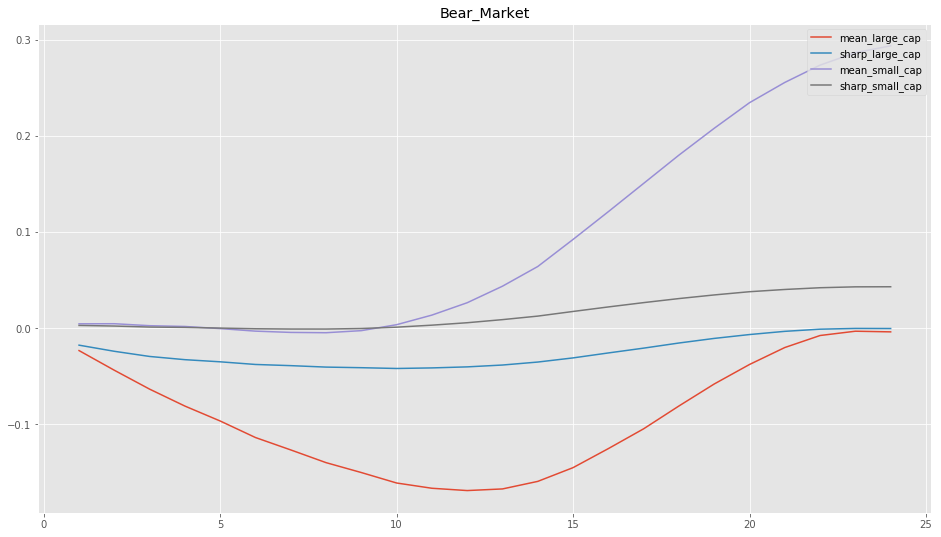

In [319]:
plt.plot(t['mean'],label='mean_large_cap')
plt.plot(t['sharp'],label='sharp_large_cap')
plt.plot(s['mean'],label='mean_small_cap')
plt.plot(s['sharp'],label='sharp_small_cap')
plt.title('Bear_Market')
style.use("ggplot")
plt.rcParams["figure.figsize"]=[16,9]
plt.legend(loc=1)

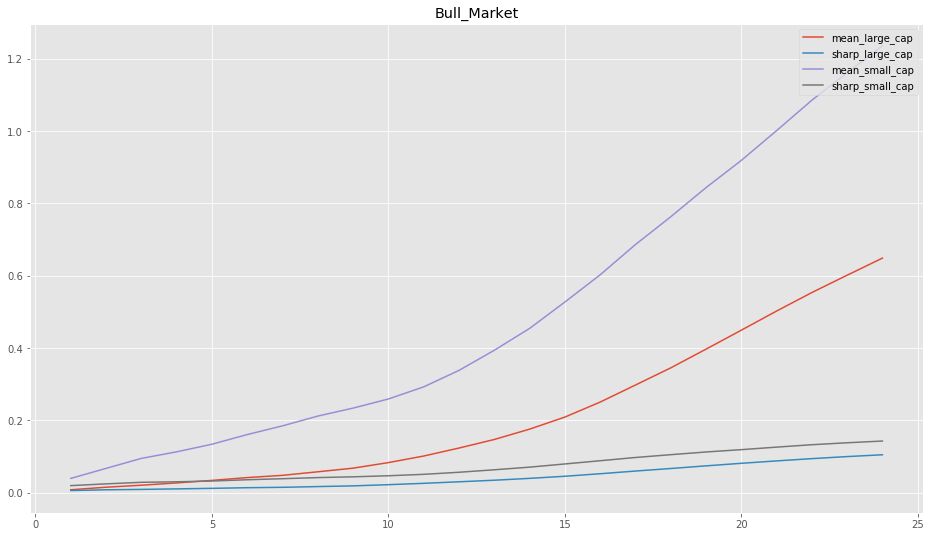

In [321]:
plt.plot(t['mean'],label='mean_large_cap')
plt.plot(t['sharp'],label='sharp_large_cap')
plt.plot(s['mean'],label='mean_small_cap')
plt.plot(s['sharp'],label='sharp_small_cap')
plt.title('Bull_Market')
style.use("ggplot")
plt.rcParams["figure.figsize"]=[16,9]
plt.legend(loc=1)


In [209]:
def max_draw(date,coin,df):#
    dates=[]
    perf=[]
    price=[]
    drawdowns=[perf]
    df=df[df['coin']==coin]
    for h in range(1,24):
        if date+timedelta(hours=24) < df.index[-1]:
            perf.append((df.low.loc[date+timedelta(hours=h)]-df.close.loc[date])/df.close.loc[date])
            dates.append(date+timedelta(hours=h))
            
    drawdowns=pd.DataFrame(drawdowns)
    drawdowns=drawdowns.transpose()
    drawdowns.index=dates
    return drawdowns.min()



In [ ]:
#loop through each trade in entry datframe and calculate the worse drawdown over 24hr
max_draws=[]
start=time.time()
for i in range(len(entry)):
    max_draws.append(max_draw(entry.index[i],entry['coin'][i],df)[0])
print ("Runtime is " +str(time.time()-start)+" seconds")

In [ ]:
entry['max_draw']=max_draws#add the max drawdown column to our entry dataframe
#pickle entry
filename = 'entry_draw'
outfile = open(filename,'wb')
pickle.dump(entry,outfile)
outfile.close()
entry.tail()

In [16]:
#load entry 
filename = 'entry_draw'
infile = open(filename,'rb')
entry = pickle.load(infile)
infile.close()


In [862]:
custom=entry.copy()
custom['max_draw']=custom['max_draw']*100

def stop_loss(entry_real,loss):
    entry=entry_real.copy()
    entry=entry.dropna()
    pnl=[]
    for i in range(len(entry)):
        if entry['max_draw'].iloc[i]<-loss:
            pnl.append(-loss)
        else:
            pnl.append(entry['Pnl_Long'].iloc[i])
    entry_real['Pnl_Long'].iloc[:len(pnl)]=pnl
    return entry_real

entry=stop_loss(custom,5)#filters the entry dataframe, depending on max drawdowns


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:

### Split the data into training, testing sets
train = entry[(pd.to_datetime(entry.index) < pd.to_datetime('2018-12-01')) & 
           (pd.to_datetime(entry.index) >= pd.to_datetime('2013-01-01'))]
test = entry[pd.to_datetime(entry.index) >= pd.to_datetime('2018-12-01')]
X_train = train.loc[:,features]
y_train = train.loc[:,'label']
X_test = test.loc[:,features]
y_test = test.loc[:,'label']

X = entry.loc[:,features]
Y=entry.loc[:,'label']

print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))
    


Length of Training Set: 131557
Length of Testing Set: 35147


In [249]:
#optimise hyperparameters, choose set with lowest log_loss
log_losses={}

for n in range(100,400,100):
    for md in range(1,7):
        for mln in range(50,400,100):
            for nl in range(10,20,10):
                for lr in frange(.01,.2,.05):
                    param = {'max_depth':md, 'num_leaves':nl, 'learning_rate':lr, 'num_trees':n,'num_threads':-1,
         'min_data_in_leaf':mln, 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
                    data = lgb.Dataset(X_train, y_train)
                    bst=lgb.train(param, data)
                    y_pred=bst.predict(X_test)
                    sc=log_loss(y_test,y_pred)
                    log_losses[str(n)+'_'+str(md)+'_'+str(mln)+'_'+str(nl)+'_'+str(lr)]=sc
                    
                        

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [182]:
def optimal_param(data):
    df=pd.DataFrame.from_dict(data,orient='index')
    df.columns=['score']
    df=df.reset_index()
    split = df["index"].str.split("_", n = 4, expand = True) 
    df=df.join(split,how='outer')
    df=df.iloc[:,1:]
    df.columns=['score','num_trees','max_depth','min_leaf_data','num_leaves','learning_rate']
    for i in range(1,6):
        df.iloc[:,i]=pd.to_numeric(df.iloc[:,i])
    df=df.round(4)
    df=df.sort_values(by=['score'])
    return df

opt=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param'
outfile = open(filename,'wb')
pickle.dump(opt,outfile)
outfile.close()
opt.head()


,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
45,0.5163,100,3,350,10,0.06
22,0.5169,100,2,150,10,0.11
23,0.5170,100,2,150,10,0.16
26,0.5173,100,2,250,10,0.11
27,0.5173,100,2,250,10,0.16


In [17]:
#load optimal long parameters
filename = 'opt_param'
infile = open(filename,'rb')
opt = pickle.load(infile)
infile.close()
opt.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
45,0.5163,100,3,350,10,0.06
22,0.5169,100,2,150,10,0.11
23,0.5170,100,2,150,10,0.16
26,0.5173,100,2,250,10,0.11
27,0.5173,100,2,250,10,0.16


In [170]:
opt_short=optimal_param(log_losses)
#pickle the parameters 
filename = 'opt_param_short'
outfile = open(filename,'wb')
pickle.dump(opt_short,outfile)
outfile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
18,0.5246,100,2,50,10,0.11
33,0.5248,100,3,50,10,0.06
113,0.5252,200,2,50,10,0.06
117,0.5254,200,2,150,10,0.06
34,0.5256,100,3,50,10,0.11


In [9]:
#load optimal short parameters
filename = 'opt_param_short'
infile = open(filename,'rb')
opt_short = pickle.load(infile)
infile.close()
opt_short.head()

,score,num_trees,max_depth,min_leaf_data,num_leaves,learning_rate
18,0.5246,100,2,50,10,0.11
33,0.5248,100,3,50,10,0.06
113,0.5252,200,2,50,10,0.06
117,0.5254,200,2,150,10,0.06
34,0.5256,100,3,50,10,0.11


In [18]:
def xgb_gbm(long,test):
    n=0
    data = lgb.Dataset(X_train, y_train)
    if long==True:
        param = {'max_depth':opt['max_depth'].iloc[n], 'num_leaves':opt['num_leaves'].iloc[n], 'learning_rate':opt['learning_rate'].iloc[n], 'num_trees':opt['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    else:
        param = {'max_depth':opt_short['max_depth'].iloc[n], 'num_leaves':opt_short['num_leaves'].iloc[n], 'learning_rate':opt_short['learning_rate'].iloc[n], 'num_trees':opt_short['num_trees'].iloc[n],'num_threads':-1,
                 'min_data_in_leaf':opt_short['min_leaf_data'].iloc[n], 'objective':'binary', 'metric':'binary_logloss','verbosity':-1}
    
    bst = lgb.train(param, data)
    y_pred = bst.predict(X_test)
    
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred >0.5]
    if long==True:
        trades['cpl'] = trades.Pnl_Long.cumsum()
        test['cpl'] = test.Pnl_Long.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_long'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()

    
    else:
        trades['cpl'] = trades.Pnl_Short.cumsum()
        test['cpl'] = test.Pnl_Short.cumsum()
        #pickle the decision rules
        filename = 'xg_boost_short'
        outfile = open(filename,'wb')
        pickle.dump(bst,outfile)
        outfile.close()
    return test,trades,y_pred
    

#test=xgb_gbm(False,test)[0]
#trades=xgb_gbm(False,test)[1]

test=xgb_gbm(True,test)[0]
trades=xgb_gbm(True,test)[1]


'Predicted trades '+str((xgb_gbm(True,test)[2].sum())/len(test))+'  :  Actual trades '+str((test.label.sum())/len(test))

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'Predicted trades 0.33378568438090284  :  Actual trades 0.3158448800751131'

In [229]:
def drawdowns(equity_curve):
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max()#, duration

def stats_v2(trades,y_pred,prob):
    trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    col=['Mean_Return','Std','Count','Total','Sharpe']
    df=[trades.Pnl.mean(),trades.Pnl.std(),len(trades),trades.Pnl.sum(),trades.Pnl.mean()/trades.Pnl.std()]
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    return df

def stats(trades,test,y_pred,prob,t,direction):
    #trades = test.assign(pred = y_pred)
    trades = trades[trades.pred>prob]
    if direction=='long':
        ret=trades.Pnl_Long
        bench=test.Pnl_Long
    else:
        ret=trades.Pnl_Short
        bench=test.Pnl_Short
    
    neg1=bench[bench<0]
    neg=ret[ret<0]
    col=['Mean_Return','Std','Count','Total','Sharpe','Sortino','Calmar','1day_Calmar']
    df=[ret.mean(),ret.std(),len(trades),ret.sum(),ret.mean()/ret.std(),ret.mean()/neg.std(),trades.cpl.max()/drawdowns(trades.cpl),ret.mean()/abs(ret.min())]
    df1=[bench.mean(),bench.std(),len(test),bench.sum(),bench.mean()/bench.std(),ret.mean()/neg1.std(),test.cpl.max()/drawdowns(test.cpl),bench.mean()/abs(bench.min())]
    df1=pd.DataFrame(df1)
    df1=df1.transpose()
    df1.columns=col
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    if t=='base':
        df=df.append(df1)
        df.index=['ML','Basic']
    return df

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def opt_prob(direction):
    p=.5
    prob=[p]
    df=stats(trades,test,y_pred,p,'t',direction)  
    for x in frange(.55,trades.pred.max(),.05):
        try:
            df=df.append(stats(trades,test,y_pred,x,'t',direction))
            prob.append(x)
        except:
            break
            
    df.index=prob
    return df


res=opt_prob('long')
res


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.057185,7.988072,6780.0,7167.715833,0.132345,0.234579,1.784444,0.040071
0.55,1.165007,8.394039,4888.0,5694.553886,0.138790,0.251008,1.784444,0.045752
0.60,1.513516,8.773118,2993.0,4529.954485,0.172517,0.318340,1.784444,0.063967
0.65,2.598827,9.632791,1512.0,3929.425846,0.269790,0.525731,1.781953,0.109837
0.70,2.329953,8.189121,685.0,1596.017963,0.284518,0.424746,1.773688,0.098473
0.75,3.020699,9.217485,321.0,969.644279,0.327714,0.494478,1.763249,0.127667
0.80,2.803322,9.296975,125.0,350.415263,0.301531,0.476270,1.838787,0.135182
0.85,3.106071,9.317641,35.0,108.712488,0.333354,0.419261,1.829546,0.149782
0.90,0.086810,15.941407,4.0,0.347238,0.005446,0.006781,-0.068107,0.004186


In [253]:
res=opt_prob('long')
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.075272,8.050134,6775.0,7284.965213,0.133572,0.236158,1.754447,0.040756
0.55,1.260657,8.475956,4718.0,5947.781988,0.148733,0.273238,1.754447,0.047783
0.60,1.522653,9.002958,2778.0,4229.929047,0.169128,0.324095,1.751139,0.064354
0.65,2.168846,8.970711,1475.0,3199.047850,0.241770,0.451523,1.743637,0.091664
0.70,2.660236,8.666711,702.0,1867.485493,0.306949,0.497792,1.742243,0.112433
0.75,3.098264,8.943573,336.0,1041.016675,0.346423,0.515852,1.757395,0.130945
0.80,3.223646,9.013340,116.0,373.942901,0.357653,0.523571,1.798708,0.155451
0.85,2.383133,8.585395,34.0,81.026536,0.277580,0.370948,1.707631,0.114920
0.90,0.086810,15.941407,4.0,0.347238,0.005446,0.006781,-0.082374,0.004186


In [161]:
res=opt_prob('short')#BB >.8
res

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,2.023463,8.720333,2264.0,4581.119586,0.232040,0.253009,3.940505,0.034055
0.55,2.195770,9.138583,1666.0,3658.152046,0.240275,0.249474,4.006901,0.036955
0.60,2.271357,9.741164,1160.0,2634.773628,0.233171,0.238450,3.975660,0.038227
0.65,2.642172,10.781265,727.0,1920.859389,0.245071,0.246126,4.038992,0.044468
0.70,2.999634,12.336719,403.0,1208.852578,0.243147,0.247527,4.038733,0.050485
0.75,3.390020,13.989100,185.0,627.153741,0.242333,0.266705,4.043630,0.071859
0.80,3.511514,16.439977,82.0,287.944123,0.213596,0.254532,4.138005,0.074434
0.85,10.205103,5.509673,17.0,173.486751,1.852216,NaN,inf,211.222955
0.90,13.061135,NaN,1.0,13.061135,NaN,NaN,NaN,1.000000


In [174]:
res=opt_prob('short')#BB>.7
res

,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
0.50,1.401089,9.127379,3006.0,4211.674366,0.153504,0.166071,1.880390,0.021858
0.55,1.525610,9.935145,1926.0,2938.324175,0.153557,0.154174,1.882936,0.023801
0.60,1.497149,11.262138,1236.0,1850.476050,0.132936,0.132341,1.888982,0.023357
0.65,1.310201,13.029877,750.0,982.650513,0.100554,0.106546,1.870018,0.020440
0.70,1.777635,14.017022,423.0,751.939547,0.126820,0.132085,1.864879,0.027733
0.75,2.000505,14.901157,211.0,422.106644,0.134252,0.134984,1.848471,0.031210
0.80,5.201997,11.873439,77.0,400.553758,0.438120,0.412869,1.732755,0.110268
0.85,9.825778,6.813996,22.0,216.167123,1.441999,NaN,2.156461,1.067144
0.90,12.458875,3.506325,5.0,62.294373,3.553257,NaN,4.609240,1.644643


In [469]:
def trade_count(trades):#plots rolling 24hr positions
    start=trades.index[0]
    init=trades[trades.index<start+timedelta(hours=24)].copy()
    init['position']=np.arange(len(init))
    end=trades.index[-1]
    #trades['positions']=0
    for i in  range(1,(end-start).days):
        s=start+timedelta(hours=(24*i))
        e=start+timedelta(hours=(24*i+24))
        one_day=trades[(trades.index>s)&(trades.index<e)].copy()
        one_day['position']=np.arange(len(one_day))
        init=init.append(one_day)
    return init


d=trade_count(trades)  
d.position.plot()
style.use("ggplot")
plt.rcParams["figure.figsize"]=[16,9]
plt.title("Position History")

Original PnL - No ML


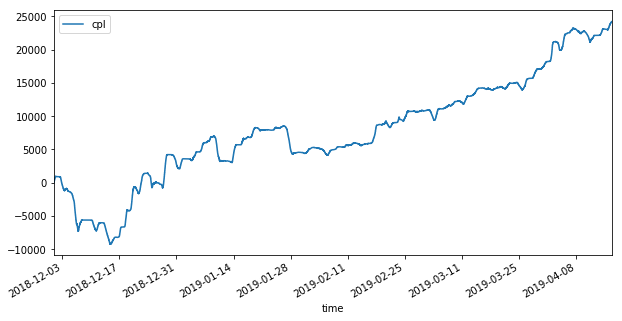

----------------
PnL with ML


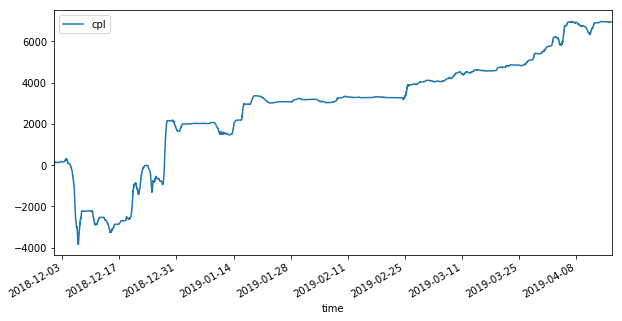

In [20]:

print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original PnL - No ML


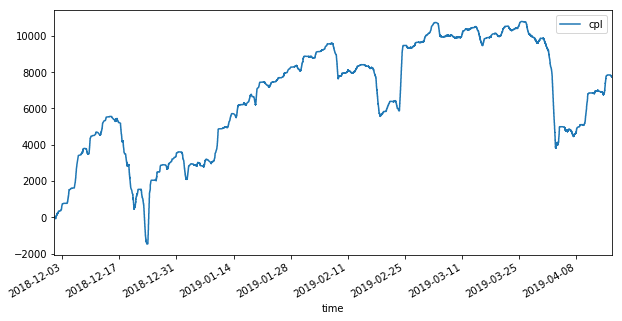

----------------
PnL with ML


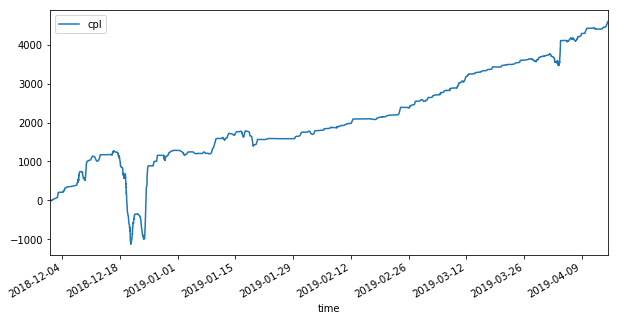

In [14]:
trades['cpl'] = trades.Pnl_Short.cumsum()

test['cpl'] = test.Pnl_Short.cumsum()
print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

In [190]:
def divergence_v2(close,RSI,lookback,window,maxx,low):
    x=RSI.values
    peaks=argrelextrema(x, np.greater,order=5)[0]
    troughs=argrelextrema(x, np.less,order=5)[0]
    bear_rsi=[]
    bear_price=[]
    bull_rsi=[]
    bull_price=[]
    hid_bear_rsi=[]
    hid_bear_price=[]
    hid_bull_rsi=[]
    hid_bull_price=[]
    for x in peaks:    
        if RSI.iloc[x]>maxx:
            if RSI.iloc[x]<max(RSI.iloc[max(0,x-lookback):x]):
                bear_rsi.append(x)
            if close.iloc[x]>max(close.iloc[max(0,x-lookback):x]):
                bear_price.append(x)
            if RSI.iloc[x]>max(RSI.iloc[max(0,x-lookback):x]):
                hid_bear_rsi.append(x)
    
    for t in troughs:
        if RSI.iloc[t]<low:
            if close.iloc[t]<min(close.iloc[max(0,t-lookback):t]):
                bull_price.append(t)
            if RSI.iloc[t]<min(RSI.iloc[max(0,t-lookback):t]):
                hid_bull_rsi.append(t) 
    
    for z in range(1,len(troughs)):
        if RSI.iloc[troughs[z]]<low:
            if RSI.iloc[troughs[z]]>RSI.iloc[troughs[z-1]]:
                bull_rsi.append(troughs[z]) 
            if close.iloc[troughs[z]]>close.iloc[troughs[z-1]]:
                hid_bull_price.append(troughs[z]) 
    
    for t in range(1,len(peaks)):
        if RSI.iloc[peaks[t]]>maxx:
            if close.iloc[peaks[t]]<close.iloc[peaks[t-1]]:
                hid_bear_price.append(peaks[t]) 
            
    dt=set(bear_rsi)
    dt2=set(bear_price)
    dt3=set(bull_rsi)
    dt4=set(bull_price)
    dt5=set(hid_bull_rsi)
    dt6=set(hid_bull_price)
    dt7=set(hid_bear_rsi)
    dt8=set(hid_bear_price)
    mergedlist=dt.intersection(dt2)
    mergedlist=np.array(list(mergedlist))
    mergedlist2=dt3.intersection(dt4)
    mergedlist2=np.array(list(mergedlist2))
    mergedlist3=dt5.intersection(dt6)
    mergedlist3=np.array(list(mergedlist3))
    mergedlist4=dt7.intersection(dt8)
    mergedlist4=np.array(list(mergedlist4))
    bull_div=np.sort(mergedlist2)
    bear_div=np.sort(mergedlist)
    hid_bull_div=np.sort(mergedlist3)
    hid_bear_div=np.sort(mergedlist4)
    return bull_div,bear_div,hid_bull_div,hid_bear_div

